In [1]:
# ------------------------------------------#
#        Expt 5: Perform a battery of negative inference tests from a single script and plot results, save metadata    
# ------------------------------------------#

Threads.nthreads()
begin
    using LinearAlgebra 
    using Plots
    using FFTW
    using FileIO
    using JLD2
    using DiffEqFlux
    using OrdinaryDiffEq
    using BlockArrays
    using LaTeXStrings
    using SparseArrays
    using BSON
    using Distances
    using DifferentialEquations
    using Optimization
    using OptimizationPolyalgorithms
    using Zygote
    using OptimizationOptimJL
    using OptimizationOptimisers
    using DiffEqSensitivity
    using DelimitedFiles
    using HDF5
    using Plots
    using InvertedIndices
end 

In [2]:
filename = "/home/tschala/research/LANL/case1_1_1D_waveforms_results.h5"
file = h5open(filename, "r")
# Read the dataset
data1d = read(file["data"])

# Close the file
close(file)

In [3]:
println("Size of 1D data matrix:",size(data1d))
println("Shape: [timesteps,spatial locations,waveforms,variables]")

# note that some elements in space a duplicate
# the real spatial size is 100

Size of 1D data matrix:(300, 110, 47, 4)
Shape: [timesteps,spatial locations,waveforms,variables]


In [4]:
# remove duplicate data (both ends of a segment are saved)
data1d_fix = data1d[200:end,Not(11:11:end),:,:];
# remove the unphysical peaks, just replace with linear interpolation
# data1d_fix[:,41,:,1] = (data1d_fix[:,40,:,1] + data1d_fix[:,42,:,1])/2;
# data1d_fix[:,61,:,1] = (data1d_fix[:,60,:,1] + data1d_fix[:,62,:,1])/2;

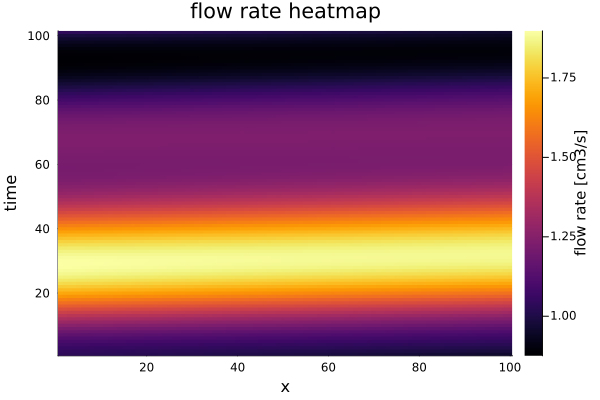

In [5]:
heatmap(data1d_fix[:,:,20,1], title="flow rate heatmap", cbar_title = "flow rate [cm3/s]")
xlabel!("x")
ylabel!("time")


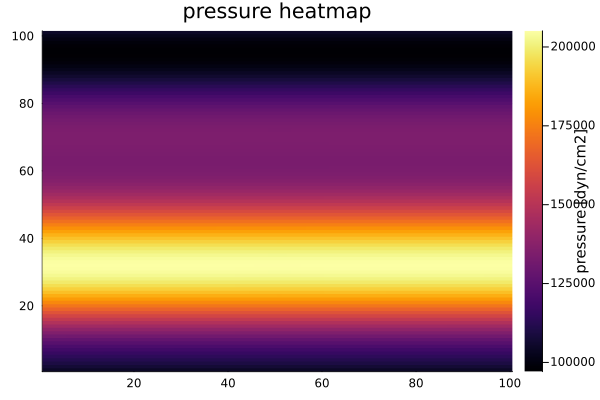

In [6]:
heatmap(data1d_fix[1:end,:,20,2], title="pressure heatmap", cbar_title = "pressure [dyn/cm2]")

In [7]:
begin
    global dt = 0.01                     # time step
    global T = 1.0                   # total time
    global tsteps = 0.0:dt:T             # discretized time dimension
    global tspan = (0,T)                 # end points of time integration for ODEProbem

    global train_maxiters = 5         # number of iterations of learning
    global learning_rate  = 0.005         # learning rate , currently using PolyOpt default (0.1)


end

0.005

In [8]:
#waveforms to use
waveforms = 5

5

In [9]:
# for simplicity use every other point in x
# u0 = data1d_fix[1,1:2:end,1:waveforms:end,1];
u0 = data1d_fix[1,1:2:end,1:waveforms,1];
u01 = data1d_fix[1,1:2:end,1,1];

In [10]:
# ytrain2 = data1d_fix[:,1:2:end,1:waveforms:end,1];
ytrain2 = data1d_fix[:,1:2:end,1:waveforms,1];
ytrain21 = data1d_fix[:,1:2:end,1,1];


In [11]:
# bc_flow = data1d_fix[:,1,1:waveforms:end,1];
bc_flow = data1d_fix[:,1,1:waveforms,1];
bc_flow1 = bc_flow[:,1];

In [12]:
size(bc_flow)

(101, 5)

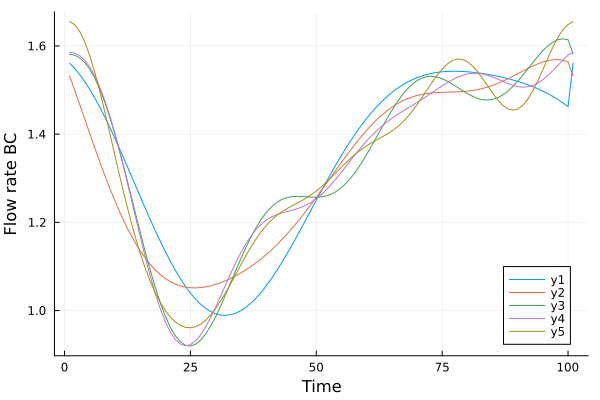

In [13]:
plot(bc_flow)
xlabel!("Time")
ylabel!("Flow rate BC")

In [14]:
u0val = data1d_fix[1,1:2:end,waveforms+2:2*waveforms,1];
ytrain2val = data1d_fix[:,1:2:end,waveforms+2:2*waveforms,1];
bc_flow_val = data1d_fix[:,1,waveforms+2:2*waveforms,1];

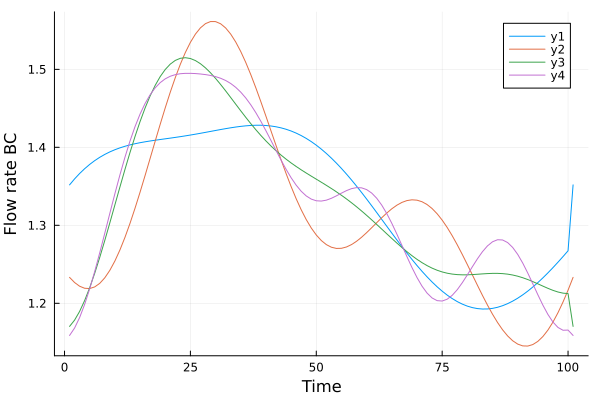

In [15]:
plot(bc_flow_val)
xlabel!("Time")
ylabel!("Flow rate BC")

In [16]:
N = size(u01,1)
# NN embedded in PDE for Differential programming
# Define the network architecture with initialization
hidden_dim = 10

ann = Chain(
    Dense(N + size(bc_flow1)[1], hidden_dim, tanh, init = Flux.glorot_uniform),
    Dense(hidden_dim, hidden_dim, tanh, init = Flux.glorot_uniform),
    Dense(hidden_dim, hidden_dim, tanh, init = Flux.glorot_uniform),
    Dense(hidden_dim, N, init = Flux.glorot_uniform)
)

Chain(
  Dense(151 => 10, tanh),               # 1_520 parameters
  Dense(10 => 10, tanh),                # 110 parameters
  Dense(10 => 10, tanh),                # 110 parameters
  Dense(10 => 50),                      # 550 parameters
)                   # Total: 8 arrays, 2_290 parameters, 9.445 KiB.

In [17]:
# flatten parameters in NN for learning.                
p, re = Flux.destructure(ann);
ps = deepcopy(p)
p_size = size(p,1);
println("Number of parameters in neural network: $p_size"); 

Number of parameters in neural network: 2290


In [18]:
# function learn_1DBlood(u, p, t, bc_left)
#     Φ = re(p) # restructure flattened parameter vector into NN architecture.
#     # Apply boundary conditions
#     u[1] = bc_left(t)
#     return Φ(u)
# end



function learn_1DBlood(u, p, t, bc_left)
    Φ = re(p)  # restructure flattened parameter vector into NN architecture.
    
    #concatenate u and the BC as input to the NN
    input = vcat(u,bc_left)
    
    return Φ(input)  # Call Φ with modified input
end



learn_1DBlood (generic function with 1 method)

In [19]:
# Define time-dependent boundary conditions
function bc_left(t, bc_flow1)
    # Define the value of the boundary condition at the left boundary for a given time t

    # Find the two closest points in bc_flow1
    #caculate the time index that's closest to time t
    t_index = Int(floor(t / dt)) + 1
    # calculate local time fraction between the grid points
    t_frac = (t - (t_index - 1) * dt) / dt

    # Perform linear interpolation
    # if we are at the last timesteps just copy the value cause t_index+1 will not exist
    if t == T
        bc_interp = bc_flow1[t_index]
        
    else
        bc_interp = (1 - t_frac) * bc_flow1[t_index] + t_frac * bc_flow1[t_index + 1]
    end
    
    return bc_interp
end


# Define time-dependent boundary condition function
bc_left_func(t) = bc_left(t, bc_flow1)

bc_left_func (generic function with 1 method)

In [20]:
#define learning problem.
learn_1DBlood_prob(u01,tspan) =  ODEProblem((u, p, t) -> learn_1DBlood(u, p, t, bc_left_func), u01, tspan, p)


learn_1DBlood_prob (generic function with 1 method)

In [21]:
ode_solver = "Tsit5"
output_dir = "/home/tschala/research/LANL/paramBC_testNODE"
working_dir = output_dir
# calculate and save the untrained solution 
begin 
    learn_1DBlood_prob_untrained(u01,tspan) = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t, bc_flow1), u01, tspan, p)     # p changes after training   
    if ode_solver == "Tsit5"
        sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Tsit5(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
    elseif ode_solver == "RK4"
        sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),RK4(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
    elseif ode_solver == "Rosenbrock23"
        sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Rosenbrock23(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
    end
    save_object(output_dir*"/sol_learn_testNODE_untrained.jld2",sol_learn_1DBlood_untrained)
    println("saved untrained solution")
end 

┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(151 => 10, tanh)  # 1_520 parameters
│   summary(x) = "151-element Vector{Float64}"
└ @ Flux ~/.julia/packages/Flux/EHgZm/src/layers/stateless.jl:60


saved untrained solution


In [22]:
prob = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t, bc_flow1), u01, tspan, p) ;
function predict(θ,prob)
    if ode_solver == "Tsit5"
        Array(solve(prob,Tsit5(),p=θ,dt=dt,saveat=dt))
    elseif ode_solver == "RK4"
        Array(solve(prob,RK4(),p=θ,dt=dt,saveat=dt))
    elseif ode_solver == "Rosenbrock23"
        Array(solve(prob,Rosenbrock23(),p=θ,dt=dt,saveat=dt))
    end
end 

predict (generic function with 1 method)

In [23]:
function loss(θ, ytrain21, prob)
    pred = predict(θ, prob)
    l = sum(abs2,(pred[:,:] - ytrain21))#  + 1e-3*sum(abs.(θ)) #add regularization
    return l, pred
end


# l , pred = loss(ps,ytrain21,prob)

# training optimizer definition
adtype = Optimization.AutoZygote() ;
optf = Optimization.OptimizationFunction((x,p)->loss(x,ytrain21,prob),adtype) ;

In [40]:
path_checkpoint=nothing
optimizer_choice1 = "ADAM"
optimizer_choice2 = "ADAM"

"ADAM"

In [41]:
path_to_working_directory="/home/tschala/research/LANL/juliaDiffProgExample/"

include("$path_to_working_directory/src/numerical_derivatives.jl");
include("$path_to_working_directory/src/train_utils.jl");

In [42]:
# process user choices

if !isdir(working_dir)
    mkdir(working_dir)
end
output_dir = working_dir*"/output/"
cd(working_dir) #switch to working directory
if !isdir(output_dir)
    mkdir(output_dir)
end
println("optimizer 1 is $optimizer_choice1")
if !isnothing(optimizer_choice2)
    println("optimizer 2 is $optimizer_choice2 optimizer")
end

println("ODE Time integrator selected:", ode_solver)


optimizer 1 is ADAM
optimizer 2 is ADAM optimizer
ODE Time integrator selected:Tsit5


In [43]:
# restart training from previaous checkpoint if it exists, else start 
# fresh training.
if !isnothing(path_checkpoint)
    checkpoint_exists = isfile(path_checkpoint)
    if checkpoint_exists
        println("Checkpoint exists!")
        ckpt_restart = jldopen(path_checkpoint,"r")
        res1 = ckpt_restart["ckpt"]
        uinit = copy(res1.u)
    else
        println("ckpt path given, but no file found!")
    end
else
    uinit = deepcopy(ps)
    println("Fresh training initialized")
end

Fresh training initialized


nt:100
Start training epoch 1
time: 1/1
waveform: 1/5
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-1.4001102
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 457.74178389329995
Iteration: 2 || Loss: 455.6470133577269
Iteration: 3 || Loss: 453.6211204102922
Iteration: 4 || Loss: 451.6675722517905
Iteration: 5 || Loss: 449.78514027949893
Iteration: 6 || Loss: 449.78514027949893
saving ADAM checkpoint...
Sum of params:-1.7870847
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 449.78514027949893
Iteration: 2 || Loss: 447.95148134196074
Iteration: 3 || Loss: 446.1420400524969
Iteration: 4 || Loss: 444.3576178253044
Iteration: 5 || Loss: 442.6078157571747
Iteration: 6 || Loss: 440.8938744248554
Iteration: 7 || Loss: 439.21249970589355
Iteration: 8 || Loss: 437.563389979381
Iteration: 9 || Loss: 435.9486152505189
Iteration: 10 || Loss: 434.3694685140805
Iteration: 11 || Loss: 432.82504302609425
Iteration: 12 || Loss: 431.31380650357437
Iter

Iteration: 186 || Loss: 356.7131499085276
Iteration: 187 || Loss: 356.60453008969773
Iteration: 188 || Loss: 356.4957662459266
Iteration: 189 || Loss: 356.3868954884725
Iteration: 190 || Loss: 356.2778700386472
Iteration: 191 || Loss: 356.16877003482256
Iteration: 192 || Loss: 356.05949988388267
Iteration: 193 || Loss: 355.95009622582285
Iteration: 194 || Loss: 355.84059986713294
Iteration: 195 || Loss: 355.7309424645169
Iteration: 196 || Loss: 355.6211815707403
Iteration: 197 || Loss: 355.51130077959476
Iteration: 198 || Loss: 355.4012770496267
Iteration: 199 || Loss: 355.29111949491175
Iteration: 200 || Loss: 355.18086796875815
Iteration: 201 || Loss: 355.070461299117
Iteration: 202 || Loss: 354.9599598042588
Iteration: 203 || Loss: 354.84931372550784
Iteration: 204 || Loss: 354.738552371202
Iteration: 205 || Loss: 354.6276530604775
Iteration: 206 || Loss: 354.5166600153735
Iteration: 207 || Loss: 354.4055410729303
Iteration: 208 || Loss: 354.2942888443974
Iteration: 209 || Loss: 354

Iteration: 380 || Loss: 334.43129519667804
Iteration: 381 || Loss: 334.31888286627657
Iteration: 382 || Loss: 334.20653293937085
Iteration: 383 || Loss: 334.0942978733269
Iteration: 384 || Loss: 333.98214934732414
Iteration: 385 || Loss: 333.870132595315
Iteration: 386 || Loss: 333.75815581847485
Iteration: 387 || Loss: 333.64642696378394
Iteration: 388 || Loss: 333.53467673747343
Iteration: 389 || Loss: 333.42306016714485
Iteration: 390 || Loss: 333.3116269972477
Iteration: 391 || Loss: 333.2002094498257
Iteration: 392 || Loss: 333.0889441019088
Iteration: 393 || Loss: 332.97780795768426
Iteration: 394 || Loss: 332.866738686199
Iteration: 395 || Loss: 332.7558106780235
Iteration: 396 || Loss: 332.6449660981283
Iteration: 397 || Loss: 332.53428004602733
Iteration: 398 || Loss: 332.42367603116253
Iteration: 399 || Loss: 332.3131374258196
Iteration: 400 || Loss: 332.20279443245886
Iteration: 401 || Loss: 332.0925429700968
Iteration: 402 || Loss: 331.9823722051195
Iteration: 403 || Loss: 

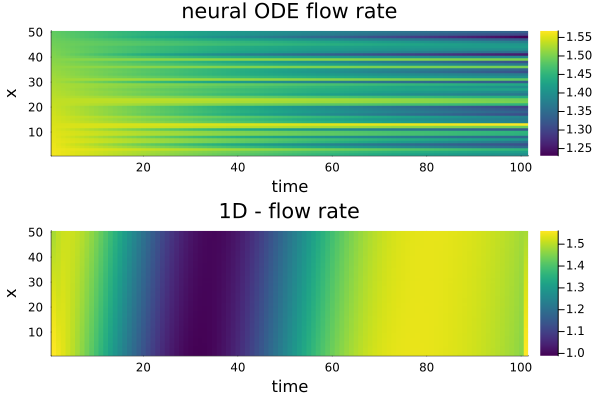

waveform: 2/5
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-9.21002
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 339.7012791449407
Iteration: 2 || Loss: 338.1121295025031
Iteration: 3 || Loss: 337.2318198448503
Iteration: 4 || Loss: 336.9255439074334
Iteration: 5 || Loss: 336.88563098216525
Iteration: 6 || Loss: 336.88563098216525
saving ADAM checkpoint...
Sum of params:-9.310139
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 336.88563098216525
Iteration: 2 || Loss: 336.38942355468623
Iteration: 3 || Loss: 336.2325443690928
Iteration: 4 || Loss: 335.9440293788336
Iteration: 5 || Loss: 335.5990193286995
Iteration: 6 || Loss: 335.31528641177897
Iteration: 7 || Loss: 335.1157542608761
Iteration: 8 || Loss: 334.94219837274767
Iteration: 9 || Loss: 334.746339293651
Iteration: 10 || Loss: 334.53691265700087
Iteration: 11 || Loss: 334.3494840105963
Iteration: 12 || Loss: 334.2016637140669
Iteration: 13 || Loss: 334.0781682276582
Iterati

Iteration: 187 || Loss: 308.9418212297716
Iteration: 188 || Loss: 308.7316813067764
Iteration: 189 || Loss: 308.51870214081714
Iteration: 190 || Loss: 308.307076172505
Iteration: 191 || Loss: 308.09142967151786
Iteration: 192 || Loss: 307.8771778718476
Iteration: 193 || Loss: 307.66153733934476
Iteration: 194 || Loss: 307.44399233675085
Iteration: 195 || Loss: 307.2252167764404
Iteration: 196 || Loss: 307.00599957901966
Iteration: 197 || Loss: 306.7848287537425
Iteration: 198 || Loss: 306.5628754383037
Iteration: 199 || Loss: 306.34057730749714
Iteration: 200 || Loss: 306.1167368911627
Iteration: 201 || Loss: 305.89238684783334
Iteration: 202 || Loss: 305.66661739845813
Iteration: 203 || Loss: 305.43935545228135
Iteration: 204 || Loss: 305.21094058293545
Iteration: 205 || Loss: 304.9819971363247
Iteration: 206 || Loss: 304.7521189237862
Iteration: 207 || Loss: 304.5216175640807
Iteration: 208 || Loss: 304.28917083933663
Iteration: 209 || Loss: 304.0555713774499
Iteration: 210 || Loss: 

Iteration: 381 || Loss: 253.1375195022148
Iteration: 382 || Loss: 252.82561109612152
Iteration: 383 || Loss: 252.51416813734488
Iteration: 384 || Loss: 252.2030677776562
Iteration: 385 || Loss: 251.8926860075896
Iteration: 386 || Loss: 251.58246532733202
Iteration: 387 || Loss: 251.2728132523038
Iteration: 388 || Loss: 250.96419970455878
Iteration: 389 || Loss: 250.6550703578207
Iteration: 390 || Loss: 250.34703561354314
Iteration: 391 || Loss: 250.03935914176049
Iteration: 392 || Loss: 249.732043315849
Iteration: 393 || Loss: 249.4252916553799
Iteration: 394 || Loss: 249.11912185065918
Iteration: 395 || Loss: 248.81341672921536
Iteration: 396 || Loss: 248.50834774074642
Iteration: 397 || Loss: 248.2047676574784
Iteration: 398 || Loss: 247.8996831152981
Iteration: 399 || Loss: 247.59632652961878
Iteration: 400 || Loss: 247.29320001820525
Iteration: 401 || Loss: 246.9909904251073
Iteration: 402 || Loss: 246.68906648374735
Iteration: 403 || Loss: 246.38842542525992
Iteration: 404 || Loss

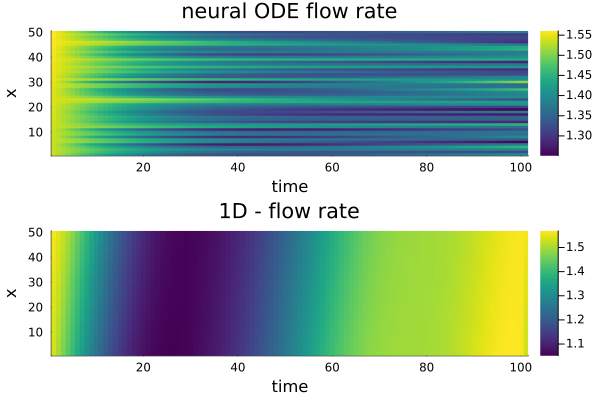

waveform: 3/5
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-29.899456
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 272.04940561873826
Iteration: 2 || Loss: 271.4784147502432
Iteration: 3 || Loss: 271.0808135555457
Iteration: 4 || Loss: 270.78098262716236
Iteration: 5 || Loss: 270.5011172226163
Iteration: 6 || Loss: 270.5011172226163
saving ADAM checkpoint...
Sum of params:-30.20906
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 270.5011172226163
Iteration: 2 || Loss: 270.24805045175634
Iteration: 3 || Loss: 269.92792989525793
Iteration: 4 || Loss: 269.6858926489214
Iteration: 5 || Loss: 269.4084334241488
Iteration: 6 || Loss: 269.14050106012814
Iteration: 7 || Loss: 268.88691629460016
Iteration: 8 || Loss: 268.6267182601813
Iteration: 9 || Loss: 268.3726025785263
Iteration: 10 || Loss: 268.13167895868
Iteration: 11 || Loss: 267.8862310161128
Iteration: 12 || Loss: 267.6279878056698
Iteration: 13 || Loss: 267.3746730777934
Iterati

Iteration: 186 || Loss: 229.3618285699608
Iteration: 187 || Loss: 229.17116052659043
Iteration: 188 || Loss: 228.98093835461717
Iteration: 189 || Loss: 228.79083577427738
Iteration: 190 || Loss: 228.6009121988996
Iteration: 191 || Loss: 228.41136577317104
Iteration: 192 || Loss: 228.22158355866102
Iteration: 193 || Loss: 228.03259373622046
Iteration: 194 || Loss: 227.84383561376714
Iteration: 195 || Loss: 227.65471580780323
Iteration: 196 || Loss: 227.4659350351298
Iteration: 197 || Loss: 227.27756208330914
Iteration: 198 || Loss: 227.08910894386744
Iteration: 199 || Loss: 226.90120331295745
Iteration: 200 || Loss: 226.71309671086954
Iteration: 201 || Loss: 226.52524689394076
Iteration: 202 || Loss: 226.33785424158424
Iteration: 203 || Loss: 226.1503958571052
Iteration: 204 || Loss: 225.9630373544396
Iteration: 205 || Loss: 225.7762959920951
Iteration: 206 || Loss: 225.58938330992487
Iteration: 207 || Loss: 225.4026844648995
Iteration: 208 || Loss: 225.21627061801289
Iteration: 209 || 

Iteration: 378 || Loss: 194.08209662163566
Iteration: 379 || Loss: 193.89353061504772
Iteration: 380 || Loss: 193.7042992848251
Iteration: 381 || Loss: 193.51497470801493
Iteration: 382 || Loss: 193.3255433090946
Iteration: 383 || Loss: 193.13590389698453
Iteration: 384 || Loss: 192.9461212252449
Iteration: 385 || Loss: 192.7559650201679
Iteration: 386 || Loss: 192.56596049770576
Iteration: 387 || Loss: 192.37597958594534
Iteration: 388 || Loss: 192.18551948499507
Iteration: 389 || Loss: 191.9951372950952
Iteration: 390 || Loss: 191.80408348178693
Iteration: 391 || Loss: 191.6133225557332
Iteration: 392 || Loss: 191.42260128894517
Iteration: 393 || Loss: 191.23143546896148
Iteration: 394 || Loss: 191.03994480969618
Iteration: 395 || Loss: 190.8482142699585
Iteration: 396 || Loss: 190.65645676995788
Iteration: 397 || Loss: 190.4646922016398
Iteration: 398 || Loss: 190.2723272640266
Iteration: 399 || Loss: 190.08049777942446
Iteration: 400 || Loss: 189.88797211496967
Iteration: 401 || Lo

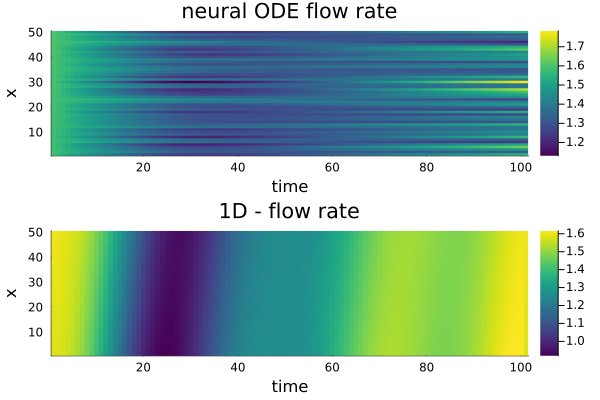

waveform: 4/5
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-44.130154
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 161.08830519704895
Iteration: 2 || Loss: 159.4333586167615
Iteration: 3 || Loss: 158.96780184750372
Iteration: 4 || Loss: 159.06917731125915
Iteration: 5 || Loss: 159.05869079797816
Iteration: 6 || Loss: 158.96780184750372
saving ADAM checkpoint...
Sum of params:-44.12881
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 158.96780184750372
Iteration: 2 || Loss: 158.82801770512285
Iteration: 3 || Loss: 158.50942012954144
Iteration: 4 || Loss: 158.40273934281484
Iteration: 5 || Loss: 158.27436595358392
Iteration: 6 || Loss: 158.04443983038698
Iteration: 7 || Loss: 157.8462674756692
Iteration: 8 || Loss: 157.7056728852429
Iteration: 9 || Loss: 157.5532077786783
Iteration: 10 || Loss: 157.3772110131443
Iteration: 11 || Loss: 157.21717679689647
Iteration: 12 || Loss: 157.07256566762075
Iteration: 13 || Loss: 156.909344529794

Iteration: 185 || Loss: 127.7669628652483
Iteration: 186 || Loss: 127.59306939652362
Iteration: 187 || Loss: 127.41846631974997
Iteration: 188 || Loss: 127.24412592660488
Iteration: 189 || Loss: 127.06953918012753
Iteration: 190 || Loss: 126.89592468456664
Iteration: 191 || Loss: 126.72137995186804
Iteration: 192 || Loss: 126.54761168226204
Iteration: 193 || Loss: 126.37247595699846
Iteration: 194 || Loss: 126.19801957057459
Iteration: 195 || Loss: 126.02332448596508
Iteration: 196 || Loss: 125.84903665626948
Iteration: 197 || Loss: 125.67465801203224
Iteration: 198 || Loss: 125.4996902834547
Iteration: 199 || Loss: 125.3258285155338
Iteration: 200 || Loss: 125.15125300593199
Iteration: 201 || Loss: 124.97692941224621
Iteration: 202 || Loss: 124.80216070887487
Iteration: 203 || Loss: 124.62756874106311
Iteration: 204 || Loss: 124.45271502394576
Iteration: 205 || Loss: 124.27820253345308
Iteration: 206 || Loss: 124.1035330378885
Iteration: 207 || Loss: 123.92875374547395
Iteration: 208 

Iteration: 377 || Loss: 94.7964887494598
Iteration: 378 || Loss: 94.62983542408062
Iteration: 379 || Loss: 94.46460835352943
Iteration: 380 || Loss: 94.29955605409819
Iteration: 381 || Loss: 94.13306169045728
Iteration: 382 || Loss: 93.96753926502385
Iteration: 383 || Loss: 93.80079133536843
Iteration: 384 || Loss: 93.6359285798374
Iteration: 385 || Loss: 93.47058244685748
Iteration: 386 || Loss: 93.30466049245982
Iteration: 387 || Loss: 93.1393114936512
Iteration: 388 || Loss: 92.97437525256771
Iteration: 389 || Loss: 92.80835503678898
Iteration: 390 || Loss: 92.64378208610033
Iteration: 391 || Loss: 92.47824142676615
Iteration: 392 || Loss: 92.31462606150367
Iteration: 393 || Loss: 92.14908193345369
Iteration: 394 || Loss: 91.98317634242481
Iteration: 395 || Loss: 91.81798495649366
Iteration: 396 || Loss: 91.65325325249106
Iteration: 397 || Loss: 91.48862308424007
Iteration: 398 || Loss: 91.32386307885552
Iteration: 399 || Loss: 91.15929665877243
Iteration: 400 || Loss: 90.9950620572

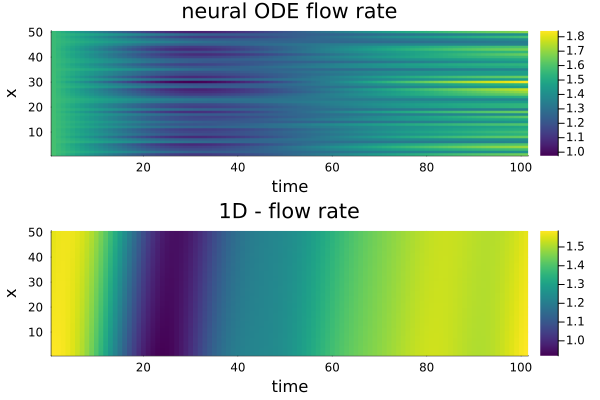

waveform: 5/5
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-57.11168
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 120.99930434002913
Iteration: 2 || Loss: 110.59439048423593
Iteration: 3 || Loss: 102.94230395600732
Iteration: 4 || Loss: 98.02590855552253
Iteration: 5 || Loss: 95.63588889356524
Iteration: 6 || Loss: 95.63588889356524
saving ADAM checkpoint...
Sum of params:-57.23391
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 95.63588889356524
Iteration: 2 || Loss: 95.3496274035497
Iteration: 3 || Loss: 95.19552271079883
Iteration: 4 || Loss: 94.77501486027548
Iteration: 5 || Loss: 94.64671625698368
Iteration: 6 || Loss: 94.6187191278507
Iteration: 7 || Loss: 94.42563766723873
Iteration: 8 || Loss: 94.17603775114026
Iteration: 9 || Loss: 94.02771600382951
Iteration: 10 || Loss: 93.94288272295424
Iteration: 11 || Loss: 93.80752796890246
Iteration: 12 || Loss: 93.60986536552866
Iteration: 13 || Loss: 93.43871833750907
Iteration: 

Iteration: 189 || Loss: 70.25052613647595
Iteration: 190 || Loss: 70.1400290294697
Iteration: 191 || Loss: 70.02704101945032
Iteration: 192 || Loss: 69.91319804808647
Iteration: 193 || Loss: 69.80517058605513
Iteration: 194 || Loss: 69.68761245181722
Iteration: 195 || Loss: 69.58077809422716
Iteration: 196 || Loss: 69.4682359063233
Iteration: 197 || Loss: 69.35990536687429
Iteration: 198 || Loss: 69.24963441504147
Iteration: 199 || Loss: 69.1333480573121
Iteration: 200 || Loss: 69.02410203292082
Iteration: 201 || Loss: 68.9167910407897
Iteration: 202 || Loss: 68.8086976792788
Iteration: 203 || Loss: 68.70041143017383
Iteration: 204 || Loss: 68.59266635128955
Iteration: 205 || Loss: 68.48083193070626
Iteration: 206 || Loss: 68.37457236005599
Iteration: 207 || Loss: 68.2644576554818
Iteration: 208 || Loss: 68.15875293580581
Iteration: 209 || Loss: 68.05140004033962
Iteration: 210 || Loss: 67.94069531944771
Iteration: 211 || Loss: 67.8331534641446
Iteration: 212 || Loss: 67.72940017634383

Iteration: 384 || Loss: 52.69642344559104
Iteration: 385 || Loss: 52.62491920455913
Iteration: 386 || Loss: 52.551455071238536
Iteration: 387 || Loss: 52.47985483804818
Iteration: 388 || Loss: 52.40754448978877
Iteration: 389 || Loss: 52.34378664284121
Iteration: 390 || Loss: 52.259834337483525
Iteration: 391 || Loss: 52.19840416111607
Iteration: 392 || Loss: 52.12212162089306
Iteration: 393 || Loss: 52.05662643204973
Iteration: 394 || Loss: 51.99007423583491
Iteration: 395 || Loss: 51.91704626606379
Iteration: 396 || Loss: 51.842338244772655
Iteration: 397 || Loss: 51.77676515234916
Iteration: 398 || Loss: 51.70224851526048
Iteration: 399 || Loss: 51.63540047812802
Iteration: 400 || Loss: 51.565510182100745
Iteration: 401 || Loss: 51.49904342823013
Iteration: 402 || Loss: 51.426092179185616
Iteration: 403 || Loss: 51.35060421231123
Iteration: 404 || Loss: 51.289354400225335
Iteration: 405 || Loss: 51.21894458715108
Iteration: 406 || Loss: 51.14074420504524
Iteration: 407 || Loss: 51.0

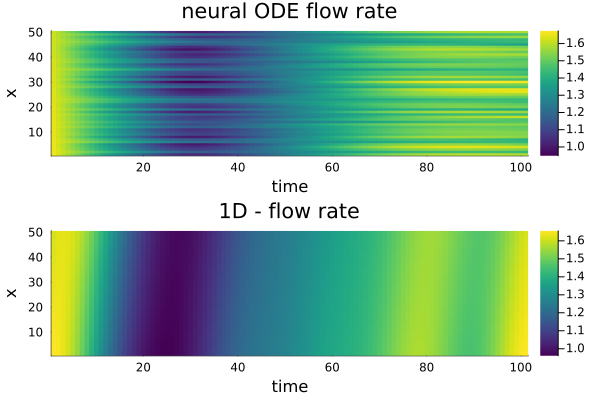

Epoch 1 mean loss loss:166.3747868040462
Start training epoch 2
time: 1/1
waveform: 1/5
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-71.74071
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 160.83071213805567
Iteration: 2 || Loss: 140.69186617144848
Iteration: 3 || Loss: 122.29900347501689
Iteration: 4 || Loss: 105.64024752989766
Iteration: 5 || Loss: 90.71550735066336
Iteration: 6 || Loss: 90.71550735066336
saving ADAM checkpoint...
Sum of params:-71.59631
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 90.71550735066336
Iteration: 2 || Loss: 76.59829695883576
Iteration: 3 || Loss: 63.948854076503316
Iteration: 4 || Loss: 53.27890299449371
Iteration: 5 || Loss: 45.10169501671688
Iteration: 6 || Loss: 39.75992181239985
Iteration: 7 || Loss: 37.32797824419248
Iteration: 8 || Loss: 37.41698660058444
Iteration: 9 || Loss: 39.170114531734455
Iteration: 10 || Loss: 41.47217054475617
Iteration: 11 || Loss: 43.32643528243632
Iteration: 12 

Iteration: 184 || Loss: 24.644861461778046
Iteration: 185 || Loss: 24.600265613481092
Iteration: 186 || Loss: 24.557092205331248
Iteration: 187 || Loss: 24.514486690627677
Iteration: 188 || Loss: 24.47113533333022
Iteration: 189 || Loss: 24.42375893167842
Iteration: 190 || Loss: 24.38332204188648
Iteration: 191 || Loss: 24.34072028565484
Iteration: 192 || Loss: 24.29902413160518
Iteration: 193 || Loss: 24.25259292953139
Iteration: 194 || Loss: 24.203628080658714
Iteration: 195 || Loss: 24.16704177022537
Iteration: 196 || Loss: 24.124674037172547
Iteration: 197 || Loss: 24.08339559427073
Iteration: 198 || Loss: 24.04503720201548
Iteration: 199 || Loss: 24.000895887384512
Iteration: 200 || Loss: 23.958712053870045
Iteration: 201 || Loss: 23.91929750892197
Iteration: 202 || Loss: 23.88146064506764
Iteration: 203 || Loss: 23.839933011143124
Iteration: 204 || Loss: 23.798058795417866
Iteration: 205 || Loss: 23.757010302318392
Iteration: 206 || Loss: 23.718330872974462
Iteration: 207 || Loss

Iteration: 377 || Loss: 19.239609664180872
Iteration: 378 || Loss: 19.22098551580693
Iteration: 379 || Loss: 19.201170683212677
Iteration: 380 || Loss: 19.183573315550856
Iteration: 381 || Loss: 19.164984672296548
Iteration: 382 || Loss: 19.14359274886732
Iteration: 383 || Loss: 19.12606827985276
Iteration: 384 || Loss: 19.108163778457808
Iteration: 385 || Loss: 19.08892686176113
Iteration: 386 || Loss: 19.07037331935763
Iteration: 387 || Loss: 19.05145381233588
Iteration: 388 || Loss: 19.031563514282094
Iteration: 389 || Loss: 19.014927813765976
Iteration: 390 || Loss: 18.995875614564408
Iteration: 391 || Loss: 18.976491686392546
Iteration: 392 || Loss: 18.957624059218624
Iteration: 393 || Loss: 18.94056636358392
Iteration: 394 || Loss: 18.920712091325683
Iteration: 395 || Loss: 18.90317665481255
Iteration: 396 || Loss: 18.885951184695163
Iteration: 397 || Loss: 18.86718696961958
Iteration: 398 || Loss: 18.847453017888533
Iteration: 399 || Loss: 18.83074647369999
Iteration: 400 || Los

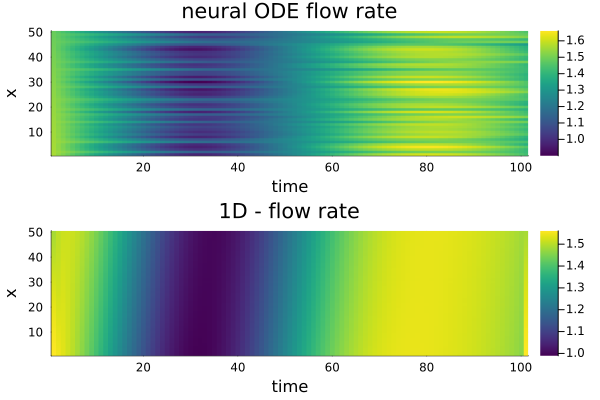

waveform: 2/5
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-71.50819
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 196.81163927339614
Iteration: 2 || Loss: 146.3243003847005
Iteration: 3 || Loss: 107.13848316045468
Iteration: 4 || Loss: 78.74713039094638
Iteration: 5 || Loss: 59.891637441390216
Iteration: 6 || Loss: 59.891637441390216
saving ADAM checkpoint...
Sum of params:-71.432755
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 59.891637441390216
Iteration: 2 || Loss: 45.859905030170474
Iteration: 3 || Loss: 37.29769773571356
Iteration: 4 || Loss: 32.502199011358016
Iteration: 5 || Loss: 30.10414075517223
Iteration: 6 || Loss: 29.301018164643413
Iteration: 7 || Loss: 29.62876912739999
Iteration: 8 || Loss: 30.678716438041384
Iteration: 9 || Loss: 31.988683179152222
Iteration: 10 || Loss: 32.82581247983336
Iteration: 11 || Loss: 32.877874231037794
Iteration: 12 || Loss: 32.16892585914077
Iteration: 13 || Loss: 31.05672416678006


Iteration: 185 || Loss: 19.776657740996974
Iteration: 186 || Loss: 19.75369116567167
Iteration: 187 || Loss: 19.732831558305246
Iteration: 188 || Loss: 19.71659389807101
Iteration: 189 || Loss: 19.690634679868516
Iteration: 190 || Loss: 19.669559734416815
Iteration: 191 || Loss: 19.64798752755175
Iteration: 192 || Loss: 19.63275556158036
Iteration: 193 || Loss: 19.606427320063318
Iteration: 194 || Loss: 19.586636754995745
Iteration: 195 || Loss: 19.56605344651951
Iteration: 196 || Loss: 19.545231153832777
Iteration: 197 || Loss: 19.524758753240175
Iteration: 198 || Loss: 19.508513305174652
Iteration: 199 || Loss: 19.484231734820995
Iteration: 200 || Loss: 19.46365801916692
Iteration: 201 || Loss: 19.448839236526016
Iteration: 202 || Loss: 19.42314428738986
Iteration: 203 || Loss: 19.403442081828985
Iteration: 204 || Loss: 19.38302487977075
Iteration: 205 || Loss: 19.367621961085668
Iteration: 206 || Loss: 19.34301720669717
Iteration: 207 || Loss: 19.323632004143107
Iteration: 208 || Lo

Iteration: 378 || Loss: 16.412331439716937
Iteration: 379 || Loss: 16.397900087674
Iteration: 380 || Loss: 16.386650552812064
Iteration: 381 || Loss: 16.369601035784523
Iteration: 382 || Loss: 16.35547453879363
Iteration: 383 || Loss: 16.34310319391362
Iteration: 384 || Loss: 16.327725766662894
Iteration: 385 || Loss: 16.316453409663218
Iteration: 386 || Loss: 16.299094734228742
Iteration: 387 || Loss: 16.284928665829483
Iteration: 388 || Loss: 16.2716459750072
Iteration: 389 || Loss: 16.257981693729658
Iteration: 390 || Loss: 16.245193732835475
Iteration: 391 || Loss: 16.230463952431965
Iteration: 392 || Loss: 16.216842262881062
Iteration: 393 || Loss: 16.202927294638698
Iteration: 394 || Loss: 16.189327414466092
Iteration: 395 || Loss: 16.175906119144123
Iteration: 396 || Loss: 16.16181900112187
Iteration: 397 || Loss: 16.14879404424474
Iteration: 398 || Loss: 16.13492390849523
Iteration: 399 || Loss: 16.121716986776722
Iteration: 400 || Loss: 16.107431340844983
Iteration: 401 || Los

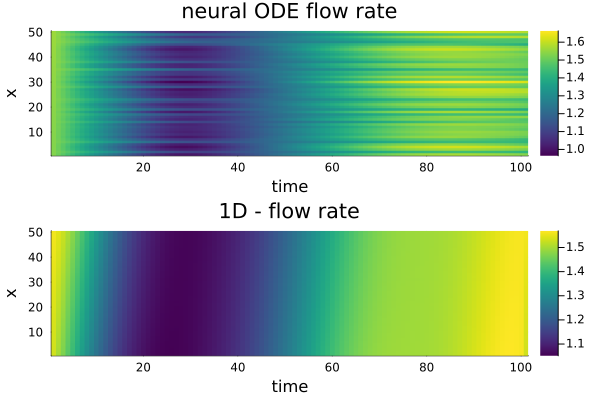

waveform: 3/5
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-72.57334
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 37.22332564046299
Iteration: 2 || Loss: 34.9024138727151
Iteration: 3 || Loss: 34.81445143976621
Iteration: 4 || Loss: 35.13183128786929
Iteration: 5 || Loss: 35.056807908420375
Iteration: 6 || Loss: 34.81445143976621
saving ADAM checkpoint...
Sum of params:-72.533035
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 34.81445143976621
Iteration: 2 || Loss: 34.82173155578084
Iteration: 3 || Loss: 34.46639793759115
Iteration: 4 || Loss: 33.97113484457543
Iteration: 5 || Loss: 34.01083027432602
Iteration: 6 || Loss: 33.99064195122361
Iteration: 7 || Loss: 33.707471229327346
Iteration: 8 || Loss: 33.45951705978733
Iteration: 9 || Loss: 33.413841679225015
Iteration: 10 || Loss: 33.40058738909285
Iteration: 11 || Loss: 33.256873009174555
Iteration: 12 || Loss: 33.07658747294532
Iteration: 13 || Loss: 32.98933322202849
Iteratio

Iteration: 186 || Loss: 27.62860395374752
Iteration: 187 || Loss: 27.604199570819148
Iteration: 188 || Loss: 27.57912028493901
Iteration: 189 || Loss: 27.55303721708204
Iteration: 190 || Loss: 27.52770172415186
Iteration: 191 || Loss: 27.50181456388874
Iteration: 192 || Loss: 27.47601177566678
Iteration: 193 || Loss: 27.452894191777272
Iteration: 194 || Loss: 27.426502763085374
Iteration: 195 || Loss: 27.39989898523906
Iteration: 196 || Loss: 27.377046902838057
Iteration: 197 || Loss: 27.350963409307948
Iteration: 198 || Loss: 27.324183276519015
Iteration: 199 || Loss: 27.299954917589886
Iteration: 200 || Loss: 27.272931951640306
Iteration: 201 || Loss: 27.24956565840222
Iteration: 202 || Loss: 27.224066854936716
Iteration: 203 || Loss: 27.198674241846653
Iteration: 204 || Loss: 27.174246948080487
Iteration: 205 || Loss: 27.149342886556468
Iteration: 206 || Loss: 27.124941428243684
Iteration: 207 || Loss: 27.100820271726633
Iteration: 208 || Loss: 27.075114497698383
Iteration: 209 || L

Iteration: 379 || Loss: 23.26907703611747
Iteration: 380 || Loss: 23.25149758821989
Iteration: 381 || Loss: 23.229936063494847
Iteration: 382 || Loss: 23.21010475794318
Iteration: 383 || Loss: 23.19159306725494
Iteration: 384 || Loss: 23.17193537181
Iteration: 385 || Loss: 23.152822367270794
Iteration: 386 || Loss: 23.131987352633566
Iteration: 387 || Loss: 23.11324822418279
Iteration: 388 || Loss: 23.093299446638632
Iteration: 389 || Loss: 23.074428624690093
Iteration: 390 || Loss: 23.055210473005467
Iteration: 391 || Loss: 23.03437207571583
Iteration: 392 || Loss: 23.016334521017427
Iteration: 393 || Loss: 22.997274949480573
Iteration: 394 || Loss: 22.97872853145735
Iteration: 395 || Loss: 22.95789778989045
Iteration: 396 || Loss: 22.93876999664093
Iteration: 397 || Loss: 22.91929791038154
Iteration: 398 || Loss: 22.900380728312626
Iteration: 399 || Loss: 22.88121951944491
Iteration: 400 || Loss: 22.86230161992728
Iteration: 401 || Loss: 22.84371456151475
Iteration: 402 || Loss: 22.8

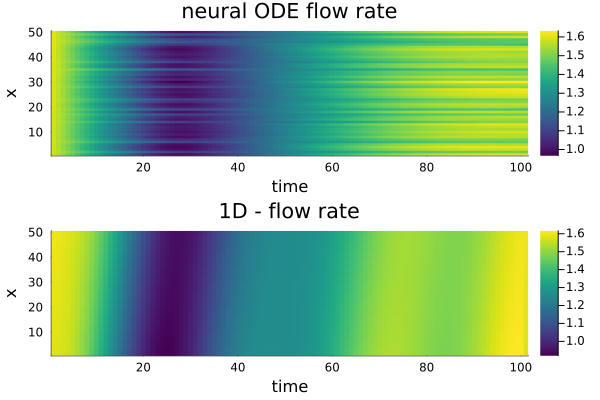

waveform: 4/5
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-81.22148
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 23.43904771894401
Iteration: 2 || Loss: 19.3510347839326
Iteration: 3 || Loss: 19.273091005810638
Iteration: 4 || Loss: 20.61042717853509
Iteration: 5 || Loss: 20.702149875768722
Iteration: 6 || Loss: 19.273091005810638
saving ADAM checkpoint...
Sum of params:-81.18648
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 19.273091005810638
Iteration: 2 || Loss: 19.653418548535655
Iteration: 3 || Loss: 19.206429315796434
Iteration: 4 || Loss: 18.775755559449646
Iteration: 5 || Loss: 19.072913231093878
Iteration: 6 || Loss: 19.119670945906687
Iteration: 7 || Loss: 18.820629907189836
Iteration: 8 || Loss: 18.67829829477016
Iteration: 9 || Loss: 18.793296281243876
Iteration: 10 || Loss: 18.872239644392184
Iteration: 11 || Loss: 18.75366448244007
Iteration: 12 || Loss: 18.594730373766872
Iteration: 13 || Loss: 18.578794201576684

Iteration: 185 || Loss: 16.15449595872552
Iteration: 186 || Loss: 16.146648212065937
Iteration: 187 || Loss: 16.13039383931028
Iteration: 188 || Loss: 16.117501172860557
Iteration: 189 || Loss: 16.112462995850308
Iteration: 190 || Loss: 16.097369498849112
Iteration: 191 || Loss: 16.078743816763225
Iteration: 192 || Loss: 16.072662354190236
Iteration: 193 || Loss: 16.063679278663205
Iteration: 194 || Loss: 16.058282198435343
Iteration: 195 || Loss: 16.03952615266708
Iteration: 196 || Loss: 16.029182311490956
Iteration: 197 || Loss: 16.02126444386484
Iteration: 198 || Loss: 16.0072403391192
Iteration: 199 || Loss: 15.99344305628273
Iteration: 200 || Loss: 15.980071811653383
Iteration: 201 || Loss: 15.966997849966612
Iteration: 202 || Loss: 15.957425158605457
Iteration: 203 || Loss: 15.95406781098686
Iteration: 204 || Loss: 15.93569178119233
Iteration: 205 || Loss: 15.934743058878361
Iteration: 206 || Loss: 15.91225887387745
Iteration: 207 || Loss: 15.89973624994929
Iteration: 208 || Loss

Iteration: 377 || Loss: 14.28434224466336
Iteration: 378 || Loss: 14.278868647942666
Iteration: 379 || Loss: 14.243774581711591
Iteration: 380 || Loss: 14.252760830969851
Iteration: 381 || Loss: 14.24853643214767
Iteration: 382 || Loss: 14.24103959082423
Iteration: 383 || Loss: 14.234277767016316
Iteration: 384 || Loss: 14.223543119903784
Iteration: 385 || Loss: 14.219769638707788
Iteration: 386 || Loss: 14.210992813670597
Iteration: 387 || Loss: 14.204684136168833
Iteration: 388 || Loss: 14.199757544071495
Iteration: 389 || Loss: 14.185906254252668
Iteration: 390 || Loss: 14.174915627112998
Iteration: 391 || Loss: 14.174489114463377
Iteration: 392 || Loss: 14.16915214408553
Iteration: 393 || Loss: 14.154417363332211
Iteration: 394 || Loss: 14.153823284138076
Iteration: 395 || Loss: 14.145163283697041
Iteration: 396 || Loss: 14.130557768016912
Iteration: 397 || Loss: 14.124342789433006
Iteration: 398 || Loss: 14.124670336932581
Iteration: 399 || Loss: 14.117627762962703
Iteration: 400 

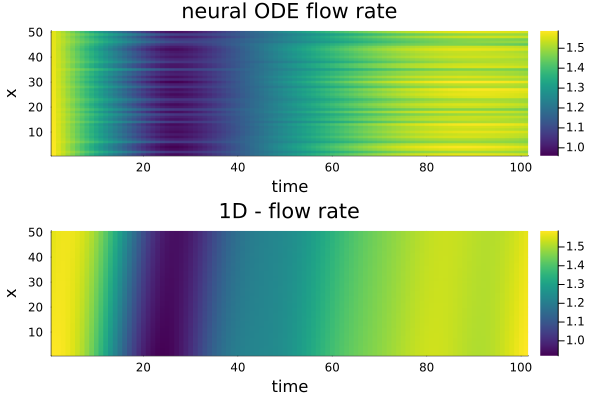

waveform: 5/5
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-86.063835
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 33.67119180233438
Iteration: 2 || Loss: 21.715239542923776
Iteration: 3 || Loss: 18.830198899190023
Iteration: 4 || Loss: 19.885320765658463
Iteration: 5 || Loss: 22.010351688268514
Iteration: 6 || Loss: 18.830198899190023
saving ADAM checkpoint...
Sum of params:-86.0168
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 18.830198899190023
Iteration: 2 || Loss: 22.477542666635664
Iteration: 3 || Loss: 18.452178193318293
Iteration: 4 || Loss: 18.95959102562578
Iteration: 5 || Loss: 19.4808859795992
Iteration: 6 || Loss: 18.46782740714509
Iteration: 7 || Loss: 17.253269135567564
Iteration: 8 || Loss: 16.88567817023804
Iteration: 9 || Loss: 17.27378805964868
Iteration: 10 || Loss: 17.528728865245068
Iteration: 11 || Loss: 17.251791804055166
Iteration: 12 || Loss: 16.682559365417312
Iteration: 13 || Loss: 16.364654308085854


Iteration: 185 || Loss: 14.75101825776704
Iteration: 186 || Loss: 14.740669031430558
Iteration: 187 || Loss: 14.730895038602892
Iteration: 188 || Loss: 14.731739826838963
Iteration: 189 || Loss: 14.71657007506351
Iteration: 190 || Loss: 14.712788320358943
Iteration: 191 || Loss: 14.718876891664824
Iteration: 192 || Loss: 14.731571279667936
Iteration: 193 || Loss: 14.694126142989035
Iteration: 194 || Loss: 14.69355771973591
Iteration: 195 || Loss: 14.687991910565977
Iteration: 196 || Loss: 14.675131833231424
Iteration: 197 || Loss: 14.669006214589945
Iteration: 198 || Loss: 14.6715253966497
Iteration: 199 || Loss: 14.657931937366865
Iteration: 200 || Loss: 14.654819148060941
Iteration: 201 || Loss: 14.649808245944003
Iteration: 202 || Loss: 14.640604392966077
Iteration: 203 || Loss: 14.630779639216346
Iteration: 204 || Loss: 14.642809979410197
Iteration: 205 || Loss: 14.645658745499041
Iteration: 206 || Loss: 14.628382306106577
Iteration: 207 || Loss: 14.611465608318424
Iteration: 208 |

Iteration: 377 || Loss: 13.575732089327595
Iteration: 378 || Loss: 13.574344170084812
Iteration: 379 || Loss: 13.568121252634361
Iteration: 380 || Loss: 13.562128289134392
Iteration: 381 || Loss: 13.555118900600789
Iteration: 382 || Loss: 13.54764356866924
Iteration: 383 || Loss: 13.538879954035934
Iteration: 384 || Loss: 13.537427234046959
Iteration: 385 || Loss: 13.531959413947927
Iteration: 386 || Loss: 13.526400364743873
Iteration: 387 || Loss: 13.513843499258666
Iteration: 388 || Loss: 13.50881987556929
Iteration: 389 || Loss: 13.505209125754252
Iteration: 390 || Loss: 13.499480969008614
Iteration: 391 || Loss: 13.490914454750225
Iteration: 392 || Loss: 13.48770379048675
Iteration: 393 || Loss: 13.4830307396311
Iteration: 394 || Loss: 13.48380896187114
Iteration: 395 || Loss: 13.475002475142366
Iteration: 396 || Loss: 13.47516749208306
Iteration: 397 || Loss: 13.462164497450416
Iteration: 398 || Loss: 13.452768227601654
Iteration: 399 || Loss: 13.447211647727617
Iteration: 400 || 

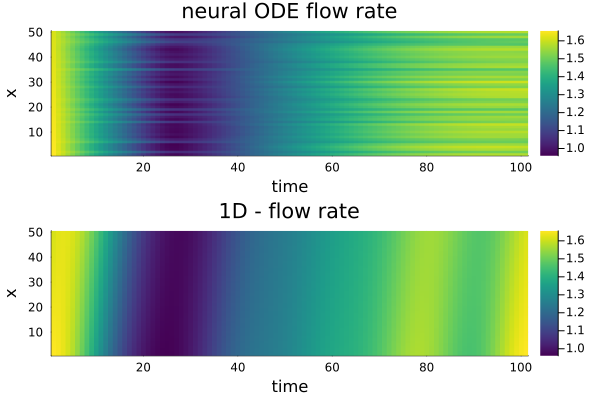

Epoch 2 mean loss loss:15.89051408238829
Start training epoch 3
time: 1/1
waveform: 1/5
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-91.44015
Changing learning rate to:0.0001
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 165.65887674155704
Iteration: 2 || Loss: 120.3567795904248
Iteration: 3 || Loss: 95.18580946932184
Iteration: 4 || Loss: 84.22873158723938
Iteration: 5 || Loss: 80.69409573428047
Iteration: 6 || Loss: 80.69409573428047
saving ADAM checkpoint...
Sum of params:-91.41428
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 80.69409573428047
Iteration: 2 || Loss: 71.06463236207868
Iteration: 3 || Loss: 62.10975754424129
Iteration: 4 || Loss: 54.208321413770825
Iteration: 5 || Loss: 47.80090726152291
Iteration: 6 || Loss: 43.422654264915856
Iteration: 7 || Loss: 41.30591559980812
Iteration: 8 || Loss: 41.26756475008726
Iteration: 9 || Loss: 42.679162136056156
Iteration: 10 || Loss: 44.592914935032375
Iteration: 11 || Loss: 

Iteration: 185 || Loss: 7.505962295581837
Iteration: 186 || Loss: 9.084784173887693
Iteration: 187 || Loss: 7.99705516363642
Iteration: 188 || Loss: 8.473038441475724
Iteration: 189 || Loss: 7.538854357218053
Iteration: 190 || Loss: 7.574333497145478
Iteration: 191 || Loss: 7.437582284426128
Iteration: 192 || Loss: 7.460904556099287
Iteration: 193 || Loss: 7.404528527873539
Iteration: 194 || Loss: 7.407014474607255
Iteration: 195 || Loss: 7.415221615886194
Iteration: 196 || Loss: 7.779624632020511
Iteration: 197 || Loss: 7.56932779281296
Iteration: 198 || Loss: 8.673841676687616
Iteration: 199 || Loss: 7.42531814074105
Iteration: 200 || Loss: 9.753271850157835
Iteration: 201 || Loss: 7.419579465649086
Iteration: 202 || Loss: 7.681041642908106
Iteration: 203 || Loss: 8.565070374467611
Iteration: 204 || Loss: 7.3976204491953865
Iteration: 205 || Loss: 7.910514413894061
Iteration: 206 || Loss: 8.165859738253989
Iteration: 207 || Loss: 7.3349382321073815
Iteration: 208 || Loss: 7.906590861

Iteration: 381 || Loss: 6.769921741649405
Iteration: 382 || Loss: 6.774716342123343
Iteration: 383 || Loss: 6.731367420891235
Iteration: 384 || Loss: 6.682648669211324
Iteration: 385 || Loss: 6.680347339690449
Iteration: 386 || Loss: 6.700943172430245
Iteration: 387 || Loss: 6.703151208572402
Iteration: 388 || Loss: 7.301586345482209
Iteration: 389 || Loss: 7.0001795560551585
Iteration: 390 || Loss: 7.095185728224336
Iteration: 391 || Loss: 6.667401415622347
Iteration: 392 || Loss: 7.117446457984656
Iteration: 393 || Loss: 6.880892033220465
Iteration: 394 || Loss: 6.6415483397433475
Iteration: 395 || Loss: 6.898574587344188
Iteration: 396 || Loss: 6.836259671721894
Iteration: 397 || Loss: 6.642998237998421
Iteration: 398 || Loss: 6.810289118654584
Iteration: 399 || Loss: 6.806575776321479
Iteration: 400 || Loss: 6.723498783949517
Iteration: 401 || Loss: 6.932273498293177
Iteration: 402 || Loss: 7.0772662673483495
Iteration: 403 || Loss: 6.658070657502028
Iteration: 404 || Loss: 6.67990

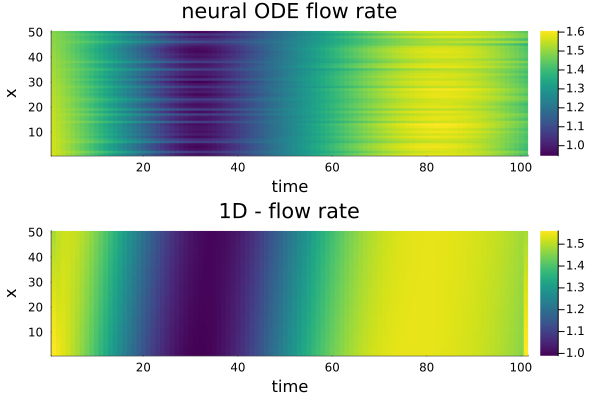

waveform: 2/5
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-90.50395
Changing learning rate to:0.0001
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 145.9244203167138
Iteration: 2 || Loss: 87.01760173670117
Iteration: 3 || Loss: 62.827764081283895
Iteration: 4 || Loss: 59.79487416121573
Iteration: 5 || Loss: 53.518998402570126
Iteration: 6 || Loss: 53.518998402570126
saving ADAM checkpoint...
Sum of params:-90.415726
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 53.518998402570126
Iteration: 2 || Loss: 36.66594147983872
Iteration: 3 || Loss: 39.69248976646668
Iteration: 4 || Loss: 34.951850755431316
Iteration: 5 || Loss: 28.248245580930032
Iteration: 6 || Loss: 24.051390231902168
Iteration: 7 || Loss: 23.330728669507785
Iteration: 8 || Loss: 23.258463689851016
Iteration: 9 || Loss: 21.960070484185774
Iteration: 10 || Loss: 19.596957631577645
Iteration: 11 || Loss: 17.67653614004726
Iteration: 12 || Loss: 17.245778919956138
Iterati

Iteration: 186 || Loss: 7.6394714486384485
Iteration: 187 || Loss: 7.615889193166096
Iteration: 188 || Loss: 7.672877698379571
Iteration: 189 || Loss: 7.618462290141285
Iteration: 190 || Loss: 7.599543742518264
Iteration: 191 || Loss: 7.674575239950272
Iteration: 192 || Loss: 7.627286669574507
Iteration: 193 || Loss: 7.611589120760723
Iteration: 194 || Loss: 7.552494676797796
Iteration: 195 || Loss: 7.5412569065778206
Iteration: 196 || Loss: 7.544109338528016
Iteration: 197 || Loss: 7.568790505633307
Iteration: 198 || Loss: 7.503330686413038
Iteration: 199 || Loss: 7.51365413897655
Iteration: 200 || Loss: 7.497714824653642
Iteration: 201 || Loss: 7.499197794779126
Iteration: 202 || Loss: 7.461845952822177
Iteration: 203 || Loss: 7.460317486943387
Iteration: 204 || Loss: 7.4767753761572155
Iteration: 205 || Loss: 7.445688955096534
Iteration: 206 || Loss: 7.439595898253932
Iteration: 207 || Loss: 7.433742200873631
Iteration: 208 || Loss: 7.42104077710837
Iteration: 209 || Loss: 7.4067467

Iteration: 382 || Loss: 6.177265534347587
Iteration: 383 || Loss: 6.178969946651966
Iteration: 384 || Loss: 6.165798176492032
Iteration: 385 || Loss: 6.1664207856242985
Iteration: 386 || Loss: 6.161402658301814
Iteration: 387 || Loss: 6.155117570450427
Iteration: 388 || Loss: 6.150962895012935
Iteration: 389 || Loss: 6.1397449902483325
Iteration: 390 || Loss: 6.141761763199575
Iteration: 391 || Loss: 6.134912307845106
Iteration: 392 || Loss: 6.130146968250624
Iteration: 393 || Loss: 6.123276704182273
Iteration: 394 || Loss: 6.122646636590146
Iteration: 395 || Loss: 6.113291741904244
Iteration: 396 || Loss: 6.0995490411972
Iteration: 397 || Loss: 6.104685546382713
Iteration: 398 || Loss: 6.08701867562362
Iteration: 399 || Loss: 6.089044855449737
Iteration: 400 || Loss: 6.08276931074963
Iteration: 401 || Loss: 6.084155161784998
Iteration: 402 || Loss: 6.075142764759613
Iteration: 403 || Loss: 6.075977133034437
Iteration: 404 || Loss: 6.063277584015701
Iteration: 405 || Loss: 6.0650101380

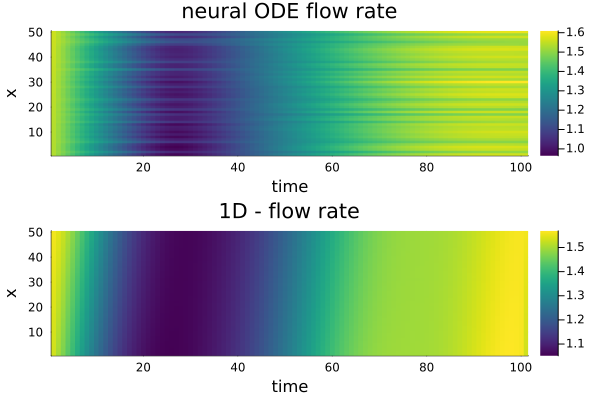

waveform: 3/5
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-89.98557
Changing learning rate to:0.0001
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 32.055612731885994
Iteration: 2 || Loss: 19.139673042123945
Iteration: 3 || Loss: 21.769205040480614
Iteration: 4 || Loss: 24.10859259106419
Iteration: 5 || Loss: 21.998303083423764
Iteration: 6 || Loss: 19.139673042123945
saving ADAM checkpoint...
Sum of params:-90.00395
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 19.139673042123945
Iteration: 2 || Loss: 23.51717640580945
Iteration: 3 || Loss: 18.038742659048694
Iteration: 4 || Loss: 18.539419842525213
Iteration: 5 || Loss: 19.5712943378539
Iteration: 6 || Loss: 18.020068803823467
Iteration: 7 || Loss: 16.49697794215766
Iteration: 8 || Loss: 16.608182821878387
Iteration: 9 || Loss: 17.28457941643808
Iteration: 10 || Loss: 17.174642590901463
Iteration: 11 || Loss: 16.57906424910863
Iteration: 12 || Loss: 16.09920103347797
Iteration:

Iteration: 184 || Loss: 14.805895011522765
Iteration: 185 || Loss: 14.810885253266273
Iteration: 186 || Loss: 14.800358979504894
Iteration: 187 || Loss: 14.796482571994037
Iteration: 188 || Loss: 14.792807836507627
Iteration: 189 || Loss: 14.814696517681124
Iteration: 190 || Loss: 14.791022570497649
Iteration: 191 || Loss: 14.78458179154453
Iteration: 192 || Loss: 14.784440197170746
Iteration: 193 || Loss: 14.769344904745266
Iteration: 194 || Loss: 14.753072158185926
Iteration: 195 || Loss: 14.776567419366993
Iteration: 196 || Loss: 14.778545621267616
Iteration: 197 || Loss: 14.765580956269737
Iteration: 198 || Loss: 14.76511311624211
Iteration: 199 || Loss: 14.743215444317848
Iteration: 200 || Loss: 14.756004477965437
Iteration: 201 || Loss: 14.73614992111749
Iteration: 202 || Loss: 14.741758841464714
Iteration: 203 || Loss: 14.73846153488393
Iteration: 204 || Loss: 14.729062874835046
Iteration: 205 || Loss: 14.732159698283994
Iteration: 206 || Loss: 14.721147629861225
Iteration: 207 

Iteration: 376 || Loss: 14.068107658295393
Iteration: 377 || Loss: 14.093271126413784
Iteration: 378 || Loss: 14.124651015054253
Iteration: 379 || Loss: 14.018535643784077
Iteration: 380 || Loss: 14.021350714266452
Iteration: 381 || Loss: 14.010895289210712
Iteration: 382 || Loss: 14.01093651807875
Iteration: 383 || Loss: 13.992210147659724
Iteration: 384 || Loss: 14.025630222901814
Iteration: 385 || Loss: 14.027232203992027
Iteration: 386 || Loss: 13.982461687435459
Iteration: 387 || Loss: 13.989693926341271
Iteration: 388 || Loss: 13.976377010433591
Iteration: 389 || Loss: 13.916610793251511
Iteration: 390 || Loss: 13.909471129200185
Iteration: 391 || Loss: 13.980664064096523
Iteration: 392 || Loss: 13.958791342761721
Iteration: 393 || Loss: 13.94344630046334
Iteration: 394 || Loss: 14.009780756999081
Iteration: 395 || Loss: 14.009327809961377
Iteration: 396 || Loss: 14.007282333880138
Iteration: 397 || Loss: 13.955072077566077
Iteration: 398 || Loss: 13.977911892641961
Iteration: 39

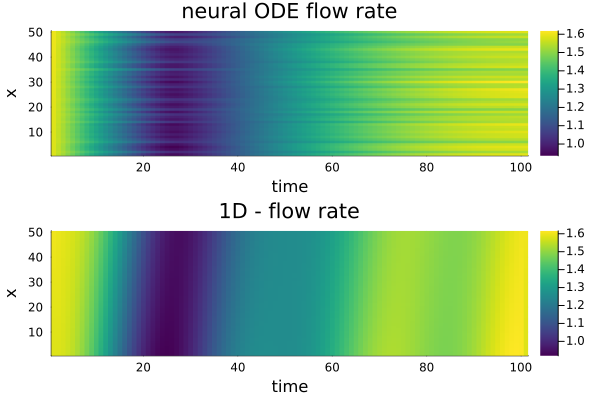

waveform: 4/5
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-91.17227
Changing learning rate to:0.0001
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 16.16305251064943
Iteration: 2 || Loss: 13.048751704841246
Iteration: 3 || Loss: 13.225475270859695
Iteration: 4 || Loss: 14.277452178728986
Iteration: 5 || Loss: 13.504358013768657
Iteration: 6 || Loss: 13.048751704841246
saving ADAM checkpoint...
Sum of params:-91.160065
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 13.048751704841246
Iteration: 2 || Loss: 18.95145814984736
Iteration: 3 || Loss: 12.912868898833485
Iteration: 4 || Loss: 13.778787869748541
Iteration: 5 || Loss: 15.712761286409155
Iteration: 6 || Loss: 14.337406824707806
Iteration: 7 || Loss: 12.629255663463018
Iteration: 8 || Loss: 12.47820164578042
Iteration: 9 || Loss: 13.731401366263999
Iteration: 10 || Loss: 14.042818208355452
Iteration: 11 || Loss: 13.102785031469395
Iteration: 12 || Loss: 12.295230963663887
Iter

Iteration: 184 || Loss: 11.245424065805954
Iteration: 185 || Loss: 11.28616751949271
Iteration: 186 || Loss: 11.26672436637649
Iteration: 187 || Loss: 11.32968102739171
Iteration: 188 || Loss: 11.267374387743708
Iteration: 189 || Loss: 11.26299809125521
Iteration: 190 || Loss: 11.25450072103278
Iteration: 191 || Loss: 11.211261311476838
Iteration: 192 || Loss: 11.249716338217008
Iteration: 193 || Loss: 11.233371269614352
Iteration: 194 || Loss: 11.21004257173264
Iteration: 195 || Loss: 11.252576158045649
Iteration: 196 || Loss: 11.194502188443458
Iteration: 197 || Loss: 11.279019794305698
Iteration: 198 || Loss: 11.22739902940337
Iteration: 199 || Loss: 11.190050900511885
Iteration: 200 || Loss: 11.263044855234806
Iteration: 201 || Loss: 11.18597362315959
Iteration: 202 || Loss: 11.104466880556135
Iteration: 203 || Loss: 11.247835272262577
Iteration: 204 || Loss: 11.231256284949886
Iteration: 205 || Loss: 11.202579445033372
Iteration: 206 || Loss: 11.195876975437102
Iteration: 207 || L

Iteration: 376 || Loss: 10.616517768265673
Iteration: 377 || Loss: 10.790306556656068
Iteration: 378 || Loss: 10.688380283872464
Iteration: 379 || Loss: 10.69041279237493
Iteration: 380 || Loss: 10.688883363264507
Iteration: 381 || Loss: 10.679592265759503
Iteration: 382 || Loss: 10.69555472959949
Iteration: 383 || Loss: 10.844525335981507
Iteration: 384 || Loss: 10.827470545094066
Iteration: 385 || Loss: 10.667836502850557
Iteration: 386 || Loss: 10.79438677405677
Iteration: 387 || Loss: 10.66437109656505
Iteration: 388 || Loss: 10.656873576432215
Iteration: 389 || Loss: 10.677216154036032
Iteration: 390 || Loss: 10.7232668352197
Iteration: 391 || Loss: 10.69912521284945
Iteration: 392 || Loss: 10.737070095354703
Iteration: 393 || Loss: 10.83375847185099
Iteration: 394 || Loss: 10.691305906595298
Iteration: 395 || Loss: 10.74986845749918
Iteration: 396 || Loss: 10.663733786118968
Iteration: 397 || Loss: 10.530382363569565
Iteration: 398 || Loss: 10.665244320166059
Iteration: 399 || Lo

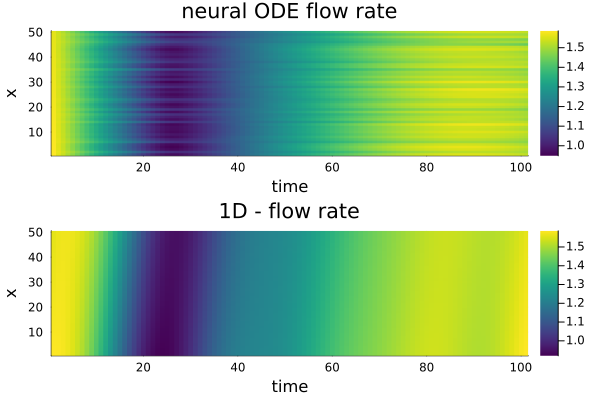

waveform: 5/5
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-91.96652
Changing learning rate to:0.0001
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 30.812215006767538
Iteration: 2 || Loss: 21.35088045242828
Iteration: 3 || Loss: 19.437344842639728
Iteration: 4 || Loss: 21.443994334491215
Iteration: 5 || Loss: 22.122535659684395
Iteration: 6 || Loss: 19.437344842639728
saving ADAM checkpoint...
Sum of params:-91.99765
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 19.437344842639728
Iteration: 2 || Loss: 25.135402338489776
Iteration: 3 || Loss: 16.568851266824584
Iteration: 4 || Loss: 17.22491487056792
Iteration: 5 || Loss: 20.546873526986182
Iteration: 6 || Loss: 16.696983623675656
Iteration: 7 || Loss: 14.2260033741319
Iteration: 8 || Loss: 15.722465311624433
Iteration: 9 || Loss: 16.622193524425953
Iteration: 10 || Loss: 15.793280949750596
Iteration: 11 || Loss: 13.832239382963461
Iteration: 12 || Loss: 13.24003368724932
Iterati

Iteration: 184 || Loss: 11.757835758157693
Iteration: 185 || Loss: 11.757576146113545
Iteration: 186 || Loss: 11.753539829368524
Iteration: 187 || Loss: 11.74345080151009
Iteration: 188 || Loss: 11.7427283694111
Iteration: 189 || Loss: 11.735113254480162
Iteration: 190 || Loss: 11.74626887920379
Iteration: 191 || Loss: 11.74124748685362
Iteration: 192 || Loss: 11.732924670097049
Iteration: 193 || Loss: 11.73133810543801
Iteration: 194 || Loss: 11.731986498670416
Iteration: 195 || Loss: 11.729874157148114
Iteration: 196 || Loss: 11.726171716584975
Iteration: 197 || Loss: 11.724864873453797
Iteration: 198 || Loss: 11.72126718118948
Iteration: 199 || Loss: 11.717334126448627
Iteration: 200 || Loss: 11.709936589430306
Iteration: 201 || Loss: 11.712174062343035
Iteration: 202 || Loss: 11.711877004607985
Iteration: 203 || Loss: 11.703789738675905
Iteration: 204 || Loss: 11.706519675806149
Iteration: 205 || Loss: 11.703875453291097
Iteration: 206 || Loss: 11.69312068345181
Iteration: 207 || L

Iteration: 376 || Loss: 11.321620946678154
Iteration: 377 || Loss: 11.324539599874932
Iteration: 378 || Loss: 11.322491007800883
Iteration: 379 || Loss: 11.321658948382805
Iteration: 380 || Loss: 11.316412256677928
Iteration: 381 || Loss: 11.315593520923166
Iteration: 382 || Loss: 11.313092781546857
Iteration: 383 || Loss: 11.312300151670096
Iteration: 384 || Loss: 11.310241781252788
Iteration: 385 || Loss: 11.306755798144465
Iteration: 386 || Loss: 11.305841191078795
Iteration: 387 || Loss: 11.303841584878711
Iteration: 388 || Loss: 11.297746258396515
Iteration: 389 || Loss: 11.30111912331435
Iteration: 390 || Loss: 11.298720339876628
Iteration: 391 || Loss: 11.295709864630478
Iteration: 392 || Loss: 11.29441740699231
Iteration: 393 || Loss: 11.292278251577539
Iteration: 394 || Loss: 11.2906289051059
Iteration: 395 || Loss: 11.28755838457374
Iteration: 396 || Loss: 11.28649896354028
Iteration: 397 || Loss: 11.284344996823544
Iteration: 398 || Loss: 11.276953625686982
Iteration: 399 ||

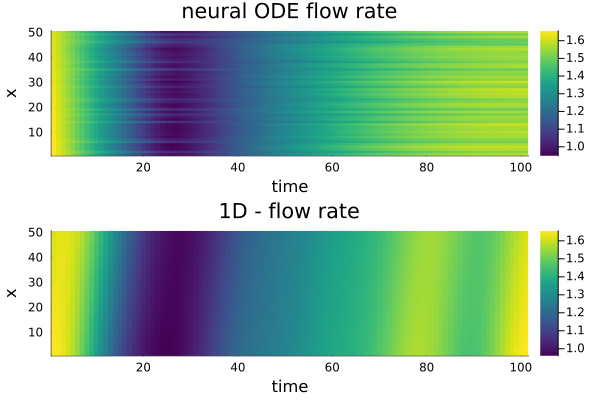

Epoch 3 mean loss loss:9.4114845607909
Start training epoch 4
time: 1/1
waveform: 1/5
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-94.346924
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 206.0118029437014
Iteration: 2 || Loss: 125.13065324172732
Iteration: 3 || Loss: 86.44204245346742
Iteration: 4 || Loss: 77.42089239599531
Iteration: 5 || Loss: 81.46352787549014
Iteration: 6 || Loss: 77.42089239599531
saving ADAM checkpoint...
Sum of params:-94.33709
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 77.42089239599531
Iteration: 2 || Loss: 69.80569894365946
Iteration: 3 || Loss: 62.85607429613192
Iteration: 4 || Loss: 56.30579401234646
Iteration: 5 || Loss: 50.681201813153
Iteration: 6 || Loss: 46.688874471441196
Iteration: 7 || Loss: 44.87719611682189
Iteration: 8 || Loss: 45.30726617297802
Iteration: 9 || Loss: 46.96780479723155
Iteration: 10 || Loss: 48.713999397927985
Iteration: 11 || Loss: 49.501770499039196
Iteration: 12 || Lo

Iteration: 186 || Loss: 8.166591957722352
Iteration: 187 || Loss: 6.961719024617512
Iteration: 188 || Loss: 7.308059055277122
Iteration: 189 || Loss: 7.718239348364709
Iteration: 190 || Loss: 6.988333516866896
Iteration: 191 || Loss: 6.819930413454373
Iteration: 192 || Loss: 7.254410567227084
Iteration: 193 || Loss: 7.306312235794597
Iteration: 194 || Loss: 6.890850663152319
Iteration: 195 || Loss: 6.785801768244211
Iteration: 196 || Loss: 7.035396327696539
Iteration: 197 || Loss: 6.899355861060151
Iteration: 198 || Loss: 6.7541628418082995
Iteration: 199 || Loss: 6.983879727320298
Iteration: 200 || Loss: 6.852971954816871
Iteration: 201 || Loss: 6.990011851281189
Iteration: 202 || Loss: 6.626446101520188
Iteration: 203 || Loss: 6.883794992004731
Iteration: 204 || Loss: 7.160363474778721
Iteration: 205 || Loss: 8.26582663698356
Iteration: 206 || Loss: 6.5733531344457505
Iteration: 207 || Loss: 11.85142979099826
Iteration: 208 || Loss: 9.160200143518685
Iteration: 209 || Loss: 6.8769671

Iteration: 381 || Loss: 6.080029492864165
Iteration: 382 || Loss: 7.173531194714246
Iteration: 383 || Loss: 6.041013620238892
Iteration: 384 || Loss: 6.3103277491858645
Iteration: 385 || Loss: 6.619973068311856
Iteration: 386 || Loss: 6.16220992860317
Iteration: 387 || Loss: 6.773231932643931
Iteration: 388 || Loss: 16.651655643587954
Iteration: 389 || Loss: 8.002676527778746
Iteration: 390 || Loss: 11.729826010106155
Iteration: 391 || Loss: 6.656386717447982
Iteration: 392 || Loss: 6.259169567227716
Iteration: 393 || Loss: 6.45607491082228
Iteration: 394 || Loss: 7.476084967154757
Iteration: 395 || Loss: 11.534253527059352
Iteration: 396 || Loss: 6.4501090062006
Iteration: 397 || Loss: 8.474756871068791
Iteration: 398 || Loss: 8.16041763445574
Iteration: 399 || Loss: 6.577768277822401
Iteration: 400 || Loss: 6.5291540467239315
Iteration: 401 || Loss: 8.084889030103664
Iteration: 402 || Loss: 25.12414374880861
Iteration: 403 || Loss: 7.995086386523745
Iteration: 404 || Loss: 14.5159249

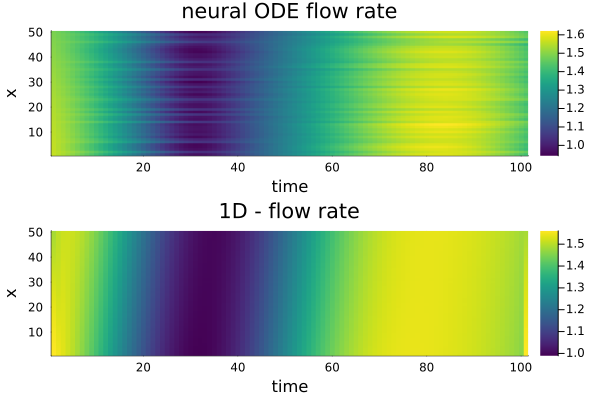

waveform: 2/5
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-93.41111
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 123.40265836953787
Iteration: 2 || Loss: 100.1627089505997
Iteration: 3 || Loss: 71.7590425769374
Iteration: 4 || Loss: 51.118074764805414
Iteration: 5 || Loss: 43.7746616998854
Iteration: 6 || Loss: 43.7746616998854
saving ADAM checkpoint...
Sum of params:-93.373634
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 43.7746616998854
Iteration: 2 || Loss: 38.60442448339383
Iteration: 3 || Loss: 29.641664110773082
Iteration: 4 || Loss: 25.852563729155705
Iteration: 5 || Loss: 27.249745772196032
Iteration: 6 || Loss: 23.8054106044057
Iteration: 7 || Loss: 20.707267949713668
Iteration: 8 || Loss: 19.648979147981166
Iteration: 9 || Loss: 19.43521703961433
Iteration: 10 || Loss: 18.297731239215008
Iteration: 11 || Loss: 16.68703506166858
Iteration: 12 || Loss: 15.942097165460043
Iteration: 13 || Loss: 16.275145435496007
Iterat

Iteration: 187 || Loss: 6.697390821670443
Iteration: 188 || Loss: 6.579361975146402
Iteration: 189 || Loss: 6.597230380200095
Iteration: 190 || Loss: 6.6027266207814055
Iteration: 191 || Loss: 6.543084048541653
Iteration: 192 || Loss: 6.55251570294377
Iteration: 193 || Loss: 6.60637529585185
Iteration: 194 || Loss: 6.612292610350542
Iteration: 195 || Loss: 6.54079009487832
Iteration: 196 || Loss: 6.544358237772657
Iteration: 197 || Loss: 6.5870411852652655
Iteration: 198 || Loss: 6.564842662080627
Iteration: 199 || Loss: 6.496178356960673
Iteration: 200 || Loss: 6.486063307565193
Iteration: 201 || Loss: 6.542824107497955
Iteration: 202 || Loss: 6.639422735205876
Iteration: 203 || Loss: 6.44688735794717
Iteration: 204 || Loss: 6.5115561056112945
Iteration: 205 || Loss: 6.4753999952934915
Iteration: 206 || Loss: 6.510275369215143
Iteration: 207 || Loss: 6.478691512275692
Iteration: 208 || Loss: 6.453923189279893
Iteration: 209 || Loss: 6.3879478438171935
Iteration: 210 || Loss: 6.4312853

Iteration: 382 || Loss: 5.3255826334771665
Iteration: 383 || Loss: 5.361983757246707
Iteration: 384 || Loss: 5.363351775366672
Iteration: 385 || Loss: 5.319020629127301
Iteration: 386 || Loss: 5.30788823584968
Iteration: 387 || Loss: 5.303662979991934
Iteration: 388 || Loss: 5.299222101257233
Iteration: 389 || Loss: 5.322558039742769
Iteration: 390 || Loss: 5.291226793796786
Iteration: 391 || Loss: 5.27301556077094
Iteration: 392 || Loss: 5.280993623189617
Iteration: 393 || Loss: 5.294599293360152
Iteration: 394 || Loss: 5.2990140181118015
Iteration: 395 || Loss: 5.2539520244719435
Iteration: 396 || Loss: 5.278948508775796
Iteration: 397 || Loss: 5.294442871987277
Iteration: 398 || Loss: 5.285549223402165
Iteration: 399 || Loss: 5.273963867533697
Iteration: 400 || Loss: 5.297187650690068
Iteration: 401 || Loss: 5.27189229915351
Iteration: 402 || Loss: 5.2589506350461654
Iteration: 403 || Loss: 5.2187317641783055
Iteration: 404 || Loss: 5.2075340827735275
Iteration: 405 || Loss: 5.26550

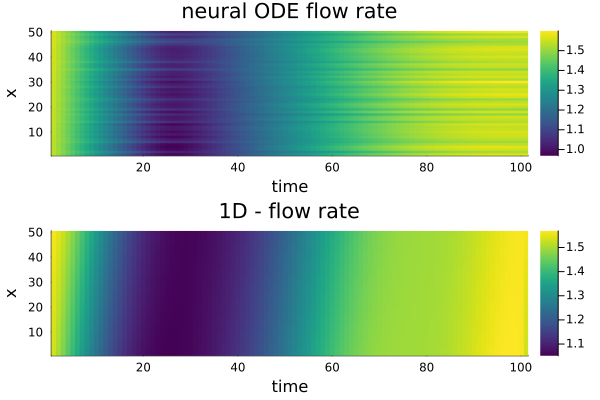

waveform: 3/5
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-92.85302
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 35.91147786336331
Iteration: 2 || Loss: 17.4718045453887
Iteration: 3 || Loss: 22.63132843349523
Iteration: 4 || Loss: 25.209651190651268
Iteration: 5 || Loss: 21.194346530495054
Iteration: 6 || Loss: 17.4718045453887
saving ADAM checkpoint...
Sum of params:-92.87083
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 17.4718045453887
Iteration: 2 || Loss: 15.843394587087268
Iteration: 3 || Loss: 15.884107855767189
Iteration: 4 || Loss: 15.113332589318938
Iteration: 5 || Loss: 14.648979668885529
Iteration: 6 || Loss: 14.705682940805755
Iteration: 7 || Loss: 14.801620100183325
Iteration: 8 || Loss: 14.454169507450985
Iteration: 9 || Loss: 14.136282259544704
Iteration: 10 || Loss: 13.982304706569623
Iteration: 11 || Loss: 14.083359033920484
Iteration: 12 || Loss: 14.090855819016342
Iteration: 13 || Loss: 14.016163859002596
I

Iteration: 185 || Loss: 12.563827197583464
Iteration: 186 || Loss: 12.559837250465518
Iteration: 187 || Loss: 12.531029057608603
Iteration: 188 || Loss: 12.54258727935856
Iteration: 189 || Loss: 12.417679097699049
Iteration: 190 || Loss: 12.523314943471423
Iteration: 191 || Loss: 12.504156170285691
Iteration: 192 || Loss: 12.54678664072706
Iteration: 193 || Loss: 12.545819435513076
Iteration: 194 || Loss: 12.521490237376952
Iteration: 195 || Loss: 12.611104775048318
Iteration: 196 || Loss: 12.492525906125135
Iteration: 197 || Loss: 12.570859084543255
Iteration: 198 || Loss: 12.484205964216963
Iteration: 199 || Loss: 12.561070978089163
Iteration: 200 || Loss: 12.476267364499853
Iteration: 201 || Loss: 12.553497130022416
Iteration: 202 || Loss: 12.478035548905515
Iteration: 203 || Loss: 12.43890008126422
Iteration: 204 || Loss: 12.48045608609574
Iteration: 205 || Loss: 12.371793226438864
Iteration: 206 || Loss: 12.504310899805072
Iteration: 207 || Loss: 12.46286343900349
Iteration: 208 |

Iteration: 377 || Loss: 12.023889096039971
Iteration: 378 || Loss: 11.923101498667073
Iteration: 379 || Loss: 11.987809380341115
Iteration: 380 || Loss: 11.99281674824431
Iteration: 381 || Loss: 11.959015365864667
Iteration: 382 || Loss: 11.899224127299323
Iteration: 383 || Loss: 12.31790969831157
Iteration: 384 || Loss: 11.997356701851967
Iteration: 385 || Loss: 12.23790968238552
Iteration: 386 || Loss: 12.071312159028713
Iteration: 387 || Loss: 12.041276315939532
Iteration: 388 || Loss: 12.101851039463167
Iteration: 389 || Loss: 11.964407951392532
Iteration: 390 || Loss: 12.115403449076693
Iteration: 391 || Loss: 11.975858685680196
Iteration: 392 || Loss: 12.036026454518314
Iteration: 393 || Loss: 11.945656656515144
Iteration: 394 || Loss: 11.992054778638096
Iteration: 395 || Loss: 11.867749962300532
Iteration: 396 || Loss: 11.906483123231649
Iteration: 397 || Loss: 11.924657630634876
Iteration: 398 || Loss: 11.996965739872127
Iteration: 399 || Loss: 11.964702522488803
Iteration: 400

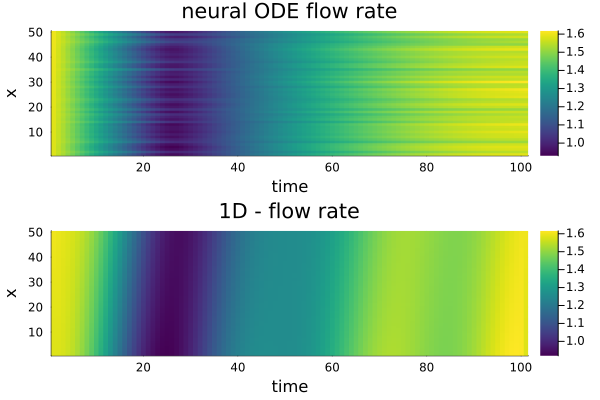

waveform: 4/5
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-93.962234
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 14.121622725080165
Iteration: 2 || Loss: 18.248552646451017
Iteration: 3 || Loss: 10.812140577326879
Iteration: 4 || Loss: 13.457633389973333
Iteration: 5 || Loss: 14.1410112686161
Iteration: 6 || Loss: 10.812140577326879
saving ADAM checkpoint...
Sum of params:-93.96624
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 10.812140577326879
Iteration: 2 || Loss: 27.09875709795937
Iteration: 3 || Loss: 11.674447611539838
Iteration: 4 || Loss: 14.240485519735543
Iteration: 5 || Loss: 19.713059290527482
Iteration: 6 || Loss: 16.876123549551018
Iteration: 7 || Loss: 12.25276856473269
Iteration: 8 || Loss: 10.720513027556319
Iteration: 9 || Loss: 13.304733634527949
Iteration: 10 || Loss: 14.093316677341274
Iteration: 11 || Loss: 14.692275857303148
Iteration: 12 || Loss: 12.22432487139879
Iteration: 13 || Loss: 10.6600335071995

Iteration: 186 || Loss: 9.584573117881362
Iteration: 187 || Loss: 9.603006970492075
Iteration: 188 || Loss: 9.67627520727492
Iteration: 189 || Loss: 9.677000069210067
Iteration: 190 || Loss: 9.582484136113413
Iteration: 191 || Loss: 9.649326398923977
Iteration: 192 || Loss: 9.683389299334548
Iteration: 193 || Loss: 9.672695591729012
Iteration: 194 || Loss: 9.685526084471647
Iteration: 195 || Loss: 9.62517618675076
Iteration: 196 || Loss: 9.641318405013394
Iteration: 197 || Loss: 9.695657154499957
Iteration: 198 || Loss: 9.549334213636689
Iteration: 199 || Loss: 9.623896354714221
Iteration: 200 || Loss: 9.689659212646914
Iteration: 201 || Loss: 9.702666672875452
Iteration: 202 || Loss: 9.611682210448574
Iteration: 203 || Loss: 9.615909587335713
Iteration: 204 || Loss: 9.561155006240245
Iteration: 205 || Loss: 9.534836383488285
Iteration: 206 || Loss: 9.611433628171163
Iteration: 207 || Loss: 9.613345894366223
Iteration: 208 || Loss: 9.626049862323887
Iteration: 209 || Loss: 9.6127437832

Iteration: 382 || Loss: 9.354989711827132
Iteration: 383 || Loss: 10.43758567729942
Iteration: 384 || Loss: 10.061974267303144
Iteration: 385 || Loss: 9.447825041063803
Iteration: 386 || Loss: 9.765861095124386
Iteration: 387 || Loss: 9.954982156805409
Iteration: 388 || Loss: 10.442174708342407
Iteration: 389 || Loss: 9.393280560404373
Iteration: 390 || Loss: 10.599210952060698
Iteration: 391 || Loss: 9.927001505507576
Iteration: 392 || Loss: 9.53145412029665
Iteration: 393 || Loss: 10.388360261042477
Iteration: 394 || Loss: 9.587965622721311
Iteration: 395 || Loss: 9.575765429158299
Iteration: 396 || Loss: 10.134158275386733
Iteration: 397 || Loss: 9.342212107846343
Iteration: 398 || Loss: 9.694761808021696
Iteration: 399 || Loss: 9.772106071642341
Iteration: 400 || Loss: 9.286220389151392
Iteration: 401 || Loss: 9.591143690033057
Iteration: 402 || Loss: 9.83511039065088
Iteration: 403 || Loss: 9.237271908902724
Iteration: 404 || Loss: 9.751624739304066
Iteration: 405 || Loss: 9.56676

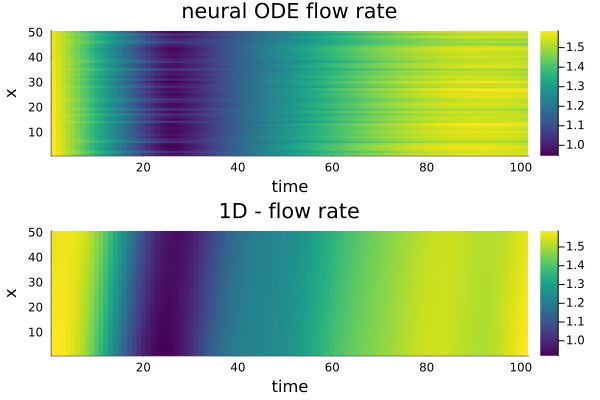

waveform: 5/5
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-94.42442
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 28.63808313374709
Iteration: 2 || Loss: 21.006700606972203
Iteration: 3 || Loss: 22.372109803282985
Iteration: 4 || Loss: 21.045528287288803
Iteration: 5 || Loss: 18.85292808488336
Iteration: 6 || Loss: 18.85292808488336
saving ADAM checkpoint...
Sum of params:-94.44864
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 18.85292808488336
Iteration: 2 || Loss: 16.52356115061324
Iteration: 3 || Loss: 17.305242616146117
Iteration: 4 || Loss: 15.300992395132038
Iteration: 5 || Loss: 15.165258167406122
Iteration: 6 || Loss: 14.295178646660492
Iteration: 7 || Loss: 13.017697808149583
Iteration: 8 || Loss: 13.182858146693928
Iteration: 9 || Loss: 14.229020201347286
Iteration: 10 || Loss: 12.732666856182998
Iteration: 11 || Loss: 13.415178639868365
Iteration: 12 || Loss: 13.00565189422121
Iteration: 13 || Loss: 12.244205870360348

Iteration: 184 || Loss: 10.67223492271594
Iteration: 185 || Loss: 10.90213823976445
Iteration: 186 || Loss: 10.686712568153235
Iteration: 187 || Loss: 10.750650259246463
Iteration: 188 || Loss: 10.867396567238856
Iteration: 189 || Loss: 10.72784460512045
Iteration: 190 || Loss: 10.780613571045375
Iteration: 191 || Loss: 10.798828097795553
Iteration: 192 || Loss: 10.684043202686322
Iteration: 193 || Loss: 10.702671557502844
Iteration: 194 || Loss: 10.81610334142119
Iteration: 195 || Loss: 10.655997557417797
Iteration: 196 || Loss: 10.73720142881436
Iteration: 197 || Loss: 10.811511765326642
Iteration: 198 || Loss: 10.649008245187243
Iteration: 199 || Loss: 10.819806642952939
Iteration: 200 || Loss: 10.715946123058892
Iteration: 201 || Loss: 10.739965331257977
Iteration: 202 || Loss: 10.662981044367852
Iteration: 203 || Loss: 10.631609708024419
Iteration: 204 || Loss: 10.679653549486197
Iteration: 205 || Loss: 10.82349247348261
Iteration: 206 || Loss: 10.618620066121258
Iteration: 207 ||

Iteration: 376 || Loss: 10.284287877472424
Iteration: 377 || Loss: 10.260289088375169
Iteration: 378 || Loss: 10.313890421340265
Iteration: 379 || Loss: 10.257995653679512
Iteration: 380 || Loss: 10.409425335783146
Iteration: 381 || Loss: 10.273256869389973
Iteration: 382 || Loss: 10.332900443723979
Iteration: 383 || Loss: 10.283974607580518
Iteration: 384 || Loss: 10.224931837916845
Iteration: 385 || Loss: 10.432832660994487
Iteration: 386 || Loss: 10.256757723337648
Iteration: 387 || Loss: 10.359051188602415
Iteration: 388 || Loss: 10.405235810476416
Iteration: 389 || Loss: 10.33729888738069
Iteration: 390 || Loss: 10.308072630362627
Iteration: 391 || Loss: 10.24979301292581
Iteration: 392 || Loss: 10.328071443048902
Iteration: 393 || Loss: 10.314287938944084
Iteration: 394 || Loss: 10.225663634928964
Iteration: 395 || Loss: 10.360298711657531
Iteration: 396 || Loss: 10.214489483565906
Iteration: 397 || Loss: 10.273762366230157
Iteration: 398 || Loss: 10.271006306942958
Iteration: 39

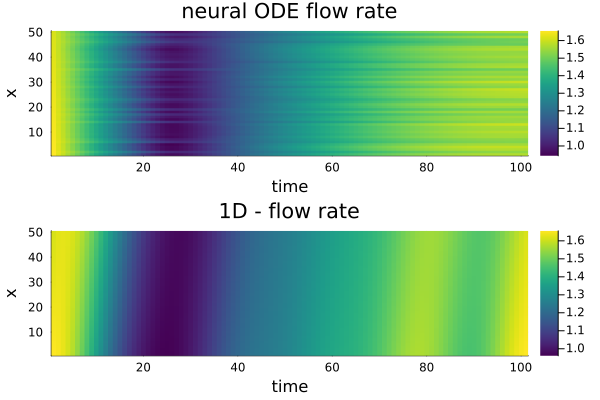

Epoch 4 mean loss loss:8.317822198318218
Start training epoch 5
time: 1/1
waveform: 1/5
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-96.70942
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 225.45919478029825
Iteration: 2 || Loss: 125.17429583597921
Iteration: 3 || Loss: 79.09799477469014
Iteration: 4 || Loss: 71.86078693664695
Iteration: 5 || Loss: 80.37270929930847
Iteration: 6 || Loss: 71.86078693664695
saving ADAM checkpoint...
Sum of params:-96.69985
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 71.86078693664695
Iteration: 2 || Loss: 75.40771304298315
Iteration: 3 || Loss: 64.63379640018712
Iteration: 4 || Loss: 63.33278684851179
Iteration: 5 || Loss: 62.66634054177638
Iteration: 6 || Loss: 58.125118944066756
Iteration: 7 || Loss: 53.23895399901711
Iteration: 8 || Loss: 51.836628788791344
Iteration: 9 || Loss: 51.293320960980445
Iteration: 10 || Loss: 48.38092757546133
Iteration: 11 || Loss: 45.03752247594364
Iteration: 12 |

Iteration: 185 || Loss: 20.847877654008993
Iteration: 186 || Loss: 13.948235516931991
Iteration: 187 || Loss: 8.030590004671696
Iteration: 188 || Loss: 8.775728820517092
Iteration: 189 || Loss: 13.620576608998622
Iteration: 190 || Loss: 15.610738376398768
Iteration: 191 || Loss: 10.67685447140034
Iteration: 192 || Loss: 7.648416914291569
Iteration: 193 || Loss: 8.508884176544147
Iteration: 194 || Loss: 11.187812639060335
Iteration: 195 || Loss: 12.784458419048553
Iteration: 196 || Loss: 9.053404493552565
Iteration: 197 || Loss: 7.287567214369815
Iteration: 198 || Loss: 8.258126569837444
Iteration: 199 || Loss: 9.535226784008966
Iteration: 200 || Loss: 10.104595368008972
Iteration: 201 || Loss: 8.60346213641219
Iteration: 202 || Loss: 7.155151657422621
Iteration: 203 || Loss: 7.700656619504668
Iteration: 204 || Loss: 9.77227806770796
Iteration: 205 || Loss: 26.32668739845796
Iteration: 206 || Loss: 7.318323261373066
Iteration: 207 || Loss: 11.306302071831643
Iteration: 208 || Loss: 13.2

Iteration: 380 || Loss: 9.032559290233568
Iteration: 381 || Loss: 9.18994257285286
Iteration: 382 || Loss: 7.99728562500497
Iteration: 383 || Loss: 6.422213308240728
Iteration: 384 || Loss: 6.440472043214077
Iteration: 385 || Loss: 6.608431701004466
Iteration: 386 || Loss: 7.987984874823021
Iteration: 387 || Loss: 7.9529268932930295
Iteration: 388 || Loss: 7.334981467504143
Iteration: 389 || Loss: 6.201325598085898
Iteration: 390 || Loss: 6.240052724403208
Iteration: 391 || Loss: 6.233922515667057
Iteration: 392 || Loss: 9.073423453032905
Iteration: 393 || Loss: 6.568636585745205
Iteration: 394 || Loss: 6.663840879308127
Iteration: 395 || Loss: 8.298120385192652
Iteration: 396 || Loss: 7.323048204792331
Iteration: 397 || Loss: 6.68993714957635
Iteration: 398 || Loss: 7.535167939036033
Iteration: 399 || Loss: 6.201186063251277
Iteration: 400 || Loss: 6.985439123768453
Iteration: 401 || Loss: 6.132542810434311
Iteration: 402 || Loss: 6.084998142851035
Iteration: 403 || Loss: 6.0650831434

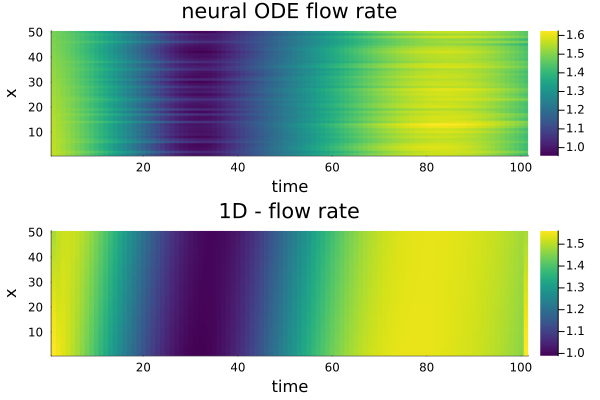

waveform: 2/5
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-95.88714
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 170.78835906346433
Iteration: 2 || Loss: 112.1036040615619
Iteration: 3 || Loss: 85.46636304893595
Iteration: 4 || Loss: 72.67772785146536
Iteration: 5 || Loss: 61.83431208006006
Iteration: 6 || Loss: 61.83431208006006
saving ADAM checkpoint...
Sum of params:-95.86193
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 61.83431208006006
Iteration: 2 || Loss: 40.80128955292294
Iteration: 3 || Loss: 35.42363891395122
Iteration: 4 || Loss: 26.904425182631268
Iteration: 5 || Loss: 21.62242206575301
Iteration: 6 || Loss: 23.79781583514951
Iteration: 7 || Loss: 25.218947756730117
Iteration: 8 || Loss: 24.880928339265537
Iteration: 9 || Loss: 22.83407323411726
Iteration: 10 || Loss: 20.840994021179206
Iteration: 11 || Loss: 20.781794986422955
Iteration: 12 || Loss: 19.981954424293484
Iteration: 13 || Loss: 16.847304334047877
Iter

Iteration: 187 || Loss: 6.786717676924598
Iteration: 188 || Loss: 6.208625182672815
Iteration: 189 || Loss: 6.508824953473969
Iteration: 190 || Loss: 6.274351279460227
Iteration: 191 || Loss: 6.081314180894015
Iteration: 192 || Loss: 6.199912656394865
Iteration: 193 || Loss: 6.287381219585164
Iteration: 194 || Loss: 6.464541616005921
Iteration: 195 || Loss: 6.096704439856948
Iteration: 196 || Loss: 6.056505464980293
Iteration: 197 || Loss: 6.807856381691133
Iteration: 198 || Loss: 6.042128663597527
Iteration: 199 || Loss: 6.119397302124819
Iteration: 200 || Loss: 6.301867748386556
Iteration: 201 || Loss: 6.090694067766378
Iteration: 202 || Loss: 6.048942581302398
Iteration: 203 || Loss: 6.036054910226518
Iteration: 204 || Loss: 6.1083097995368885
Iteration: 205 || Loss: 5.949822370120194
Iteration: 206 || Loss: 5.996485240805422
Iteration: 207 || Loss: 6.012419367829858
Iteration: 208 || Loss: 5.955696866556863
Iteration: 209 || Loss: 5.850040296467916
Iteration: 210 || Loss: 5.8319696

Iteration: 383 || Loss: 4.7934925133173465
Iteration: 384 || Loss: 4.783569646642216
Iteration: 385 || Loss: 4.832141790398758
Iteration: 386 || Loss: 4.8697354992064
Iteration: 387 || Loss: 4.803057832333071
Iteration: 388 || Loss: 4.825616249083833
Iteration: 389 || Loss: 4.780407379317107
Iteration: 390 || Loss: 4.839021711092322
Iteration: 391 || Loss: 4.809579144315504
Iteration: 392 || Loss: 4.809372645233806
Iteration: 393 || Loss: 4.806106481764674
Iteration: 394 || Loss: 4.777345538582154
Iteration: 395 || Loss: 4.8075422644582275
Iteration: 396 || Loss: 4.77845895912493
Iteration: 397 || Loss: 4.767504983354742
Iteration: 398 || Loss: 4.787690729668606
Iteration: 399 || Loss: 4.751722461268147
Iteration: 400 || Loss: 4.736341093665458
Iteration: 401 || Loss: 4.7366279773736695
Iteration: 402 || Loss: 4.756556368063246
Iteration: 403 || Loss: 4.760569296328425
Iteration: 404 || Loss: 4.764830916132341
Iteration: 405 || Loss: 4.745863429706121
Iteration: 406 || Loss: 4.74957264

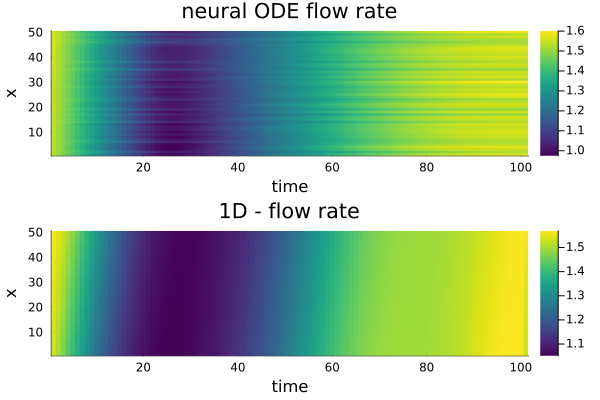

waveform: 3/5
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-95.244675
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 36.046959398872595
Iteration: 2 || Loss: 17.576905131712923
Iteration: 3 || Loss: 22.614297268868974
Iteration: 4 || Loss: 24.177800257847892
Iteration: 5 || Loss: 19.833716623350167
Iteration: 6 || Loss: 17.576905131712923
saving ADAM checkpoint...
Sum of params:-95.27249
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 17.576905131712923
Iteration: 2 || Loss: 14.946677178739552
Iteration: 3 || Loss: 15.855798324612689
Iteration: 4 || Loss: 15.15649637827888
Iteration: 5 || Loss: 14.171229660251676
Iteration: 6 || Loss: 13.792452884507364
Iteration: 7 || Loss: 14.112826779497667
Iteration: 8 || Loss: 14.344689901115084
Iteration: 9 || Loss: 14.021955289607519
Iteration: 10 || Loss: 13.556411279381262
Iteration: 11 || Loss: 13.30442216041609
Iteration: 12 || Loss: 13.438634311274672
Iteration: 13 || Loss: 13.4902746352

Iteration: 185 || Loss: 11.821438436713898
Iteration: 186 || Loss: 11.925039242748653
Iteration: 187 || Loss: 12.011455509018234
Iteration: 188 || Loss: 11.76911491363445
Iteration: 189 || Loss: 11.86066419544628
Iteration: 190 || Loss: 11.962010459509345
Iteration: 191 || Loss: 11.72862789777811
Iteration: 192 || Loss: 11.899572817717655
Iteration: 193 || Loss: 11.786223970250141
Iteration: 194 || Loss: 11.732822656638364
Iteration: 195 || Loss: 11.760650411143162
Iteration: 196 || Loss: 11.77460071200803
Iteration: 197 || Loss: 11.785992854307265
Iteration: 198 || Loss: 11.775610764948102
Iteration: 199 || Loss: 11.75499520182197
Iteration: 200 || Loss: 11.707153410418366
Iteration: 201 || Loss: 11.734362760710246
Iteration: 202 || Loss: 11.707815647010502
Iteration: 203 || Loss: 12.24249594462336
Iteration: 204 || Loss: 11.833514791307955
Iteration: 205 || Loss: 11.702670110985203
Iteration: 206 || Loss: 11.694475042414727
Iteration: 207 || Loss: 12.71192012633821
Iteration: 208 || 

Iteration: 377 || Loss: 11.302053380036487
Iteration: 378 || Loss: 11.246088629504847
Iteration: 379 || Loss: 11.72660034672383
Iteration: 380 || Loss: 11.444199350530413
Iteration: 381 || Loss: 12.214583044313432
Iteration: 382 || Loss: 12.717454245460921
Iteration: 383 || Loss: 11.621771367086604
Iteration: 384 || Loss: 11.503401660877959
Iteration: 385 || Loss: 12.145322686899291
Iteration: 386 || Loss: 11.438101613311192
Iteration: 387 || Loss: 11.453158758192755
Iteration: 388 || Loss: 12.03822378688404
Iteration: 389 || Loss: 11.239425865416061
Iteration: 390 || Loss: 12.27923915956869
Iteration: 391 || Loss: 11.308972705408541
Iteration: 392 || Loss: 11.327657148133836
Iteration: 393 || Loss: 11.5486714633696
Iteration: 394 || Loss: 11.268569143106951
Iteration: 395 || Loss: 11.365746125598363
Iteration: 396 || Loss: 11.36379226593884
Iteration: 397 || Loss: 11.248974816199944
Iteration: 398 || Loss: 11.392308500936245
Iteration: 399 || Loss: 11.337688729404718
Iteration: 400 ||

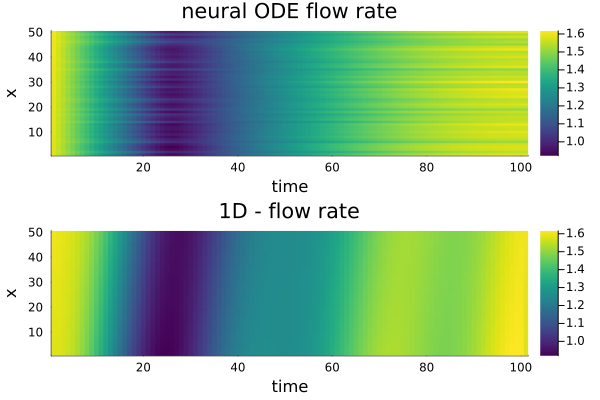

waveform: 4/5
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-95.68854
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 13.027554124226228
Iteration: 2 || Loss: 24.290696519561216
Iteration: 3 || Loss: 11.310169198765177
Iteration: 4 || Loss: 10.970746454309392
Iteration: 5 || Loss: 20.993371209824073
Iteration: 6 || Loss: 10.970746454309392
saving ADAM checkpoint...
Sum of params:-95.65863
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 10.970746454309392
Iteration: 2 || Loss: 23.626543232314077
Iteration: 3 || Loss: 9.64121527189575
Iteration: 4 || Loss: 13.68928586958727
Iteration: 5 || Loss: 14.833757445780645
Iteration: 6 || Loss: 11.052250793618606
Iteration: 7 || Loss: 9.767186735339223
Iteration: 8 || Loss: 11.722622652450074
Iteration: 9 || Loss: 12.809949602476735
Iteration: 10 || Loss: 13.605440310278187
Iteration: 11 || Loss: 9.671041100859817
Iteration: 12 || Loss: 10.21007264008804
Iteration: 13 || Loss: 11.762290182718251

Iteration: 188 || Loss: 8.924042831352347
Iteration: 189 || Loss: 8.972393990136224
Iteration: 190 || Loss: 8.876994824746172
Iteration: 191 || Loss: 8.901729826290536
Iteration: 192 || Loss: 8.913646913861529
Iteration: 193 || Loss: 9.894861731428357
Iteration: 194 || Loss: 9.034392917470742
Iteration: 195 || Loss: 9.155453518783037
Iteration: 196 || Loss: 8.966661434256547
Iteration: 197 || Loss: 8.890651081145748
Iteration: 198 || Loss: 11.510734685846694
Iteration: 199 || Loss: 8.881809813178373
Iteration: 200 || Loss: 8.910751667277315
Iteration: 201 || Loss: 9.12528805439296
Iteration: 202 || Loss: 9.22559358920438
Iteration: 203 || Loss: 8.948263588562217
Iteration: 204 || Loss: 10.431760223604524
Iteration: 205 || Loss: 9.7234508312973
Iteration: 206 || Loss: 9.1234585730914
Iteration: 207 || Loss: 9.247701270638482
Iteration: 208 || Loss: 9.01429862458533
Iteration: 209 || Loss: 8.928617271126178
Iteration: 210 || Loss: 9.080739357618057
Iteration: 211 || Loss: 9.0724478811608

Iteration: 384 || Loss: 9.043147233925518
Iteration: 385 || Loss: 8.653140853391813
Iteration: 386 || Loss: 8.689625954533415
Iteration: 387 || Loss: 9.016486063806276
Iteration: 388 || Loss: 8.796439794785858
Iteration: 389 || Loss: 8.657775513971458
Iteration: 390 || Loss: 8.80723335281749
Iteration: 391 || Loss: 8.769736455095805
Iteration: 392 || Loss: 9.15213182933003
Iteration: 393 || Loss: 8.59632230112386
Iteration: 394 || Loss: 8.56893644819025
Iteration: 395 || Loss: 8.637915437671753
Iteration: 396 || Loss: 8.608973603436882
Iteration: 397 || Loss: 9.514711791629509
Iteration: 398 || Loss: 8.672924665534827
Iteration: 399 || Loss: 9.356796704259338
Iteration: 400 || Loss: 9.154442367614983
Iteration: 401 || Loss: 9.462907485443495
Iteration: 402 || Loss: 8.665265759740088
Iteration: 403 || Loss: 11.559897526481237
Iteration: 404 || Loss: 8.74633985536749
Iteration: 405 || Loss: 8.648030996092457
Iteration: 406 || Loss: 8.985393678615571
Iteration: 407 || Loss: 9.019412441617

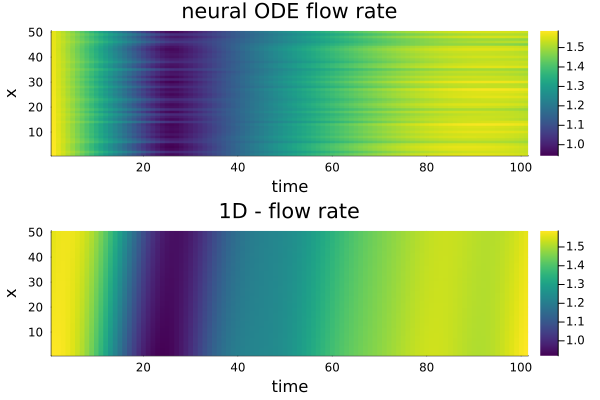

waveform: 5/5
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-96.00806
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 27.287335907196223
Iteration: 2 || Loss: 20.739599524729762
Iteration: 3 || Loss: 23.193756942563517
Iteration: 4 || Loss: 19.60008192060061
Iteration: 5 || Loss: 17.3472923300049
Iteration: 6 || Loss: 17.3472923300049
saving ADAM checkpoint...
Sum of params:-96.054825
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 17.3472923300049
Iteration: 2 || Loss: 18.778481047596763
Iteration: 3 || Loss: 15.66909157468352
Iteration: 4 || Loss: 14.318123161876407
Iteration: 5 || Loss: 13.179996032110324
Iteration: 6 || Loss: 12.25273361204823
Iteration: 7 || Loss: 12.491909418048444
Iteration: 8 || Loss: 11.945332495411682
Iteration: 9 || Loss: 11.724241062351371
Iteration: 10 || Loss: 11.759353384868021
Iteration: 11 || Loss: 11.562095095140808
Iteration: 12 || Loss: 11.525983558648443
Iteration: 13 || Loss: 10.967110726853846
I

Excessive output truncated after 524296 bytes.

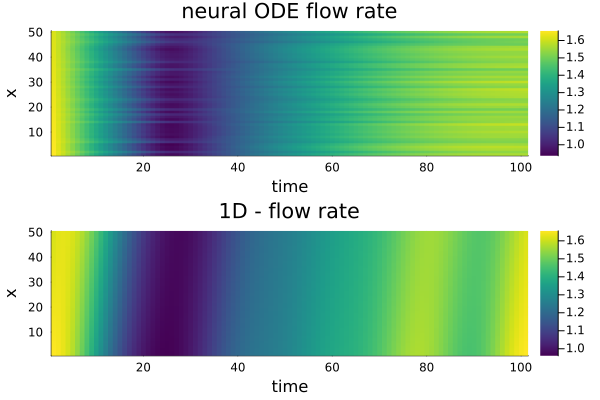

In [44]:

n_epochs = 5

#set time horizon settings
# nt = 100


list_loss_train = []
list_loss_epoch = []
# ntlist = [50,100]
ntlist = [100]
for nt in ntlist
    
    n_samples = Int(100/nt)+1
    println("nt:",nt)


    # epochs loop
    for j in 1:n_epochs
        println("Start training epoch ",j)
        loss_tot = 0.0
    
        # time horizon loop
        for k in 2:n_samples
            println("time: ",k-1, "/",n_samples-1)


            # loop over different waveforms
            for i in 1:size(ytrain2,3)
                
                println("waveform: ",i, "/",size(ytrain2,3))
                
                
                
                T = dt * nt  # total time
                tspan = (0.0, T)
                println(tspan)
                tsteps = 0:dt:tspan[2]  # create time vector

                #define BC only on the time horizon that is active, zero otherwise
                bcflow_k = zero(bc_flow1)
                bcflow_k[(k-2)*nt+1:(k-1)*nt+1] = bc_flow[(k-2)*nt+1:(k-1)*nt+1,i]

                #define optimization problem
                prob = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t, bcflow_k), ytrain2[(k-2)*nt+1,:,i], tspan, p);

                optf = Optimization.OptimizationFunction((x,p)->loss(x,ytrain2[(k-2)*nt+1:(k-1)*nt+1,:,i]',prob),adtype) ;

                println("Using $optimizer_choice1 optimizer")
                println("Sum of params:", sum(uinit))

                # Change learning rate for ADAM optimizer, BFGS doesn't use it
                if j == 3
                    learning_rate = 0.0001
                    println("Changing learning rate to:",learning_rate)
                end

                uinit = train_loop(uinit,adtype,optf,train_maxiters,learning_rate,optimizer_choice1)
                println("Sum of params:", sum(uinit))

                if !isnothing(optimizer_choice2)
                    println("Switching to $optimizer_choice2 optimizer")

                    uinit = train_loop(uinit,adtype,optf,train_maxiters*100,learning_rate,optimizer_choice2)

                    println("Sum of params:", sum(uinit))

                end

                #calculate final loss and push it to the list
                prob = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t,bcflow_k), ytrain2[(k-2)*nt+1,:,i], tspan, p);
                l , pred = loss(uinit,ytrain2[(k-2)*nt+1:(k-1)*nt+1,:,i]',prob)
                loss_tot = loss_tot + l

                push!(list_loss_train, l)
                println("Epoch ", j, " loss:", l)


                # plot solution for comparison
                plot1 = heatmap(pred[:,:], color=:viridis, title = "neural ODE flow rate")
                xlabel!("time")
                ylabel!("x")

                plot2 = heatmap(ytrain2[(k-2)*nt+1:(k-1)*nt+1,:,i]', title="1D - flow rate", color=:viridis)
                xlabel!("time")
                ylabel!("x")
                display(plot(plot1,plot2,layout = (2, 1)))
                sleep(1)
            end
            
        end
    push!(list_loss_epoch, loss_tot/(size(ytrain2,3)*(n_samples-1)))
    println("Epoch ", j, " mean loss loss:", loss_tot/(size(ytrain2,3)*(n_samples-1)))
    end

    
end

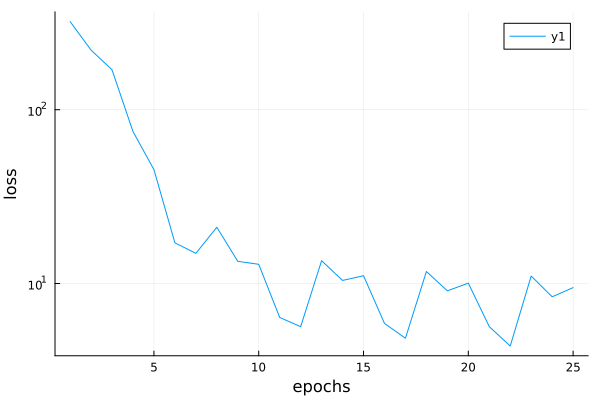

In [45]:
# plot loss as a function of epochs
p3 = plot(list_loss_train, yaxis=:log)
ylabel!("loss")
xlabel!("epochs")
png("parametric_BC_k_1DBlood_loss.png")
display(p3)

### Load the final learnt parameters and do inference on training data ###

saved trained solution


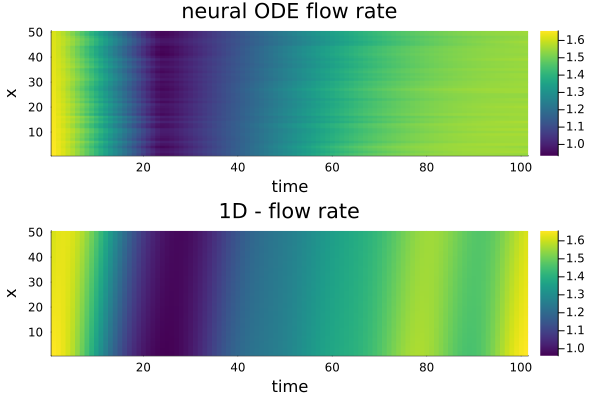

In [64]:
p_learn = load("/home/tschala/research/LANL/paramBC_testNODE/ptrained_" * optimizer_choice2 * ".jld2")
#waveform to evaluate
wv = 5
u01 = u0[:,wv]

p = p_learn["p"]

T = 1                      # total time
tsteps = 0.0:dt:T             # discretized time dimension
tspan = (0,T)    

begin 
    learn_1DBlood_prob_untrained(u01,tspan) = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t, bc_flow[:,wv]), u01, tspan, p)     # p changes after training   
    if ode_solver == "Tsit5"
        sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Tsit5(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
    elseif ode_solver == "RK4"
        sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),RK4(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
    elseif ode_solver == "Rosenbrock23"
        sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Rosenbrock23(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
    end
    save_object(output_dir*"/sol_learn_testNODE_trained.jld2",sol_learn_1DBlood_untrained)
    println("saved trained solution")
end

sol_learn = load("/home/tschala/research/LANL/paramBC_testNODE/output/sol_learn_testNODE_trained.jld2");

plot1 = heatmap(sol_learn["single_stored_object"][:,:], color=:viridis, title = "neural ODE flow rate")
xlabel!("time")
ylabel!("x")

plot2 = heatmap(ytrain2[:,:,wv]', title="1D - flow rate", color=:viridis)
xlabel!("time")
ylabel!("x")

plot(plot1,plot2,layout = (2, 1))

### Inference on validation data ###

saved trained solution


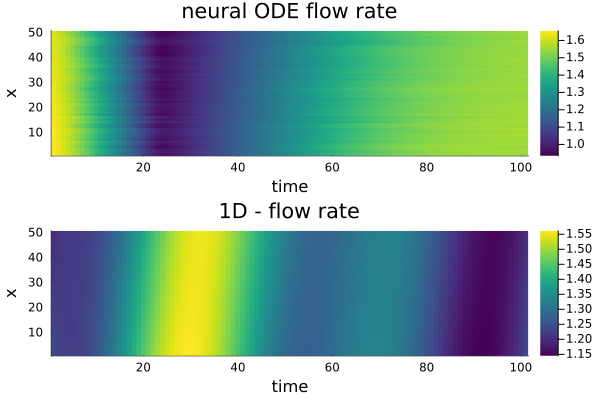

In [70]:
p_learn = load("/home/tschala/research/LANL/paramBC_testNODE/ptrained_" * optimizer_choice2 * ".jld2")
#waveform to evaluate
wv = 2
u01 = u0val[:,wv]

p = p_learn["p"]

T = 1                      # total time
tsteps = 0.0:dt:T             # discretized time dimension
tspan = (0,T)    

begin 
    learn_1DBlood_prob_untrained(u01,tspan) = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t, bc_flow[:,wv]), u01, tspan, p)     # p changes after training   
    if ode_solver == "Tsit5"
        sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Tsit5(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
    elseif ode_solver == "RK4"
        sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),RK4(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
    elseif ode_solver == "Rosenbrock23"
        sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Rosenbrock23(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
    end
    save_object(output_dir*"/sol_learn_testNODE_trained.jld2",sol_learn_1DBlood_untrained)
    println("saved trained solution")
end

sol_learn = load("/home/tschala/research/LANL/paramBC_testNODE/output/sol_learn_testNODE_trained.jld2");

plot1 = heatmap(sol_learn["single_stored_object"][:,:], color=:viridis, title = "neural ODE flow rate")
xlabel!("time")
ylabel!("x")

plot2 = heatmap(ytrain2val[:,:,wv]', title="1D - flow rate", color=:viridis)
xlabel!("time")
ylabel!("x")

plot(plot1,plot2,layout = (2, 1))

### Transfer learning ###

In [52]:
#validation data
u0val = data1d_fix[1,1:2:end,waveforms+2:2*waveforms,1];
ytrain2val = data1d_fix[:,1:2:end,waveforms+2:2*waveforms,1];
bc_flow_val = data1d_fix[:,1,waveforms+2:2*waveforms,1];

In [66]:
ode_solver = "Tsit5"
output_dir = "/home/tschala/research/LANL/paramBC_transferred_testNODE"
working_dir = output_dir
 
#load params from other directory
#load params with the name of the optimizer2 that last was used
p_learn = load("/home/tschala/research/LANL/paramBC_testNODE/ptrained_" * optimizer_choice2 * ".jld2")

#print out sum of params for checking
p = p_learn["p"]
println("Sum of params:", sum(p))


Sum of params:-98.21786


In [67]:
# process user choices

if !isdir(working_dir)
    mkdir(working_dir)
end
output_dir = working_dir*"/output/"
cd(working_dir) #switch to working directory
if !isdir(output_dir)
    mkdir(output_dir)
end
println("optimizer 1 is $optimizer_choice1")
if !isnothing(optimizer_choice2)
    println("optimizer 2 is $optimizer_choice2 optimizer")
end

println("ODE Time integrator selected:", ode_solver)


optimizer 1 is ADAM
optimizer 2 is ADAM optimizer
ODE Time integrator selected:Tsit5


nt:100
Start training epoch 1
time: 1/1
waveform: 1/4
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-98.21786
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 1026.7930930528585
Iteration: 2 || Loss: 765.3087795638711
Iteration: 3 || Loss: 548.8332136103425
Iteration: 4 || Loss: 386.8348317169052
Iteration: 5 || Loss: 277.69411597904366
Iteration: 6 || Loss: 277.69411597904366
saving ADAM checkpoint...
Sum of params:-98.35662
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 277.69411597904366
Iteration: 2 || Loss: 206.89437129676378
Iteration: 3 || Loss: 169.3742657400398
Iteration: 4 || Loss: 149.35857515288075
Iteration: 5 || Loss: 137.1130574413522
Iteration: 6 || Loss: 128.21681801068584
Iteration: 7 || Loss: 120.84362607839469
Iteration: 8 || Loss: 114.22521950260769
Iteration: 9 || Loss: 108.00027887517277
Iteration: 10 || Loss: 102.0302179076136
Iteration: 11 || Loss: 96.21614958011124
Iteration: 12 || Loss: 90.50103521738721
Ite

Iteration: 185 || Loss: 5.4680840414067715
Iteration: 186 || Loss: 5.431467179268287
Iteration: 187 || Loss: 5.39181116765244
Iteration: 188 || Loss: 5.349528667938607
Iteration: 189 || Loss: 5.319183024149391
Iteration: 190 || Loss: 5.282590554550865
Iteration: 191 || Loss: 5.261174748834378
Iteration: 192 || Loss: 5.2289154492075305
Iteration: 193 || Loss: 5.1844104689789905
Iteration: 194 || Loss: 5.165257967875717
Iteration: 195 || Loss: 5.125786053670414
Iteration: 196 || Loss: 5.100978044782245
Iteration: 197 || Loss: 5.071313944401618
Iteration: 198 || Loss: 5.041351116675854
Iteration: 199 || Loss: 5.004455422730192
Iteration: 200 || Loss: 4.9814908259749755
Iteration: 201 || Loss: 4.944803915939896
Iteration: 202 || Loss: 4.917744577079677
Iteration: 203 || Loss: 4.894631828187817
Iteration: 204 || Loss: 4.866309937007081
Iteration: 205 || Loss: 4.836972014120676
Iteration: 206 || Loss: 4.811566458158142
Iteration: 207 || Loss: 4.787183097561524
Iteration: 208 || Loss: 4.76266

Iteration: 379 || Loss: 2.768568892886554
Iteration: 380 || Loss: 2.7285573160914343
Iteration: 381 || Loss: 2.7653222218733555
Iteration: 382 || Loss: 2.720591016682066
Iteration: 383 || Loss: 2.7822894143956516
Iteration: 384 || Loss: 2.7303273323791366
Iteration: 385 || Loss: 2.7067441988181375
Iteration: 386 || Loss: 2.7268122994004793
Iteration: 387 || Loss: 2.7623010814230984
Iteration: 388 || Loss: 2.9083202059562105
Iteration: 389 || Loss: 2.7261934887421546
Iteration: 390 || Loss: 2.703190909636218
Iteration: 391 || Loss: 2.7216929964894625
Iteration: 392 || Loss: 2.7862347632138658
Iteration: 393 || Loss: 2.7382806978452745
Iteration: 394 || Loss: 2.7564699708382037
Iteration: 395 || Loss: 2.8423852438890767
Iteration: 396 || Loss: 2.861637167435191
Iteration: 397 || Loss: 2.7401453112609975
Iteration: 398 || Loss: 2.7256063384706826
Iteration: 399 || Loss: 2.9484448178487
Iteration: 400 || Loss: 3.030577443734055
Iteration: 401 || Loss: 2.7741503427397065
Iteration: 402 || L

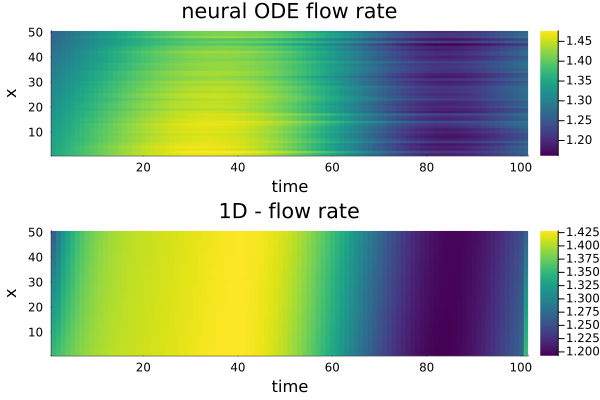

waveform: 2/4
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-97.569496
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 142.84113470265186
Iteration: 2 || Loss: 133.65295135465237
Iteration: 3 || Loss: 121.11120239356693
Iteration: 4 || Loss: 99.22082837807794
Iteration: 5 || Loss: 70.97868127312147
Iteration: 6 || Loss: 70.97868127312147
saving ADAM checkpoint...
Sum of params:-97.5413
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 70.97868127312147
Iteration: 2 || Loss: 37.21329522738706
Iteration: 3 || Loss: 77.8339923419944
Iteration: 4 || Loss: 38.230969561383645
Iteration: 5 || Loss: 35.93219834977673
Iteration: 6 || Loss: 43.3307289584323
Iteration: 7 || Loss: 47.06493368647427
Iteration: 8 || Loss: 48.31086142023862
Iteration: 9 || Loss: 47.41065099963377
Iteration: 10 || Loss: 43.158340374092504
Iteration: 11 || Loss: 37.56213538049987
Iteration: 12 || Loss: 31.209093305774793
Iteration: 13 || Loss: 29.194030523207296
Iterati

Iteration: 185 || Loss: 19.95630818195213
Iteration: 186 || Loss: 19.958830216024456
Iteration: 187 || Loss: 19.955195178756842
Iteration: 188 || Loss: 19.947607788458036
Iteration: 189 || Loss: 19.94165358307646
Iteration: 190 || Loss: 19.933777252234027
Iteration: 191 || Loss: 19.90865342022323
Iteration: 192 || Loss: 19.901092982453974
Iteration: 193 || Loss: 19.90700493703421
Iteration: 194 || Loss: 19.905936748578952
Iteration: 195 || Loss: 19.897511809427
Iteration: 196 || Loss: 19.883938777872878
Iteration: 197 || Loss: 19.88076499648417
Iteration: 198 || Loss: 19.878504413100643
Iteration: 199 || Loss: 19.857129557370428
Iteration: 200 || Loss: 19.853686652024983
Iteration: 201 || Loss: 19.851284980964213
Iteration: 202 || Loss: 19.840997463597105
Iteration: 203 || Loss: 19.845300053442614
Iteration: 204 || Loss: 19.8236479599246
Iteration: 205 || Loss: 19.834951971839857
Iteration: 206 || Loss: 19.827871215453065
Iteration: 207 || Loss: 19.806347562897095
Iteration: 208 || Los

Iteration: 378 || Loss: 19.164595080391827
Iteration: 379 || Loss: 19.167253790359496
Iteration: 380 || Loss: 19.160139334171717
Iteration: 381 || Loss: 19.162443736565823
Iteration: 382 || Loss: 19.15282670898292
Iteration: 383 || Loss: 19.148641810316555
Iteration: 384 || Loss: 19.154878928115032
Iteration: 385 || Loss: 19.15238015515535
Iteration: 386 || Loss: 19.148345566155065
Iteration: 387 || Loss: 19.138606202673582
Iteration: 388 || Loss: 19.143354340994854
Iteration: 389 || Loss: 19.141151936171788
Iteration: 390 || Loss: 19.12628623230122
Iteration: 391 || Loss: 19.1245484694295
Iteration: 392 || Loss: 19.12154020764072
Iteration: 393 || Loss: 19.12828595803129
Iteration: 394 || Loss: 19.116171277635196
Iteration: 395 || Loss: 19.113841886620857
Iteration: 396 || Loss: 19.109129602060417
Iteration: 397 || Loss: 19.11334409413837
Iteration: 398 || Loss: 19.11438819815943
Iteration: 399 || Loss: 19.107102444919736
Iteration: 400 || Loss: 19.10494923989862
Iteration: 401 || Los

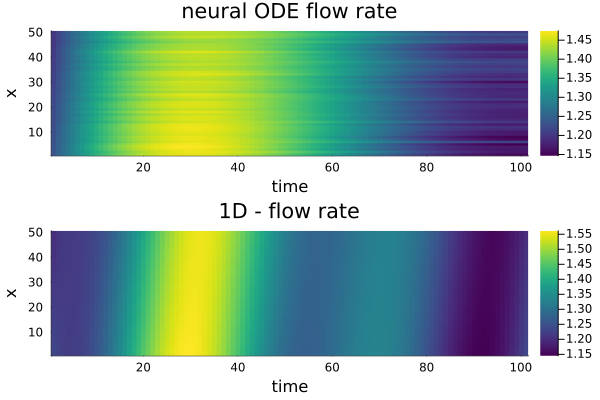

waveform: 3/4
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-96.3516
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 108.75783464299411
Iteration: 2 || Loss: 19.388346345720592
Iteration: 3 || Loss: 18.259330821130806
Iteration: 4 || Loss: 33.811068433979784
Iteration: 5 || Loss: 44.23075450038891
Iteration: 6 || Loss: 18.259330821130806
saving ADAM checkpoint...
Sum of params:-96.403145
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 18.259330821130806
Iteration: 2 || Loss: 22.358268069599617
Iteration: 3 || Loss: 9.382762937733693
Iteration: 4 || Loss: 10.556848549258575
Iteration: 5 || Loss: 14.939163227276332
Iteration: 6 || Loss: 13.885752006067214
Iteration: 7 || Loss: 10.616233796652118
Iteration: 8 || Loss: 9.32319076315763
Iteration: 9 || Loss: 10.088505698208523
Iteration: 10 || Loss: 9.662503860487776
Iteration: 11 || Loss: 8.728972280448758
Iteration: 12 || Loss: 8.943142438687692
Iteration: 13 || Loss: 9.678656673813654
I

Iteration: 188 || Loss: 4.298996443421922
Iteration: 189 || Loss: 4.29699813802911
Iteration: 190 || Loss: 4.290711024677844
Iteration: 191 || Loss: 4.287728271057018
Iteration: 192 || Loss: 4.285902053830567
Iteration: 193 || Loss: 4.282586451435052
Iteration: 194 || Loss: 4.275248130221151
Iteration: 195 || Loss: 4.274259005934006
Iteration: 196 || Loss: 4.2674611611907425
Iteration: 197 || Loss: 4.265223965967069
Iteration: 198 || Loss: 4.260762861184189
Iteration: 199 || Loss: 4.255737503809686
Iteration: 200 || Loss: 4.25385937681372
Iteration: 201 || Loss: 4.249069593520602
Iteration: 202 || Loss: 4.244348361154433
Iteration: 203 || Loss: 4.240474297297948
Iteration: 204 || Loss: 4.2366042415968606
Iteration: 205 || Loss: 4.234915658102817
Iteration: 206 || Loss: 4.230114430820097
Iteration: 207 || Loss: 4.22529505737904
Iteration: 208 || Loss: 4.223479462601278
Iteration: 209 || Loss: 4.217947702670209
Iteration: 210 || Loss: 4.216895664728257
Iteration: 211 || Loss: 4.212695275

Iteration: 383 || Loss: 3.7198504610858767
Iteration: 384 || Loss: 3.717940457986352
Iteration: 385 || Loss: 3.7158721408477646
Iteration: 386 || Loss: 3.7134900170610976
Iteration: 387 || Loss: 3.7112001160576646
Iteration: 388 || Loss: 3.7091755241334297
Iteration: 389 || Loss: 3.7074123545333815
Iteration: 390 || Loss: 3.7048755613205024
Iteration: 391 || Loss: 3.702947566250999
Iteration: 392 || Loss: 3.7005352459989735
Iteration: 393 || Loss: 3.69856766574621
Iteration: 394 || Loss: 3.696361658982906
Iteration: 395 || Loss: 3.694435564821706
Iteration: 396 || Loss: 3.6934760711155845
Iteration: 397 || Loss: 3.690295363017365
Iteration: 398 || Loss: 3.6884404322807196
Iteration: 399 || Loss: 3.686320815218374
Iteration: 400 || Loss: 3.6834505141731957
Iteration: 401 || Loss: 3.681314279947739
Iteration: 402 || Loss: 3.6798494907017396
Iteration: 403 || Loss: 3.6789417566133586
Iteration: 404 || Loss: 3.676994130759
Iteration: 405 || Loss: 3.674009432961107
Iteration: 406 || Loss: 3

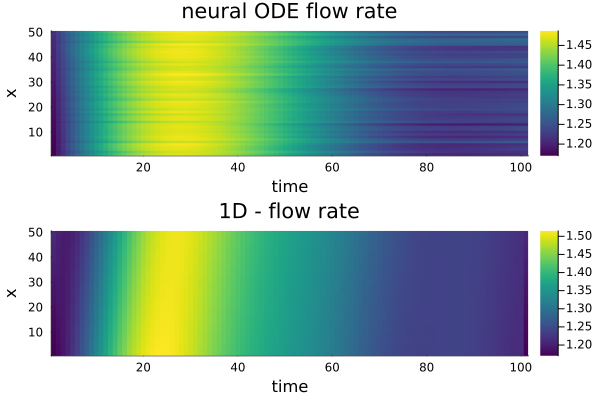

waveform: 4/4
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-97.0947
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 20.059635594920007
Iteration: 2 || Loss: 8.328035807029098
Iteration: 3 || Loss: 17.52520706371668
Iteration: 4 || Loss: 17.962373787129234
Iteration: 5 || Loss: 12.786271584140989
Iteration: 6 || Loss: 8.328035807029098
saving ADAM checkpoint...
Sum of params:-97.12493
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 8.328035807029098
Iteration: 2 || Loss: 20.043425259113718
Iteration: 3 || Loss: 5.543146409573168
Iteration: 4 || Loss: 8.187630611331812
Iteration: 5 || Loss: 12.338279114673174
Iteration: 6 || Loss: 11.82317355922158
Iteration: 7 || Loss: 8.270141374770564
Iteration: 8 || Loss: 5.320904405927074
Iteration: 9 || Loss: 6.1430997409570445
Iteration: 10 || Loss: 8.91466305629859
Iteration: 11 || Loss: 8.37420949776828
Iteration: 12 || Loss: 5.85335346262191
Iteration: 13 || Loss: 5.0181086353282325
Iteration

Iteration: 188 || Loss: 4.739780824763047
Iteration: 189 || Loss: 4.740298221012033
Iteration: 190 || Loss: 4.739514095286973
Iteration: 191 || Loss: 4.738609088449643
Iteration: 192 || Loss: 4.739203809774816
Iteration: 193 || Loss: 4.740480964234758
Iteration: 194 || Loss: 4.738929157597221
Iteration: 195 || Loss: 4.740883668703382
Iteration: 196 || Loss: 4.736609834472523
Iteration: 197 || Loss: 4.736350764735674
Iteration: 198 || Loss: 4.740504561560769
Iteration: 199 || Loss: 4.735877831682727
Iteration: 200 || Loss: 4.7345591660853845
Iteration: 201 || Loss: 4.735765361925478
Iteration: 202 || Loss: 4.733659312610508
Iteration: 203 || Loss: 4.733459988624436
Iteration: 204 || Loss: 4.732567371749277
Iteration: 205 || Loss: 4.73259283248928
Iteration: 206 || Loss: 4.73163498642744
Iteration: 207 || Loss: 4.731990308993476
Iteration: 208 || Loss: 4.732015054550962
Iteration: 209 || Loss: 4.730767013618525
Iteration: 210 || Loss: 4.731955355725239
Iteration: 211 || Loss: 4.729920051

Iteration: 384 || Loss: 4.656213548393788
Iteration: 385 || Loss: 4.654683353524402
Iteration: 386 || Loss: 4.6543640852902985
Iteration: 387 || Loss: 4.65268881850238
Iteration: 388 || Loss: 4.655464653239341
Iteration: 389 || Loss: 4.652481286251779
Iteration: 390 || Loss: 4.6546767763253545
Iteration: 391 || Loss: 4.6526126855846055
Iteration: 392 || Loss: 4.6529919752775
Iteration: 393 || Loss: 4.6510918371064145
Iteration: 394 || Loss: 4.653196584753473
Iteration: 395 || Loss: 4.6502734557475485
Iteration: 396 || Loss: 4.648554523968528
Iteration: 397 || Loss: 4.649041538138941
Iteration: 398 || Loss: 4.648496097080632
Iteration: 399 || Loss: 4.647313749823477
Iteration: 400 || Loss: 4.647639734815533
Iteration: 401 || Loss: 4.647218601755736
Iteration: 402 || Loss: 4.646689718848915
Iteration: 403 || Loss: 4.646586315520908
Iteration: 404 || Loss: 4.64628356643405
Iteration: 405 || Loss: 4.644912369742723
Iteration: 406 || Loss: 4.644862457783274
Iteration: 407 || Loss: 4.6459920

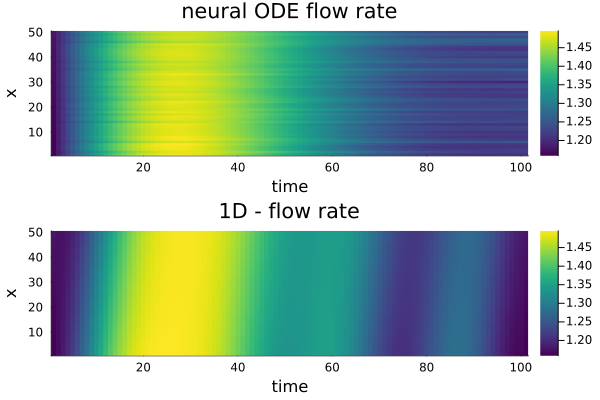

Epoch 1 mean loss loss:7.347633722614038
Start training epoch 2
time: 1/1
waveform: 1/4
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-96.89513
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 161.01761341482717
Iteration: 2 || Loss: 49.65720876058522
Iteration: 3 || Loss: 15.427332739559315
Iteration: 4 || Loss: 12.672842604088327
Iteration: 5 || Loss: 19.618404297663254
Iteration: 6 || Loss: 12.672842604088327
saving ADAM checkpoint...
Sum of params:-96.98257
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 12.672842604088327
Iteration: 2 || Loss: 20.069571473494406
Iteration: 3 || Loss: 11.987300336674771
Iteration: 4 || Loss: 13.509926969315146
Iteration: 5 || Loss: 15.357938674797843
Iteration: 6 || Loss: 14.280555353222908
Iteration: 7 || Loss: 12.526325012703792
Iteration: 8 || Loss: 11.772674884111487
Iteration: 9 || Loss: 11.981820053483668
Iteration: 10 || Loss: 11.990198344105925
Iteration: 11 || Loss: 11.565054965669528
Iter

Iteration: 185 || Loss: 3.1220357509754244
Iteration: 186 || Loss: 3.105051154328211
Iteration: 187 || Loss: 3.1108152875978563
Iteration: 188 || Loss: 3.0701874821988766
Iteration: 189 || Loss: 3.0767155568874722
Iteration: 190 || Loss: 3.075587080269236
Iteration: 191 || Loss: 3.0818667640698734
Iteration: 192 || Loss: 3.0167824432957246
Iteration: 193 || Loss: 3.0498092404693833
Iteration: 194 || Loss: 3.1333162695281684
Iteration: 195 || Loss: 3.072616197792496
Iteration: 196 || Loss: 3.0039894662510953
Iteration: 197 || Loss: 3.006659325509262
Iteration: 198 || Loss: 3.017013187835463
Iteration: 199 || Loss: 2.956599452297775
Iteration: 200 || Loss: 2.9701137182426214
Iteration: 201 || Loss: 3.0350420236542788
Iteration: 202 || Loss: 3.00190045139348
Iteration: 203 || Loss: 2.9187141001767687
Iteration: 204 || Loss: 2.9312305625997084
Iteration: 205 || Loss: 3.006989722102695
Iteration: 206 || Loss: 2.9936975396311163
Iteration: 207 || Loss: 2.8909290681163897
Iteration: 208 || Lo

Iteration: 378 || Loss: 2.2497195298872033
Iteration: 379 || Loss: 2.2822276210933174
Iteration: 380 || Loss: 2.24120202044385
Iteration: 381 || Loss: 2.2626655768681845
Iteration: 382 || Loss: 2.2371511913810513
Iteration: 383 || Loss: 2.2430524217007224
Iteration: 384 || Loss: 2.243214504017682
Iteration: 385 || Loss: 2.220941933029807
Iteration: 386 || Loss: 2.3696697108641818
Iteration: 387 || Loss: 2.2903397545977926
Iteration: 388 || Loss: 2.2926462390985765
Iteration: 389 || Loss: 2.2324207615613956
Iteration: 390 || Loss: 2.272006834273908
Iteration: 391 || Loss: 2.2237504580549414
Iteration: 392 || Loss: 2.3194740907525406
Iteration: 393 || Loss: 2.2893919843877164
Iteration: 394 || Loss: 2.1779711911007906
Iteration: 395 || Loss: 2.2723971184882092
Iteration: 396 || Loss: 2.2285190440949116
Iteration: 397 || Loss: 2.1975802808010427
Iteration: 398 || Loss: 2.281212191213273
Iteration: 399 || Loss: 2.232741342372596
Iteration: 400 || Loss: 2.217748539115709
Iteration: 401 || L

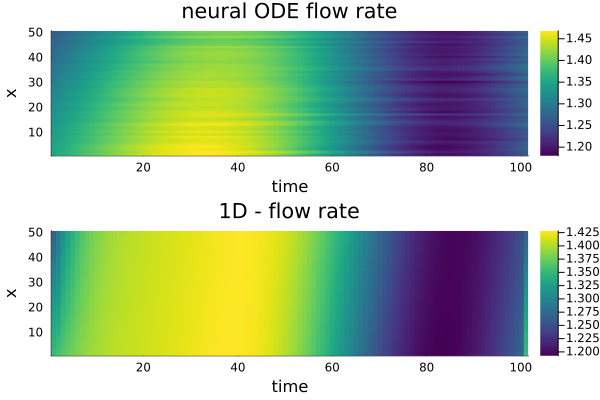

waveform: 2/4
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-97.27654
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 229.83293218723085
Iteration: 2 || Loss: 166.238791512932
Iteration: 3 || Loss: 163.22015147541643
Iteration: 4 || Loss: 161.25211627215143
Iteration: 5 || Loss: 153.3935667012957
Iteration: 6 || Loss: 153.3935667012957
saving ADAM checkpoint...
Sum of params:-97.31798
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 153.3935667012957
Iteration: 2 || Loss: 113.36179864448734
Iteration: 3 || Loss: 89.13816913066972
Iteration: 4 || Loss: 54.686483969979605
Iteration: 5 || Loss: 44.55437907520113
Iteration: 6 || Loss: 58.66859717583301
Iteration: 7 || Loss: 50.455979220947796
Iteration: 8 || Loss: 42.43562680332171
Iteration: 9 || Loss: 43.14948012314967
Iteration: 10 || Loss: 46.70958543182468
Iteration: 11 || Loss: 48.275945868678605
Iteration: 12 || Loss: 45.71810490233968
Iteration: 13 || Loss: 40.60357183306681
Iterat

Iteration: 185 || Loss: 18.96124385448503
Iteration: 186 || Loss: 18.942764301178943
Iteration: 187 || Loss: 18.92941498183201
Iteration: 188 || Loss: 18.91859491265835
Iteration: 189 || Loss: 18.906174134140578
Iteration: 190 || Loss: 18.900743726072434
Iteration: 191 || Loss: 18.885680271488596
Iteration: 192 || Loss: 18.87893375936316
Iteration: 193 || Loss: 18.868866890823064
Iteration: 194 || Loss: 18.852463882861446
Iteration: 195 || Loss: 18.847468889319877
Iteration: 196 || Loss: 18.832216005282085
Iteration: 197 || Loss: 18.82260699184273
Iteration: 198 || Loss: 18.810011004948922
Iteration: 199 || Loss: 18.801589658945343
Iteration: 200 || Loss: 18.79512647677645
Iteration: 201 || Loss: 18.785676933424984
Iteration: 202 || Loss: 18.773454158078305
Iteration: 203 || Loss: 18.765663452865773
Iteration: 204 || Loss: 18.75317406777172
Iteration: 205 || Loss: 18.74366432531891
Iteration: 206 || Loss: 18.73836875983519
Iteration: 207 || Loss: 18.726732987577282
Iteration: 208 || Lo

Iteration: 377 || Loss: 17.998483538656274
Iteration: 378 || Loss: 17.99352955251978
Iteration: 379 || Loss: 17.992166622754965
Iteration: 380 || Loss: 17.98906844475433
Iteration: 381 || Loss: 17.987480207848886
Iteration: 382 || Loss: 17.986380583585245
Iteration: 383 || Loss: 17.981029530279244
Iteration: 384 || Loss: 17.981924652720664
Iteration: 385 || Loss: 17.979607559581954
Iteration: 386 || Loss: 17.975682639602695
Iteration: 387 || Loss: 17.97480553796192
Iteration: 388 || Loss: 17.97226055000153
Iteration: 389 || Loss: 17.97034051996456
Iteration: 390 || Loss: 17.96742461004942
Iteration: 391 || Loss: 17.965014680755008
Iteration: 392 || Loss: 17.962210833270877
Iteration: 393 || Loss: 17.960695097114005
Iteration: 394 || Loss: 17.95808024282568
Iteration: 395 || Loss: 17.956382448717264
Iteration: 396 || Loss: 17.9519177009571
Iteration: 397 || Loss: 17.949523647261596
Iteration: 398 || Loss: 17.94900164854614
Iteration: 399 || Loss: 17.94557249322596
Iteration: 400 || Loss

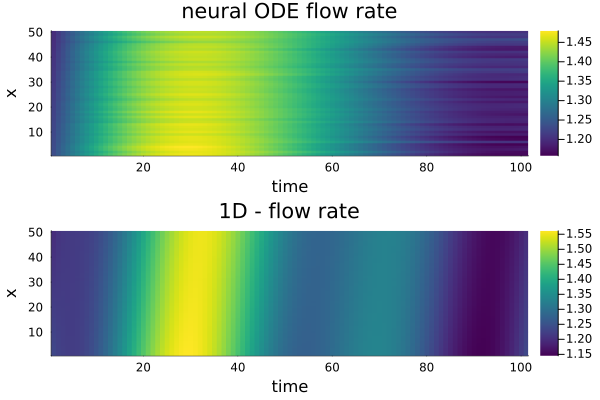

waveform: 3/4
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-96.11555
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 73.02569637713768
Iteration: 2 || Loss: 16.638333214502453
Iteration: 3 || Loss: 16.14239468481634
Iteration: 4 || Loss: 27.838855230310486
Iteration: 5 || Loss: 34.518247019925084
Iteration: 6 || Loss: 16.14239468481634
saving ADAM checkpoint...
Sum of params:-96.173744
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 16.14239468481634
Iteration: 2 || Loss: 17.391000770140984
Iteration: 3 || Loss: 9.623964897184024
Iteration: 4 || Loss: 9.458576002943872
Iteration: 5 || Loss: 12.887753050628644
Iteration: 6 || Loss: 11.637095092336116
Iteration: 7 || Loss: 8.384633828810092
Iteration: 8 || Loss: 7.705346485763071
Iteration: 9 || Loss: 9.64316434860224
Iteration: 10 || Loss: 9.984015300680742
Iteration: 11 || Loss: 8.473866090378474
Iteration: 12 || Loss: 7.6144463233436745
Iteration: 13 || Loss: 7.976223762791266
Itera

Iteration: 188 || Loss: 3.978207193673499
Iteration: 189 || Loss: 3.9734023603883184
Iteration: 190 || Loss: 3.9688708147597285
Iteration: 191 || Loss: 3.964323456122835
Iteration: 192 || Loss: 3.9585087287048246
Iteration: 193 || Loss: 3.956030594500436
Iteration: 194 || Loss: 3.9515618983380594
Iteration: 195 || Loss: 3.9469384627637405
Iteration: 196 || Loss: 3.9422836820424645
Iteration: 197 || Loss: 3.9390112028776607
Iteration: 198 || Loss: 3.9333747877356444
Iteration: 199 || Loss: 3.9301384309634635
Iteration: 200 || Loss: 3.9258954039294727
Iteration: 201 || Loss: 3.921379796099427
Iteration: 202 || Loss: 3.915353760908072
Iteration: 203 || Loss: 3.91061848324354
Iteration: 204 || Loss: 3.906335394849723
Iteration: 205 || Loss: 3.90330521997675
Iteration: 206 || Loss: 3.8983071356163568
Iteration: 207 || Loss: 3.8943551002499506
Iteration: 208 || Loss: 3.8896961622601944
Iteration: 209 || Loss: 3.8876664953331863
Iteration: 210 || Loss: 3.8820173799815927
Iteration: 211 || Los

Iteration: 381 || Loss: 3.335935735337576
Iteration: 382 || Loss: 3.3331279110929812
Iteration: 383 || Loss: 3.3305755000863173
Iteration: 384 || Loss: 3.3274099328432873
Iteration: 385 || Loss: 3.3263763209277273
Iteration: 386 || Loss: 3.323741022761784
Iteration: 387 || Loss: 3.3205261658146306
Iteration: 388 || Loss: 3.317938681408394
Iteration: 389 || Loss: 3.316291110189438
Iteration: 390 || Loss: 3.3132060507777696
Iteration: 391 || Loss: 3.311419700221869
Iteration: 392 || Loss: 3.308933806097087
Iteration: 393 || Loss: 3.3064007576744543
Iteration: 394 || Loss: 3.303898027983334
Iteration: 395 || Loss: 3.302448325595758
Iteration: 396 || Loss: 3.299445862793203
Iteration: 397 || Loss: 3.2978233871317553
Iteration: 398 || Loss: 3.2952636558769752
Iteration: 399 || Loss: 3.292726690728962
Iteration: 400 || Loss: 3.290702030447944
Iteration: 401 || Loss: 3.28791826033994
Iteration: 402 || Loss: 3.2863371431139674
Iteration: 403 || Loss: 3.284092728117459
Iteration: 404 || Loss: 3

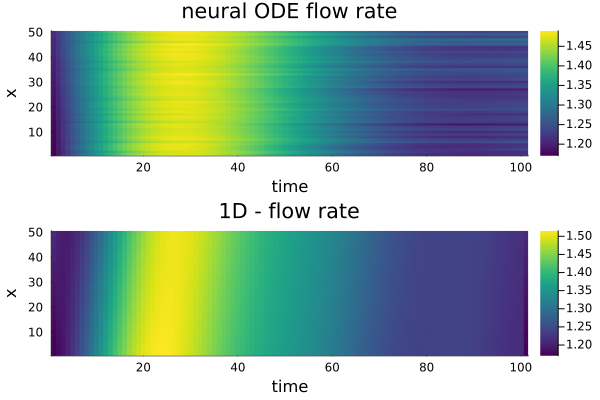

waveform: 4/4
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-96.98832
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 12.384637342462419
Iteration: 2 || Loss: 9.127021785505335
Iteration: 3 || Loss: 13.643445150958394
Iteration: 4 || Loss: 9.971064294902167
Iteration: 5 || Loss: 5.510392275823165
Iteration: 6 || Loss: 5.510392275823165
saving ADAM checkpoint...
Sum of params:-97.01067
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 5.510392275823165
Iteration: 2 || Loss: 25.268825488546558
Iteration: 3 || Loss: 5.591988766084293
Iteration: 4 || Loss: 8.261648067857148
Iteration: 5 || Loss: 14.506272305590183
Iteration: 6 || Loss: 15.743612623340015
Iteration: 7 || Loss: 12.500298600573279
Iteration: 8 || Loss: 7.680275217370076
Iteration: 9 || Loss: 4.799367490682476
Iteration: 10 || Loss: 6.180718806232369
Iteration: 11 || Loss: 9.586301291708558
Iteration: 12 || Loss: 9.886634966569384
Iteration: 13 || Loss: 7.135606992344112
Iterat

Iteration: 188 || Loss: 4.40627924899265
Iteration: 189 || Loss: 4.403556333924467
Iteration: 190 || Loss: 4.403077740331663
Iteration: 191 || Loss: 4.403142328621951
Iteration: 192 || Loss: 4.402331284732094
Iteration: 193 || Loss: 4.40533775882976
Iteration: 194 || Loss: 4.404962680205056
Iteration: 195 || Loss: 4.404871835131139
Iteration: 196 || Loss: 4.404435979237595
Iteration: 197 || Loss: 4.404032910619139
Iteration: 198 || Loss: 4.402830601027666
Iteration: 199 || Loss: 4.39984050885534
Iteration: 200 || Loss: 4.403177943688753
Iteration: 201 || Loss: 4.398562511840741
Iteration: 202 || Loss: 4.402241649610778
Iteration: 203 || Loss: 4.399475324575042
Iteration: 204 || Loss: 4.4017408623259495
Iteration: 205 || Loss: 4.400737110405206
Iteration: 206 || Loss: 4.4005459347503315
Iteration: 207 || Loss: 4.400658300301222
Iteration: 208 || Loss: 4.400223094557772
Iteration: 209 || Loss: 4.399629075496037
Iteration: 210 || Loss: 4.3987026324018785
Iteration: 211 || Loss: 4.39921322

Iteration: 383 || Loss: 4.339957649302599
Iteration: 384 || Loss: 4.339898960669279
Iteration: 385 || Loss: 4.3392380819705965
Iteration: 386 || Loss: 4.339237591392284
Iteration: 387 || Loss: 4.33825632357758
Iteration: 388 || Loss: 4.337928184488981
Iteration: 389 || Loss: 4.3382480816823605
Iteration: 390 || Loss: 4.337145759859352
Iteration: 391 || Loss: 4.337382320784792
Iteration: 392 || Loss: 4.336308964055759
Iteration: 393 || Loss: 4.337097960843618
Iteration: 394 || Loss: 4.336301240260515
Iteration: 395 || Loss: 4.335276411864006
Iteration: 396 || Loss: 4.335912833508961
Iteration: 397 || Loss: 4.33479791331164
Iteration: 398 || Loss: 4.334804836167635
Iteration: 399 || Loss: 4.334171325166927
Iteration: 400 || Loss: 4.334199025384928
Iteration: 401 || Loss: 4.33415696044187
Iteration: 402 || Loss: 4.333075068808974
Iteration: 403 || Loss: 4.33327229617128
Iteration: 404 || Loss: 4.332194940125364
Iteration: 405 || Loss: 4.331691665091418
Iteration: 406 || Loss: 4.3290968217

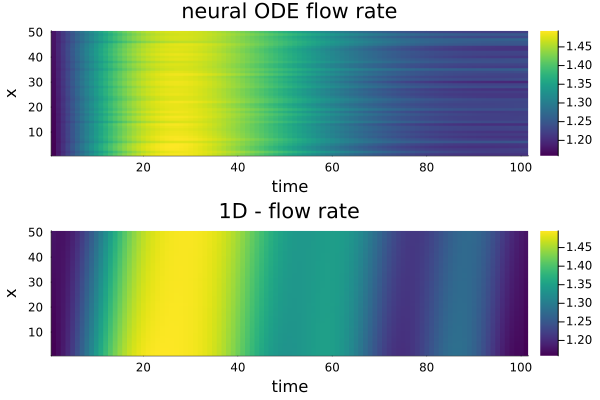

Epoch 2 mean loss loss:6.793118214160066
Start training epoch 3
time: 1/1
waveform: 1/4
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-96.90908
Changing learning rate to:0.0001
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 142.12133560897766
Iteration: 2 || Loss: 53.62431757725639
Iteration: 3 || Loss: 20.08946396068888
Iteration: 4 || Loss: 13.066683237521062
Iteration: 5 || Loss: 16.993068763775113
Iteration: 6 || Loss: 13.066683237521062
saving ADAM checkpoint...
Sum of params:-96.992355
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 13.066683237521062
Iteration: 2 || Loss: 16.890495471373676
Iteration: 3 || Loss: 13.905494028991473
Iteration: 4 || Loss: 14.34260351921426
Iteration: 5 || Loss: 12.968559115051173
Iteration: 6 || Loss: 12.990358052904647
Iteration: 7 || Loss: 13.72662499066234
Iteration: 8 || Loss: 13.132304215972088
Iteration: 9 || Loss: 11.95038824126979
Iteration: 10 || Loss: 11.742898303810453
Iteration: 11 ||

Iteration: 185 || Loss: 3.0268856263049204
Iteration: 186 || Loss: 3.0117202222532136
Iteration: 187 || Loss: 2.986348979976403
Iteration: 188 || Loss: 2.978482715496538
Iteration: 189 || Loss: 2.971689933762575
Iteration: 190 || Loss: 2.95834577672891
Iteration: 191 || Loss: 2.9398920566762268
Iteration: 192 || Loss: 2.9222475269034547
Iteration: 193 || Loss: 2.908339095085939
Iteration: 194 || Loss: 2.895082631478642
Iteration: 195 || Loss: 2.8849335696597964
Iteration: 196 || Loss: 2.872250099401314
Iteration: 197 || Loss: 2.856430866986093
Iteration: 198 || Loss: 2.844293909860218
Iteration: 199 || Loss: 2.83296593591142
Iteration: 200 || Loss: 2.82103820641941
Iteration: 201 || Loss: 2.8051415537718922
Iteration: 202 || Loss: 2.798507516908798
Iteration: 203 || Loss: 2.7872399137819537
Iteration: 204 || Loss: 2.774717780746142
Iteration: 205 || Loss: 2.7690777154754764
Iteration: 206 || Loss: 2.7617430659650957
Iteration: 207 || Loss: 2.7604538582863065
Iteration: 208 || Loss: 2.7

Iteration: 378 || Loss: 2.116615665468459
Iteration: 379 || Loss: 2.1916705698986325
Iteration: 380 || Loss: 2.268565057900833
Iteration: 381 || Loss: 2.10407795136088
Iteration: 382 || Loss: 2.2114523224087157
Iteration: 383 || Loss: 2.402098584517497
Iteration: 384 || Loss: 2.424891310992127
Iteration: 385 || Loss: 2.137706224660196
Iteration: 386 || Loss: 2.137188053042297
Iteration: 387 || Loss: 2.2147459515014787
Iteration: 388 || Loss: 2.1369469473037572
Iteration: 389 || Loss: 2.0821456402296694
Iteration: 390 || Loss: 2.1621789774434164
Iteration: 391 || Loss: 2.1912949960004466
Iteration: 392 || Loss: 2.0991900426507106
Iteration: 393 || Loss: 2.2173015726417358
Iteration: 394 || Loss: 2.337625522561554
Iteration: 395 || Loss: 2.190987958584553
Iteration: 396 || Loss: 2.210657324764308
Iteration: 397 || Loss: 2.314897394293604
Iteration: 398 || Loss: 2.2783332387640955
Iteration: 399 || Loss: 2.1605530712270196
Iteration: 400 || Loss: 2.1262670291040138
Iteration: 401 || Loss:

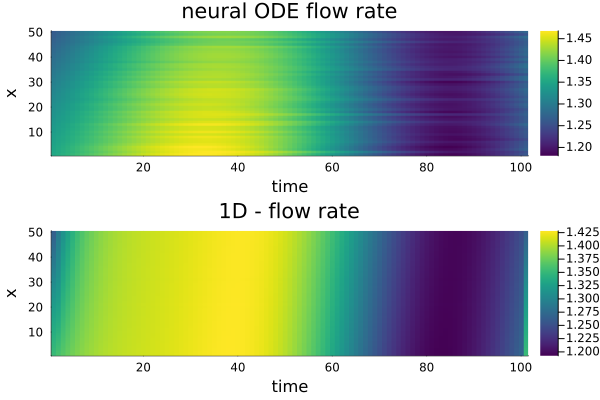

waveform: 2/4
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-97.44166
Changing learning rate to:0.0001
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 391.88348265694924
Iteration: 2 || Loss: 225.20908550085528
Iteration: 3 || Loss: 188.39630305777627
Iteration: 4 || Loss: 186.43854634564093
Iteration: 5 || Loss: 187.1187753537128
Iteration: 6 || Loss: 186.43854634564093
saving ADAM checkpoint...
Sum of params:-97.500854
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 186.43854634564093
Iteration: 2 || Loss: 156.17523889110535
Iteration: 3 || Loss: 119.2855833737542
Iteration: 4 || Loss: 75.9391939214854
Iteration: 5 || Loss: 44.86992176196072
Iteration: 6 || Loss: 55.84105281743225
Iteration: 7 || Loss: 70.0077501377583
Iteration: 8 || Loss: 55.95506782376766
Iteration: 9 || Loss: 42.08244843439962
Iteration: 10 || Loss: 36.11941517959046
Iteration: 11 || Loss: 36.82869116681725
Iteration: 12 || Loss: 39.51271719554701
Iteration: 13 

Iteration: 185 || Loss: 18.439018224770383
Iteration: 186 || Loss: 18.430141463553266
Iteration: 187 || Loss: 18.420878759763266
Iteration: 188 || Loss: 18.41085556280409
Iteration: 189 || Loss: 18.403498972277536
Iteration: 190 || Loss: 18.39371774756732
Iteration: 191 || Loss: 18.385859966114776
Iteration: 192 || Loss: 18.376039029071
Iteration: 193 || Loss: 18.36933093908425
Iteration: 194 || Loss: 18.35863117560487
Iteration: 195 || Loss: 18.35013782124531
Iteration: 196 || Loss: 18.342185545177323
Iteration: 197 || Loss: 18.335205225186787
Iteration: 198 || Loss: 18.32972094954703
Iteration: 199 || Loss: 18.318227421784513
Iteration: 200 || Loss: 18.311933441892716
Iteration: 201 || Loss: 18.302947543676574
Iteration: 202 || Loss: 18.295855401955208
Iteration: 203 || Loss: 18.290354634093013
Iteration: 204 || Loss: 18.28363733232036
Iteration: 205 || Loss: 18.27659882828796
Iteration: 206 || Loss: 18.26920752858767
Iteration: 207 || Loss: 18.260410872403817
Iteration: 208 || Loss:

Iteration: 378 || Loss: 17.66734403807361
Iteration: 379 || Loss: 17.666054752760207
Iteration: 380 || Loss: 17.66394425807919
Iteration: 381 || Loss: 17.662853860187024
Iteration: 382 || Loss: 17.660184997117753
Iteration: 383 || Loss: 17.658813880027626
Iteration: 384 || Loss: 17.654679696947795
Iteration: 385 || Loss: 17.653157082385828
Iteration: 386 || Loss: 17.651439387724725
Iteration: 387 || Loss: 17.648805125153636
Iteration: 388 || Loss: 17.64791471650247
Iteration: 389 || Loss: 17.64589380295931
Iteration: 390 || Loss: 17.64423166558147
Iteration: 391 || Loss: 17.641839287704286
Iteration: 392 || Loss: 17.639200579224045
Iteration: 393 || Loss: 17.636486583876227
Iteration: 394 || Loss: 17.634469450059946
Iteration: 395 || Loss: 17.633599124160394
Iteration: 396 || Loss: 17.63165641487091
Iteration: 397 || Loss: 17.630051114915858
Iteration: 398 || Loss: 17.62714770646023
Iteration: 399 || Loss: 17.625954796698657
Iteration: 400 || Loss: 17.623869617958178
Iteration: 401 || 

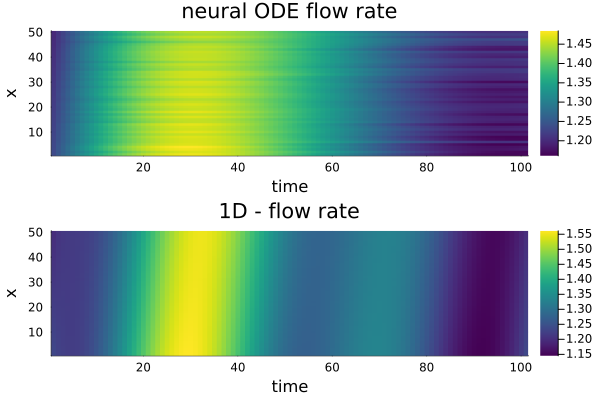

waveform: 3/4
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-96.2804
Changing learning rate to:0.0001
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 77.98275993679465
Iteration: 2 || Loss: 17.724294965389753
Iteration: 3 || Loss: 17.058754651468547
Iteration: 4 || Loss: 27.777693148219043
Iteration: 5 || Loss: 34.92442811961591
Iteration: 6 || Loss: 17.058754651468547
saving ADAM checkpoint...
Sum of params:-96.336815
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 17.058754651468547
Iteration: 2 || Loss: 19.508788484170026
Iteration: 3 || Loss: 9.291575683343444
Iteration: 4 || Loss: 10.048184128678521
Iteration: 5 || Loss: 14.322390883289554
Iteration: 6 || Loss: 13.314981228215185
Iteration: 7 || Loss: 9.740158162522633
Iteration: 8 || Loss: 8.064138641787403
Iteration: 9 || Loss: 9.047969638764993
Iteration: 10 || Loss: 9.749061191089794
Iteration: 11 || Loss: 9.334606669469302
Iteration: 12 || Loss: 8.887338989964329
Iteration: 

Iteration: 187 || Loss: 3.986290665609147
Iteration: 188 || Loss: 3.980994238747463
Iteration: 189 || Loss: 3.976380999369483
Iteration: 190 || Loss: 3.9718093200926843
Iteration: 191 || Loss: 3.966671159561768
Iteration: 192 || Loss: 3.961301317186531
Iteration: 193 || Loss: 3.956788486832119
Iteration: 194 || Loss: 3.951690609239054
Iteration: 195 || Loss: 3.946934710705462
Iteration: 196 || Loss: 3.9426476935659203
Iteration: 197 || Loss: 3.9377457474153212
Iteration: 198 || Loss: 3.9336586708596126
Iteration: 199 || Loss: 3.92820607428071
Iteration: 200 || Loss: 3.924756354302594
Iteration: 201 || Loss: 3.919485938291155
Iteration: 202 || Loss: 3.91504297294174
Iteration: 203 || Loss: 3.909690475603384
Iteration: 204 || Loss: 3.905344712740809
Iteration: 205 || Loss: 3.9001383985840015
Iteration: 206 || Loss: 3.89564267914603
Iteration: 207 || Loss: 3.891007879951879
Iteration: 208 || Loss: 3.887504307089081
Iteration: 209 || Loss: 3.8824207664548798
Iteration: 210 || Loss: 3.87870

Iteration: 380 || Loss: 3.2788306369022635
Iteration: 381 || Loss: 3.275531674104359
Iteration: 382 || Loss: 3.2728673802355344
Iteration: 383 || Loss: 3.2708225650975637
Iteration: 384 || Loss: 3.2676874500555613
Iteration: 385 || Loss: 3.2656573289594006
Iteration: 386 || Loss: 3.2631117871907924
Iteration: 387 || Loss: 3.260257963926531
Iteration: 388 || Loss: 3.2573172092823066
Iteration: 389 || Loss: 3.2548181509004377
Iteration: 390 || Loss: 3.2522387272618567
Iteration: 391 || Loss: 3.2498220936651263
Iteration: 392 || Loss: 3.2470237273598714
Iteration: 393 || Loss: 3.244497754179811
Iteration: 394 || Loss: 3.242275811524089
Iteration: 395 || Loss: 3.239622110630429
Iteration: 396 || Loss: 3.236533676624033
Iteration: 397 || Loss: 3.234479329452431
Iteration: 398 || Loss: 3.231610499459234
Iteration: 399 || Loss: 3.229569400550731
Iteration: 400 || Loss: 3.226352080547656
Iteration: 401 || Loss: 3.223938831922283
Iteration: 402 || Loss: 3.22143045928071
Iteration: 403 || Loss: 

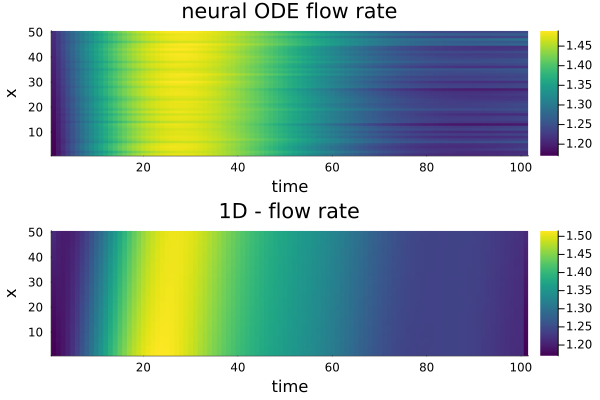

waveform: 4/4
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-97.096634
Changing learning rate to:0.0001
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 12.204817076514903
Iteration: 2 || Loss: 8.938117435855563
Iteration: 3 || Loss: 13.273122649716065
Iteration: 4 || Loss: 9.687040531416155
Iteration: 5 || Loss: 5.453135677437514
Iteration: 6 || Loss: 5.453135677437514
saving ADAM checkpoint...
Sum of params:-97.12202
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 5.453135677437514
Iteration: 2 || Loss: 24.447022235261613
Iteration: 3 || Loss: 5.494078091576544
Iteration: 4 || Loss: 8.083988749359566
Iteration: 5 || Loss: 14.138129849856352
Iteration: 6 || Loss: 15.257234461458932
Iteration: 7 || Loss: 11.967554824253906
Iteration: 8 || Loss: 7.254506274838789
Iteration: 9 || Loss: 4.63417271213066
Iteration: 10 || Loss: 6.248877903547015
Iteration: 11 || Loss: 9.50081928004528
Iteration: 12 || Loss: 9.475927712954874
Iteration: 13 |

Iteration: 187 || Loss: 4.28872111214589
Iteration: 188 || Loss: 4.288429613560895
Iteration: 189 || Loss: 4.287084397052193
Iteration: 190 || Loss: 4.287516867360054
Iteration: 191 || Loss: 4.286010440727498
Iteration: 192 || Loss: 4.285717236693864
Iteration: 193 || Loss: 4.2862640237327225
Iteration: 194 || Loss: 4.285108654109241
Iteration: 195 || Loss: 4.285195991904444
Iteration: 196 || Loss: 4.28242513617583
Iteration: 197 || Loss: 4.283931431607971
Iteration: 198 || Loss: 4.284055860947551
Iteration: 199 || Loss: 4.284075041040401
Iteration: 200 || Loss: 4.283469424388379
Iteration: 201 || Loss: 4.282944921106751
Iteration: 202 || Loss: 4.282600427824591
Iteration: 203 || Loss: 4.282558898472654
Iteration: 204 || Loss: 4.282345416858197
Iteration: 205 || Loss: 4.281199556004518
Iteration: 206 || Loss: 4.280534914017683
Iteration: 207 || Loss: 4.2799714348903235
Iteration: 208 || Loss: 4.28008756633451
Iteration: 209 || Loss: 4.280158073431252
Iteration: 210 || Loss: 4.279201059

Iteration: 382 || Loss: 4.214519690594443
Iteration: 383 || Loss: 4.215403323912277
Iteration: 384 || Loss: 4.216300162079906
Iteration: 385 || Loss: 4.216028292594678
Iteration: 386 || Loss: 4.215326580415811
Iteration: 387 || Loss: 4.215372953020332
Iteration: 388 || Loss: 4.212081250929307
Iteration: 389 || Loss: 4.214332782164014
Iteration: 390 || Loss: 4.214036600285845
Iteration: 391 || Loss: 4.213373495261701
Iteration: 392 || Loss: 4.213597156862692
Iteration: 393 || Loss: 4.210230380703933
Iteration: 394 || Loss: 4.212314930004653
Iteration: 395 || Loss: 4.212608487560985
Iteration: 396 || Loss: 4.211621349264625
Iteration: 397 || Loss: 4.210873337868325
Iteration: 398 || Loss: 4.209732801026924
Iteration: 399 || Loss: 4.210985238406986
Iteration: 400 || Loss: 4.2098503184336264
Iteration: 401 || Loss: 4.207673570649996
Iteration: 402 || Loss: 4.2076943441159855
Iteration: 403 || Loss: 4.207170061414345
Iteration: 404 || Loss: 4.207805772037705
Iteration: 405 || Loss: 4.206714

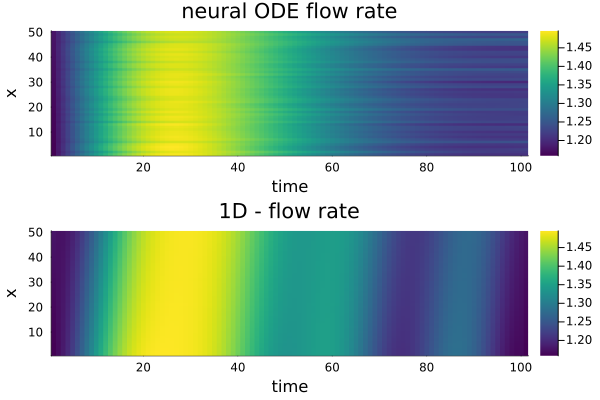

Epoch 3 mean loss loss:6.643881519052961
Start training epoch 4
time: 1/1
waveform: 1/4
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-96.95843
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 114.82173946632717
Iteration: 2 || Loss: 42.8146563699305
Iteration: 3 || Loss: 17.348517089527327
Iteration: 4 || Loss: 13.64310875880029
Iteration: 5 || Loss: 18.514316156686732
Iteration: 6 || Loss: 13.64310875880029
saving ADAM checkpoint...
Sum of params:-97.037506
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 13.64310875880029
Iteration: 2 || Loss: 19.332567550627445
Iteration: 3 || Loss: 13.19777751216822
Iteration: 4 || Loss: 14.77472731972873
Iteration: 5 || Loss: 15.830218986245178
Iteration: 6 || Loss: 14.65388243133551
Iteration: 7 || Loss: 13.361639549789917
Iteration: 8 || Loss: 12.940922809908159
Iteration: 9 || Loss: 13.084873075989698
Iteration: 10 || Loss: 13.006346807827468
Iteration: 11 || Loss: 12.63852928781136
Iteration: 

Iteration: 185 || Loss: 3.254135337997611
Iteration: 186 || Loss: 3.2763319597011153
Iteration: 187 || Loss: 3.2279215473108054
Iteration: 188 || Loss: 3.2322711343363943
Iteration: 189 || Loss: 3.202561844578679
Iteration: 190 || Loss: 3.1933178698677036
Iteration: 191 || Loss: 3.1747644642164463
Iteration: 192 || Loss: 3.1689144522632424
Iteration: 193 || Loss: 3.1417272610189055
Iteration: 194 || Loss: 3.1442997715195165
Iteration: 195 || Loss: 3.1153828245184036
Iteration: 196 || Loss: 3.109273303715712
Iteration: 197 || Loss: 3.0943854059579747
Iteration: 198 || Loss: 3.0755770614800726
Iteration: 199 || Loss: 3.0634322293663985
Iteration: 200 || Loss: 3.049080865324089
Iteration: 201 || Loss: 3.0367794752429633
Iteration: 202 || Loss: 3.0258837449015576
Iteration: 203 || Loss: 3.0151600553789346
Iteration: 204 || Loss: 2.9976349167813456
Iteration: 205 || Loss: 2.9891223267565494
Iteration: 206 || Loss: 2.9746208952235405
Iteration: 207 || Loss: 2.9615168185657703
Iteration: 208 

Iteration: 378 || Loss: 2.202128191529035
Iteration: 379 || Loss: 2.1554818465372034
Iteration: 380 || Loss: 2.1165578349251932
Iteration: 381 || Loss: 2.1171560899200204
Iteration: 382 || Loss: 2.198733299918242
Iteration: 383 || Loss: 2.2504917238114577
Iteration: 384 || Loss: 2.1848060604351494
Iteration: 385 || Loss: 2.141593585382632
Iteration: 386 || Loss: 2.1083224932982803
Iteration: 387 || Loss: 2.112329306683857
Iteration: 388 || Loss: 2.128496239954832
Iteration: 389 || Loss: 2.1236715630705243
Iteration: 390 || Loss: 2.1234484053016693
Iteration: 391 || Loss: 2.134548574464392
Iteration: 392 || Loss: 2.1644226648567666
Iteration: 393 || Loss: 2.122042730118383
Iteration: 394 || Loss: 2.128050138124138
Iteration: 395 || Loss: 2.1290792007187083
Iteration: 396 || Loss: 2.1788643927586318
Iteration: 397 || Loss: 2.220594844601796
Iteration: 398 || Loss: 2.124225995390973
Iteration: 399 || Loss: 2.0806134495989714
Iteration: 400 || Loss: 2.1034591408347705
Iteration: 401 || Los

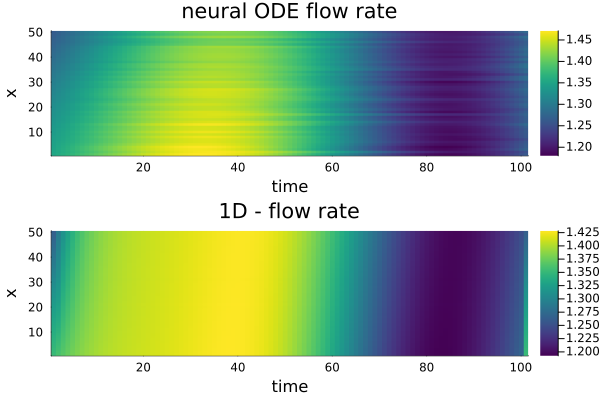

waveform: 2/4
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-97.551575
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 569.320525618426
Iteration: 2 || Loss: 305.23480302193866
Iteration: 3 || Loss: 202.73771837658262
Iteration: 4 || Loss: 181.19138384628167
Iteration: 5 || Loss: 179.01910505584058
Iteration: 6 || Loss: 179.01910505584058
saving ADAM checkpoint...
Sum of params:-97.59924
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 179.01910505584058
Iteration: 2 || Loss: 135.70841753384138
Iteration: 3 || Loss: 93.33069311092412
Iteration: 4 || Loss: 51.83340604103613
Iteration: 5 || Loss: 48.36897827520013
Iteration: 6 || Loss: 71.3410345713361
Iteration: 7 || Loss: 65.99166536388304
Iteration: 8 || Loss: 51.04363980021103
Iteration: 9 || Loss: 40.65703159768619
Iteration: 10 || Loss: 36.60457110982055
Iteration: 11 || Loss: 37.76085326076132
Iteration: 12 || Loss: 40.8224213865094
Iteration: 13 || Loss: 43.220646261549724
Iterat

Iteration: 185 || Loss: 18.08543352026524
Iteration: 186 || Loss: 18.07617029886674
Iteration: 187 || Loss: 18.06457622767896
Iteration: 188 || Loss: 18.057237622305614
Iteration: 189 || Loss: 18.048178550266822
Iteration: 190 || Loss: 18.037098069997942
Iteration: 191 || Loss: 18.028210060299383
Iteration: 192 || Loss: 18.02106725213208
Iteration: 193 || Loss: 18.013385224767397
Iteration: 194 || Loss: 18.004982220237903
Iteration: 195 || Loss: 17.99521777377975
Iteration: 196 || Loss: 17.986464983315358
Iteration: 197 || Loss: 17.977374972709292
Iteration: 198 || Loss: 17.97132185723818
Iteration: 199 || Loss: 17.962431833194763
Iteration: 200 || Loss: 17.956712052624802
Iteration: 201 || Loss: 17.94842262526635
Iteration: 202 || Loss: 17.94019824004097
Iteration: 203 || Loss: 17.93295594251976
Iteration: 204 || Loss: 17.925018612093634
Iteration: 205 || Loss: 17.9191472994411
Iteration: 206 || Loss: 17.912638183265347
Iteration: 207 || Loss: 17.90508830675959
Iteration: 208 || Loss:

Iteration: 378 || Loss: 17.334916682466663
Iteration: 379 || Loss: 17.333401779400873
Iteration: 380 || Loss: 17.331294676241555
Iteration: 381 || Loss: 17.330169027571074
Iteration: 382 || Loss: 17.328137241205233
Iteration: 383 || Loss: 17.32659062017882
Iteration: 384 || Loss: 17.323262768340214
Iteration: 385 || Loss: 17.321683738359383
Iteration: 386 || Loss: 17.320686611276024
Iteration: 387 || Loss: 17.318276786856348
Iteration: 388 || Loss: 17.316853645715295
Iteration: 389 || Loss: 17.314052609645977
Iteration: 390 || Loss: 17.313003016032063
Iteration: 391 || Loss: 17.311312558966883
Iteration: 392 || Loss: 17.30941681724434
Iteration: 393 || Loss: 17.307413287818584
Iteration: 394 || Loss: 17.30465029939064
Iteration: 395 || Loss: 17.303568300454135
Iteration: 396 || Loss: 17.301506451074445
Iteration: 397 || Loss: 17.300717703988862
Iteration: 398 || Loss: 17.298633722688585
Iteration: 399 || Loss: 17.296838062341052
Iteration: 400 || Loss: 17.29486210766308
Iteration: 401 

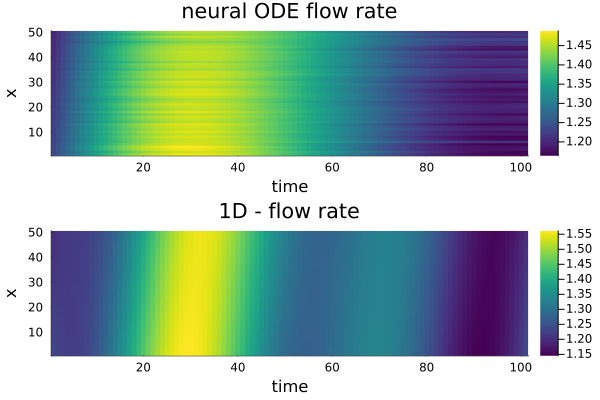

waveform: 3/4
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-96.332
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 78.36087096397253
Iteration: 2 || Loss: 17.897679161383394
Iteration: 3 || Loss: 17.626654595035244
Iteration: 4 || Loss: 27.744856488581902
Iteration: 5 || Loss: 34.71406088670116
Iteration: 6 || Loss: 17.626654595035244
saving ADAM checkpoint...
Sum of params:-96.38439
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 17.626654595035244
Iteration: 2 || Loss: 19.96783739652674
Iteration: 3 || Loss: 9.149671525329858
Iteration: 4 || Loss: 10.03218876093118
Iteration: 5 || Loss: 14.705150254722778
Iteration: 6 || Loss: 13.80201393054626
Iteration: 7 || Loss: 10.13589212429223
Iteration: 8 || Loss: 8.186536609838278
Iteration: 9 || Loss: 8.807032685273063
Iteration: 10 || Loss: 9.450004576660625
Iteration: 11 || Loss: 9.345253327340096
Iteration: 12 || Loss: 9.218355839333675
Iteration: 13 || Loss: 9.072201431253387
Iteratio

Iteration: 187 || Loss: 3.84297796031511
Iteration: 188 || Loss: 3.838629150600176
Iteration: 189 || Loss: 3.8339680362872497
Iteration: 190 || Loss: 3.8292860340134975
Iteration: 191 || Loss: 3.8247299704004027
Iteration: 192 || Loss: 3.81999417155828
Iteration: 193 || Loss: 3.8147756864702727
Iteration: 194 || Loss: 3.81075881368738
Iteration: 195 || Loss: 3.8060848670794556
Iteration: 196 || Loss: 3.801117258625533
Iteration: 197 || Loss: 3.796897883654706
Iteration: 198 || Loss: 3.791930578115776
Iteration: 199 || Loss: 3.7873772377220813
Iteration: 200 || Loss: 3.782730989360065
Iteration: 201 || Loss: 3.7783476070167747
Iteration: 202 || Loss: 3.773730172751209
Iteration: 203 || Loss: 3.7697076505068523
Iteration: 204 || Loss: 3.764977593248889
Iteration: 205 || Loss: 3.7602132217612194
Iteration: 206 || Loss: 3.7558453233198072
Iteration: 207 || Loss: 3.7517216634278996
Iteration: 208 || Loss: 3.7470899407991523
Iteration: 209 || Loss: 3.743159421976333
Iteration: 210 || Loss: 3

Iteration: 380 || Loss: 3.1556968429775143
Iteration: 381 || Loss: 3.152737627117
Iteration: 382 || Loss: 3.151080892372798
Iteration: 383 || Loss: 3.1475116882428624
Iteration: 384 || Loss: 3.1452109156657553
Iteration: 385 || Loss: 3.143268851753457
Iteration: 386 || Loss: 3.1404792398276893
Iteration: 387 || Loss: 3.1373725980958658
Iteration: 388 || Loss: 3.1347894425564755
Iteration: 389 || Loss: 3.132460080109615
Iteration: 390 || Loss: 3.1296606417783703
Iteration: 391 || Loss: 3.1271081963972223
Iteration: 392 || Loss: 3.124606462255432
Iteration: 393 || Loss: 3.1221581634320392
Iteration: 394 || Loss: 3.1195938832079504
Iteration: 395 || Loss: 3.1175245495610397
Iteration: 396 || Loss: 3.1145558994887095
Iteration: 397 || Loss: 3.1121454584191417
Iteration: 398 || Loss: 3.1100906167133924
Iteration: 399 || Loss: 3.1072637605711058
Iteration: 400 || Loss: 3.104683346412621
Iteration: 401 || Loss: 3.1022699782373646
Iteration: 402 || Loss: 3.10041749677365
Iteration: 403 || Loss

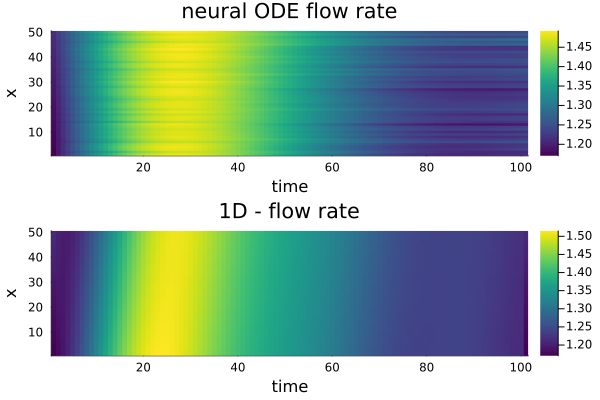

waveform: 4/4
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-97.12684
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 12.125675667213748
Iteration: 2 || Loss: 8.722638136746895
Iteration: 3 || Loss: 12.924190818102495
Iteration: 4 || Loss: 9.489486664834484
Iteration: 5 || Loss: 5.4731557814049445
Iteration: 6 || Loss: 5.4731557814049445
saving ADAM checkpoint...
Sum of params:-97.157425
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 5.4731557814049445
Iteration: 2 || Loss: 23.059089661519337
Iteration: 3 || Loss: 5.346253244411415
Iteration: 4 || Loss: 7.906235810117056
Iteration: 5 || Loss: 13.617747041307508
Iteration: 6 || Loss: 14.396056867335538
Iteration: 7 || Loss: 10.978748522864418
Iteration: 8 || Loss: 6.5175128425445905
Iteration: 9 || Loss: 4.517399368058547
Iteration: 10 || Loss: 6.586816144454833
Iteration: 11 || Loss: 9.407745238370609
Iteration: 12 || Loss: 8.734219859882668
Iteration: 13 || Loss: 6.027728848758931
I

Iteration: 188 || Loss: 4.183764689916556
Iteration: 189 || Loss: 4.182939445859379
Iteration: 190 || Loss: 4.182306771430362
Iteration: 191 || Loss: 4.183194959350566
Iteration: 192 || Loss: 4.182848709234526
Iteration: 193 || Loss: 4.182462495960451
Iteration: 194 || Loss: 4.1813770592073745
Iteration: 195 || Loss: 4.180975354609101
Iteration: 196 || Loss: 4.180271792065685
Iteration: 197 || Loss: 4.179450628574683
Iteration: 198 || Loss: 4.180433957214954
Iteration: 199 || Loss: 4.1800850608236875
Iteration: 200 || Loss: 4.179678215163929
Iteration: 201 || Loss: 4.179123776741009
Iteration: 202 || Loss: 4.177938280385261
Iteration: 203 || Loss: 4.178070097428592
Iteration: 204 || Loss: 4.177961657179309
Iteration: 205 || Loss: 4.176734320208598
Iteration: 206 || Loss: 4.177444732085648
Iteration: 207 || Loss: 4.176828576938901
Iteration: 208 || Loss: 4.176509612408639
Iteration: 209 || Loss: 4.1757451387191304
Iteration: 210 || Loss: 4.17577199388208
Iteration: 211 || Loss: 4.175260

Iteration: 383 || Loss: 4.11246295106448
Iteration: 384 || Loss: 4.112725736875882
Iteration: 385 || Loss: 4.112109312396123
Iteration: 386 || Loss: 4.112659738592283
Iteration: 387 || Loss: 4.111630723506426
Iteration: 388 || Loss: 4.111842931809354
Iteration: 389 || Loss: 4.11145094792311
Iteration: 390 || Loss: 4.110935219668352
Iteration: 391 || Loss: 4.109978154127072
Iteration: 392 || Loss: 4.109736113167807
Iteration: 393 || Loss: 4.109506023927645
Iteration: 394 || Loss: 4.108941754398185
Iteration: 395 || Loss: 4.10850358989838
Iteration: 396 || Loss: 4.108062723946523
Iteration: 397 || Loss: 4.108380003075
Iteration: 398 || Loss: 4.1079761451551
Iteration: 399 || Loss: 4.107879881383633
Iteration: 400 || Loss: 4.1073756734503455
Iteration: 401 || Loss: 4.10695591120418
Iteration: 402 || Loss: 4.1057229907596415
Iteration: 403 || Loss: 4.105881482707098
Iteration: 404 || Loss: 4.1061626338701345
Iteration: 405 || Loss: 4.106078267382483
Iteration: 406 || Loss: 4.10581926788126

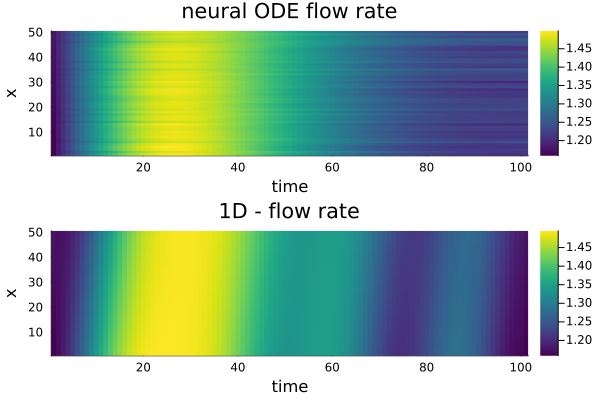

Epoch 4 mean loss loss:6.515380780466224
Start training epoch 5
time: 1/1
waveform: 1/4
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-96.870995
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 93.65807662889573
Iteration: 2 || Loss: 34.644970477517056
Iteration: 3 || Loss: 15.555460362631283
Iteration: 4 || Loss: 14.525541819683578
Iteration: 5 || Loss: 20.07332350731634
Iteration: 6 || Loss: 14.525541819683578
saving ADAM checkpoint...
Sum of params:-96.94352
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 14.525541819683578
Iteration: 2 || Loss: 17.848407076541374
Iteration: 3 || Loss: 13.664413910723326
Iteration: 4 || Loss: 14.229809005061536
Iteration: 5 || Loss: 14.930276755069574
Iteration: 6 || Loss: 14.003474090253588
Iteration: 7 || Loss: 13.126323425494547
Iteration: 8 || Loss: 13.049888568595506
Iteration: 9 || Loss: 13.18705005034173
Iteration: 10 || Loss: 12.886620301645824
Iteration: 11 || Loss: 12.433430281601517
Itera

Iteration: 185 || Loss: 3.1157926231749458
Iteration: 186 || Loss: 3.100602495175323
Iteration: 187 || Loss: 3.090634991388526
Iteration: 188 || Loss: 3.0761933969881974
Iteration: 189 || Loss: 3.0646882666038375
Iteration: 190 || Loss: 3.0498908439197994
Iteration: 191 || Loss: 3.0391326197012036
Iteration: 192 || Loss: 3.024620929394838
Iteration: 193 || Loss: 3.0132478808087733
Iteration: 194 || Loss: 2.999764409932858
Iteration: 195 || Loss: 2.986153205595808
Iteration: 196 || Loss: 2.974892025813163
Iteration: 197 || Loss: 2.963991445207829
Iteration: 198 || Loss: 2.9524146920888996
Iteration: 199 || Loss: 2.940073152942045
Iteration: 200 || Loss: 2.927303700483688
Iteration: 201 || Loss: 2.91576629354097
Iteration: 202 || Loss: 2.906173788442177
Iteration: 203 || Loss: 2.8920587396272195
Iteration: 204 || Loss: 2.8825229586580114
Iteration: 205 || Loss: 2.8710267655041726
Iteration: 206 || Loss: 2.8610094932865002
Iteration: 207 || Loss: 2.8488310181718894
Iteration: 208 || Loss:

Iteration: 378 || Loss: 2.6585096105304973
Iteration: 379 || Loss: 2.7232021565773064
Iteration: 380 || Loss: 2.569784487623175
Iteration: 381 || Loss: 2.2886806532013892
Iteration: 382 || Loss: 2.1306586364183184
Iteration: 383 || Loss: 2.128330982744108
Iteration: 384 || Loss: 2.188346241718515
Iteration: 385 || Loss: 2.228136032968488
Iteration: 386 || Loss: 2.1905071221530985
Iteration: 387 || Loss: 2.1552903465260087
Iteration: 388 || Loss: 2.0983008050453766
Iteration: 389 || Loss: 2.1020082292235998
Iteration: 390 || Loss: 2.1539914475743016
Iteration: 391 || Loss: 2.22695088356131
Iteration: 392 || Loss: 2.2075232526553243
Iteration: 393 || Loss: 2.132571147348752
Iteration: 394 || Loss: 2.107446852550834
Iteration: 395 || Loss: 2.089551688742474
Iteration: 396 || Loss: 2.084964028913583
Iteration: 397 || Loss: 2.0747651412868855
Iteration: 398 || Loss: 2.0874666103699155
Iteration: 399 || Loss: 2.0922028779348034
Iteration: 400 || Loss: 2.090117761418478
Iteration: 401 || Loss

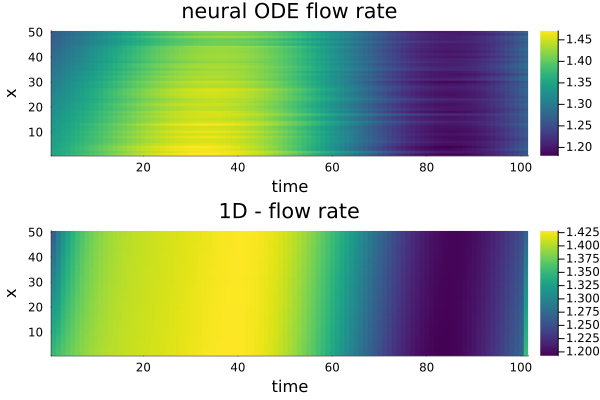

waveform: 2/4
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-97.59954
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 762.4723892825455
Iteration: 2 || Loss: 399.99974052368395
Iteration: 3 || Loss: 215.27969943934397
Iteration: 4 || Loss: 163.975918266827
Iteration: 5 || Loss: 157.3174503792243
Iteration: 6 || Loss: 157.3174503792243
saving ADAM checkpoint...
Sum of params:-97.603714
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 157.3174503792243
Iteration: 2 || Loss: 103.19944195871273
Iteration: 3 || Loss: 63.08225690892982
Iteration: 4 || Loss: 44.215365097111494
Iteration: 5 || Loss: 64.8976605262342
Iteration: 6 || Loss: 67.82051196840483
Iteration: 7 || Loss: 53.920590279538885
Iteration: 8 || Loss: 42.91361869142368
Iteration: 9 || Loss: 37.42225482061509
Iteration: 10 || Loss: 36.78278676913418
Iteration: 11 || Loss: 38.74853952654269
Iteration: 12 || Loss: 40.30600463077614
Iteration: 13 || Loss: 40.54794302509232
Iteratio

Iteration: 186 || Loss: 17.727913198692505
Iteration: 187 || Loss: 17.71983913499555
Iteration: 188 || Loss: 17.712425496841263
Iteration: 189 || Loss: 17.705491878713563
Iteration: 190 || Loss: 17.69551932581107
Iteration: 191 || Loss: 17.688767457786742
Iteration: 192 || Loss: 17.680849606350627
Iteration: 193 || Loss: 17.675148995573572
Iteration: 194 || Loss: 17.666859282296205
Iteration: 195 || Loss: 17.658585432430492
Iteration: 196 || Loss: 17.651665372663448
Iteration: 197 || Loss: 17.645491143547865
Iteration: 198 || Loss: 17.638326534834935
Iteration: 199 || Loss: 17.631704878920388
Iteration: 200 || Loss: 17.624287897503724
Iteration: 201 || Loss: 17.617113946346
Iteration: 202 || Loss: 17.61083915300886
Iteration: 203 || Loss: 17.604248535713907
Iteration: 204 || Loss: 17.598245517992083
Iteration: 205 || Loss: 17.589169473968767
Iteration: 206 || Loss: 17.585768801289976
Iteration: 207 || Loss: 17.577432424466757
Iteration: 208 || Loss: 17.57232444550528
Iteration: 209 || 

Iteration: 378 || Loss: 17.08175746123268
Iteration: 379 || Loss: 17.081610434739957
Iteration: 380 || Loss: 17.07984461030386
Iteration: 381 || Loss: 17.078253404870065
Iteration: 382 || Loss: 17.076166889014047
Iteration: 383 || Loss: 17.07492768911269
Iteration: 384 || Loss: 17.072827353352796
Iteration: 385 || Loss: 17.070494739789357
Iteration: 386 || Loss: 17.069471385840348
Iteration: 387 || Loss: 17.06823372352453
Iteration: 388 || Loss: 17.06715438542164
Iteration: 389 || Loss: 17.064967503540753
Iteration: 390 || Loss: 17.063247383574208
Iteration: 391 || Loss: 17.062035458056986
Iteration: 392 || Loss: 17.05958011501671
Iteration: 393 || Loss: 17.058615855182733
Iteration: 394 || Loss: 17.056868325423537
Iteration: 395 || Loss: 17.055604164452838
Iteration: 396 || Loss: 17.053778434017136
Iteration: 397 || Loss: 17.051701392885192
Iteration: 398 || Loss: 17.050132760778347
Iteration: 399 || Loss: 17.04838677697434
Iteration: 400 || Loss: 17.04757909663481
Iteration: 401 || L

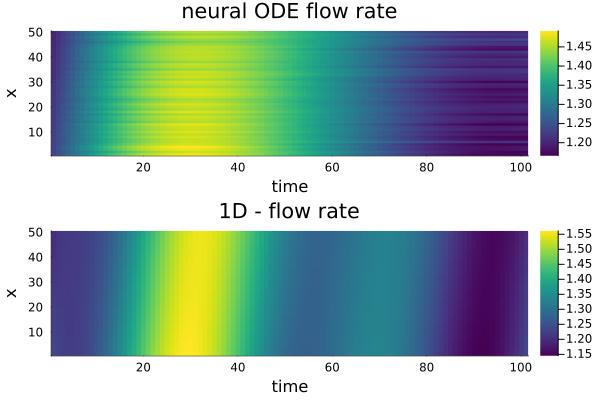

waveform: 3/4
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-96.30063
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 79.82113504823539
Iteration: 2 || Loss: 18.198488323255553
Iteration: 3 || Loss: 17.69894351729262
Iteration: 4 || Loss: 27.717406580343958
Iteration: 5 || Loss: 34.88920958162225
Iteration: 6 || Loss: 17.69894351729262
saving ADAM checkpoint...
Sum of params:-96.35072
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 17.69894351729262
Iteration: 2 || Loss: 19.52986372801412
Iteration: 3 || Loss: 8.852793433389591
Iteration: 4 || Loss: 10.095355731869109
Iteration: 5 || Loss: 14.736227485673671
Iteration: 6 || Loss: 13.462270206943051
Iteration: 7 || Loss: 9.706950235905474
Iteration: 8 || Loss: 8.00843514648317
Iteration: 9 || Loss: 8.737074792271576
Iteration: 10 || Loss: 9.28090096053161
Iteration: 11 || Loss: 9.223721679619416
Iteration: 12 || Loss: 9.186741727267298
Iteration: 13 || Loss: 9.012135805000145
Iteration

Iteration: 187 || Loss: 3.6859258021029686
Iteration: 188 || Loss: 3.6813773203428974
Iteration: 189 || Loss: 3.6766116273441316
Iteration: 190 || Loss: 3.6730522048958667
Iteration: 191 || Loss: 3.667913950468217
Iteration: 192 || Loss: 3.6635748770483856
Iteration: 193 || Loss: 3.6594403052606967
Iteration: 194 || Loss: 3.6555101944845827
Iteration: 195 || Loss: 3.6505291037339527
Iteration: 196 || Loss: 3.6460670341864354
Iteration: 197 || Loss: 3.6420957382429435
Iteration: 198 || Loss: 3.637742647194156
Iteration: 199 || Loss: 3.6332430231612927
Iteration: 200 || Loss: 3.629560364507496
Iteration: 201 || Loss: 3.6249578482719955
Iteration: 202 || Loss: 3.620495038062128
Iteration: 203 || Loss: 3.616192809871342
Iteration: 204 || Loss: 3.612456524863962
Iteration: 205 || Loss: 3.6077906603583556
Iteration: 206 || Loss: 3.6043206506384893
Iteration: 207 || Loss: 3.60000887714504
Iteration: 208 || Loss: 3.5953016424585007
Iteration: 209 || Loss: 3.591133078862452
Iteration: 210 || Lo

Iteration: 380 || Loss: 3.0380484410690407
Iteration: 381 || Loss: 3.0355497113355274
Iteration: 382 || Loss: 3.034069486363756
Iteration: 383 || Loss: 3.030863109851019
Iteration: 384 || Loss: 3.0291091868679185
Iteration: 385 || Loss: 3.025942616342385
Iteration: 386 || Loss: 3.023616383126993
Iteration: 387 || Loss: 3.0209426148269007
Iteration: 388 || Loss: 3.0195108071877748
Iteration: 389 || Loss: 3.0161167393758723
Iteration: 390 || Loss: 3.013744961231441
Iteration: 391 || Loss: 3.0115028060215447
Iteration: 392 || Loss: 3.008980168467492
Iteration: 393 || Loss: 3.006535437838953
Iteration: 394 || Loss: 3.004190387884218
Iteration: 395 || Loss: 3.0026695724358072
Iteration: 396 || Loss: 2.999593537396011
Iteration: 397 || Loss: 2.997504985813282
Iteration: 398 || Loss: 2.9957719142793726
Iteration: 399 || Loss: 2.992468839109328
Iteration: 400 || Loss: 2.9901529498480426
Iteration: 401 || Loss: 2.9889024342145185
Iteration: 402 || Loss: 2.9855011173292905
Iteration: 403 || Loss

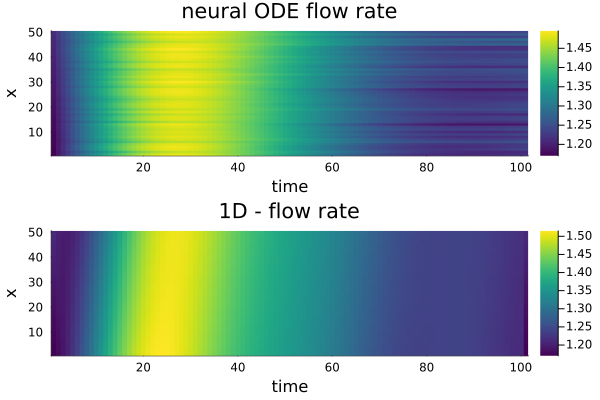

waveform: 4/4
(0.0, 1.0)
Using ADAM optimizer
Sum of params:-97.09653
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 12.296367635061006
Iteration: 2 || Loss: 8.463003609816433
Iteration: 3 || Loss: 12.747716462907352
Iteration: 4 || Loss: 9.577243262467212
Iteration: 5 || Loss: 5.649286410603606
Iteration: 6 || Loss: 5.649286410603606
saving ADAM checkpoint...
Sum of params:-97.13409
Switching to ADAM optimizer
Max iters:500
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 5.649286410603606
Iteration: 2 || Loss: 21.222588306644873
Iteration: 3 || Loss: 5.227980266047451
Iteration: 4 || Loss: 7.672707199422106
Iteration: 5 || Loss: 12.855752805559137
Iteration: 6 || Loss: 13.148967653203272
Iteration: 7 || Loss: 9.596247676018077
Iteration: 8 || Loss: 5.6112950224659075
Iteration: 9 || Loss: 4.606696180787923
Iteration: 10 || Loss: 7.188231315081156
Iteration: 11 || Loss: 9.076321662673385
Iteration: 12 || Loss: 7.547461021465668
Iteration: 13 || Loss: 5.185321627698221
Iterat

Iteration: 188 || Loss: 4.103848076408703
Iteration: 189 || Loss: 4.104348307638141
Iteration: 190 || Loss: 4.105081412149602
Iteration: 191 || Loss: 4.103687684258105
Iteration: 192 || Loss: 4.104251883080202
Iteration: 193 || Loss: 4.102319152038275
Iteration: 194 || Loss: 4.101401528882353
Iteration: 195 || Loss: 4.102869043192241
Iteration: 196 || Loss: 4.10078341070049
Iteration: 197 || Loss: 4.100829924918474
Iteration: 198 || Loss: 4.100963740861429
Iteration: 199 || Loss: 4.100222202329967
Iteration: 200 || Loss: 4.098831115686124
Iteration: 201 || Loss: 4.101044337893271
Iteration: 202 || Loss: 4.100695911830167
Iteration: 203 || Loss: 4.098375497675743
Iteration: 204 || Loss: 4.0986711979379145
Iteration: 205 || Loss: 4.096909464550742
Iteration: 206 || Loss: 4.097570144818611
Iteration: 207 || Loss: 4.096922636008115
Iteration: 208 || Loss: 4.096796517288023
Iteration: 209 || Loss: 4.096918660892175
Iteration: 210 || Loss: 4.09657222401172
Iteration: 211 || Loss: 4.097639566

Iteration: 384 || Loss: 4.038270474707628
Iteration: 385 || Loss: 4.037929843554151
Iteration: 386 || Loss: 4.038327372339351
Iteration: 387 || Loss: 4.039250819085549
Iteration: 388 || Loss: 4.038052078430931
Iteration: 389 || Loss: 4.037654953496853
Iteration: 390 || Loss: 4.036222232465302
Iteration: 391 || Loss: 4.0367529398650985
Iteration: 392 || Loss: 4.038072460130923
Iteration: 393 || Loss: 4.03570003935847
Iteration: 394 || Loss: 4.035359035049936
Iteration: 395 || Loss: 4.035449151985327
Iteration: 396 || Loss: 4.035293758156447
Iteration: 397 || Loss: 4.034209626039135
Iteration: 398 || Loss: 4.034181745786711
Iteration: 399 || Loss: 4.034133959644272
Iteration: 400 || Loss: 4.033610053525001
Iteration: 401 || Loss: 4.034673021784725
Iteration: 402 || Loss: 4.033038043178237
Iteration: 403 || Loss: 4.032511105363678
Iteration: 404 || Loss: 4.0324594297281084
Iteration: 405 || Loss: 4.03203565895625
Iteration: 406 || Loss: 4.032216947076835
Iteration: 407 || Loss: 4.03139596

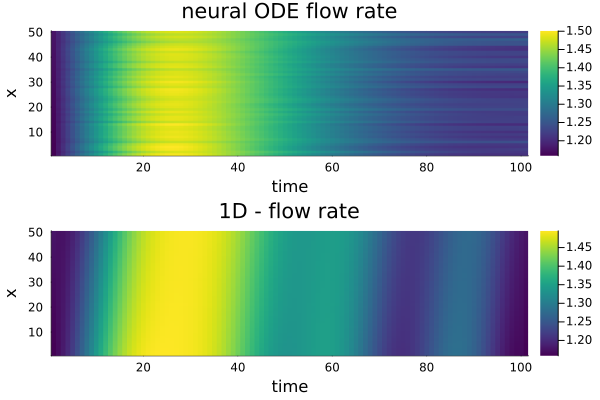

Epoch 5 mean loss loss:6.4188851237298


In [68]:
uinit = p

n_epochs = 5

#set time horizon settings
# nt = 100


list_loss_train = []
list_loss_epoch = []
# ntlist = [50,100]
ntlist = [100]
for nt in ntlist
    
    n_samples = Int(100/nt)+1
    println("nt:",nt)


    # epochs loop
    for j in 1:n_epochs
        println("Start training epoch ",j)
        loss_tot = 0.0
    
        # time horizon loop
        for k in 2:n_samples
            println("time: ",k-1, "/",n_samples-1)


            # loop over different waveforms
            for i in 1:size(ytrain2val,3)
                
                println("waveform: ",i, "/",size(ytrain2val,3))
                
                
                
                T = dt * nt  # total time
                tspan = (0.0, T)
                println(tspan)
                tsteps = 0:dt:tspan[2]  # create time vector

                #define BC only on the time horizon that is active, zero otherwise
                bcflow_k = zero(bc_flow1)
                bcflow_k[(k-2)*nt+1:(k-1)*nt+1] = bc_flow_val[(k-2)*nt+1:(k-1)*nt+1,i]

                #define optimization problem
                prob = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t, bcflow_k), ytrain2val[(k-2)*nt+1,:,i], tspan, p);

                optf = Optimization.OptimizationFunction((x,p)->loss(x,ytrain2val[(k-2)*nt+1:(k-1)*nt+1,:,i]',prob),adtype) ;

                println("Using $optimizer_choice1 optimizer")
                println("Sum of params:", sum(uinit))

                # Change learning rate for ADAM optimizer, BFGS doesn't use it
                if j == 3
                    learning_rate = 0.0001
                    println("Changing learning rate to:",learning_rate)
                end

                uinit = train_loop(uinit,adtype,optf,train_maxiters,learning_rate,optimizer_choice1)
                println("Sum of params:", sum(uinit))

                if !isnothing(optimizer_choice2)
                    println("Switching to $optimizer_choice2 optimizer")

                    uinit = train_loop(uinit,adtype,optf,train_maxiters*100,learning_rate,optimizer_choice2)

                    println("Sum of params:", sum(uinit))

                end

                #calculate final loss and push it to the list
                prob = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t,bcflow_k), ytrain2val[(k-2)*nt+1,:,i], tspan, p);
                l , pred = loss(uinit,ytrain2val[(k-2)*nt+1:(k-1)*nt+1,:,i]',prob)
                loss_tot = loss_tot + l

                push!(list_loss_train, l)
                println("Epoch ", j, " loss:", l)


                # plot solution for comparison
                plot1 = heatmap(pred[:,:], color=:viridis, title = "neural ODE flow rate")
                xlabel!("time")
                ylabel!("x")

                plot2 = heatmap(ytrain2val[(k-2)*nt+1:(k-1)*nt+1,:,i]', title="1D - flow rate", color=:viridis)
                xlabel!("time")
                ylabel!("x")
                display(plot(plot1,plot2,layout = (2, 1)))
                sleep(1)
            end
            
        end
    push!(list_loss_epoch, loss_tot/(size(ytrain2val,3)*(n_samples-1)))
    println("Epoch ", j, " mean loss loss:", loss_tot/(size(ytrain2val,3)*(n_samples-1)))
    end

    
end

### Step-by-step inference ###

In [126]:
# p_learn = load("/home/tschala/research/LANL/paramBC_testNODE/ptrained_BFGS.jld2")
# #waveform to evaluate
# wv = 1
# u01 = u0[:,wv]
# p = p_learn["p"]

# nt = 10
# T = dt * nt  # total time
# tspan = (0.0, T)
# tsteps = 0:dt:tspan[2]  # create time vector  

0.0:0.01:0.1

In [131]:
# sol_list = []
# for k in 2:11
#     println("t:",((k-2)*nt+1)*dt)
#     begin 
#         println(sum(u01))
#         learn_1DBlood_prob_untrained(u01,tspan) = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t, bc_flow[k-1,wv]), u01[:,end], tspan, p)     # p changes after training   
# #         u01 = ytrain2[(k-2)*nt+1,:,wv]
# #         learn_1DBlood_prob_untrained(u01,tspan) = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t, bc_flow[(k-2)*nt+1,wv]), u01, tspan, p)     # p changes after training   

            
#         if ode_solver == "Tsit5"
#             sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Tsit5(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#         elseif ode_solver == "RK4"
#             sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),RK4(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#         elseif ode_solver == "Rosenbrock23"
#             sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Rosenbrock23(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#         end
#         save_object(output_dir*"/sol_learn_paramBC_testNODE_trained.jld2",sol_learn_1DBlood_untrained)
#         println("saved trained solution")
#     end

#     sol_learn = load("/home/tschala/research/LANL/paramBC_testNODE/output/sol_learn_paramBC_testNODE_trained.jld2");
#     solution = sol_learn["single_stored_object"]
#     #overwrite initial condition by the solution
#     u01 = solution[:,2:end]
#     push!(sol_list,u01)
#     l = sum(abs2,u01-ytrain2[(k-2)*nt+1:(k-1)*nt,:,wv]')
#     println("Loss: ",l)
    
    
    
# # multiply = Float32.(vcat(zeros(size(solution)[2])',ones(size(solution)[1]-1,size(solution)[2])))
# # add = Float32.(vcat( bc_flow[:,wv]',zeros(size(solution)[1]-1,size(solution)[2])))
# # sol = solution.*multiply.+add
# end

# combined_sol = hcat(sol_list...);

# # sol = combined_sol[:,2:2:end];
# sol = combined_sol[:,:];

t:0.01
1512.8225980434204
saved trained solution
Loss: 1.3094590686431937
t:0.11
1499.0022035988716
saved trained solution
Loss: 45.88995970107579
t:0.21
1485.1817717310107
saved trained solution
Loss: 166.03289571339414
t:0.31
1471.3613010710685
saved trained solution
Loss: 201.69458180677182
t:0.41000000000000003
1457.5407821061353
saved trained solution
Loss: 100.65537789230933
t:0.51
1443.7202121595947
saved trained solution
Loss: 14.399602998020736
t:0.61
1429.8995878709964
saved trained solution
Loss: 5.772021530560427
t:0.71
1416.0789001858166
saved trained solution
Loss: 18.408064093324786
t:0.81
1402.2581533817172
saved trained solution
Loss: 21.566439159871727
t:0.91
1388.4373405339297
saved trained solution
Loss: 16.13946028735416


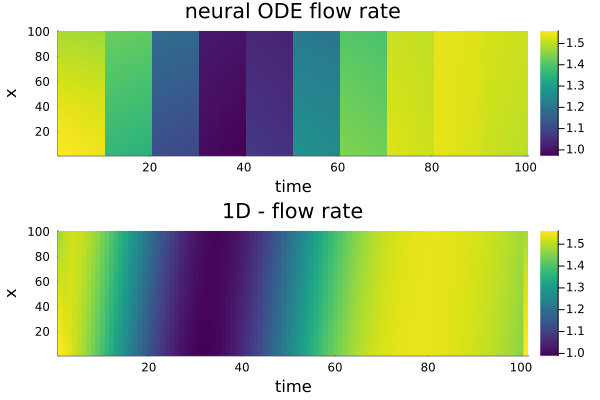

In [130]:
# plot1 = heatmap(sol[:,:], color=:viridis, title = "neural ODE flow rate")
# xlabel!("time")
# ylabel!("x")

# plot2 = heatmap(ytrain2[:,:,wv]', title="1D - flow rate", color=:viridis)
# xlabel!("time")
# ylabel!("x")

# plot(plot1,plot2,layout = (2, 1))